# Description

It runs DBSCAN on the z_score_std version of the data.

The notebook explores different values for min_samples and eps (the main parameters of DBSCAN).

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

from utils import generate_result_set_name
from clustering.ensemble import generate_ensemble

# Global settings

In [5]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

# Data version: z_score_std

## Settings

In [6]:
INPUT_SUBSET = "z_score_std"

In [7]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [8]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [9]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_RUNS_DIR"],
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

## Load input file

In [10]:
data = pd.read_pickle(input_filepath)

In [11]:
data.shape

(3749, 987)

In [12]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.553743,1.851060,-0.095721,0.931603,-0.515196,1.371264,-0.413165,0.729668,0.546338,0.901153,...,1.148776,1.649018,-1.375952,2.203063,0.810199,-0.987048,0.277710,-0.607613,0.572376,-0.660846
100002_raw-Energy,-1.313905,-0.421015,-0.310524,-0.201978,0.233028,0.693838,0.084129,0.572439,0.217866,1.296973,...,0.165430,0.799276,-0.361989,-0.008253,2.063780,-0.930765,-0.147007,1.601938,-0.273553,-0.560822
100003_raw-Protein,-0.645622,-0.997845,0.249039,0.256499,0.422357,0.829189,-0.169004,0.511550,0.002389,-0.057200,...,1.016791,1.019488,-2.148844,-0.065130,0.041052,-0.836118,-0.320571,1.325519,-0.341494,-0.495786
100004_raw-Fat,-0.913924,-1.837183,0.012095,-1.301315,0.205794,1.129114,0.019985,0.376660,-0.810272,0.843611,...,0.544266,0.576714,0.281731,-0.218963,1.258957,-1.131924,0.378545,0.842047,-0.622194,-0.160058
100005_raw-Carbohydrate,-0.523004,0.131379,-0.097802,-0.030526,-0.021500,-0.219116,0.668229,0.365700,1.102347,0.845625,...,-0.344740,0.079274,0.253427,0.236474,1.033895,-0.229105,0.364793,1.776714,0.190531,-1.459641


In [13]:
assert not data.isna().any().any()

## Tests different k values (k-NN)

In [14]:
k_values = np.arange(2, 120 + 1, 1)
k_values_to_explore = (2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125)

In [15]:
results = {}

for k in k_values_to_explore:
    nbrs = NearestNeighbors(n_neighbors=k, n_jobs=N_JOBS).fit(data)
    distances, indices = nbrs.kneighbors(data)
    results[k] = (distances, indices)

In [16]:
min_max_range = (40, 100)

eps_range_per_k = {k: min_max_range for k in k_values}
eps_range_per_k_to_explore = {k: min_max_range for k in k_values_to_explore}

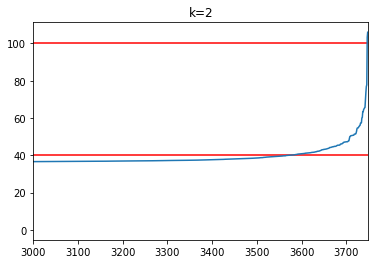

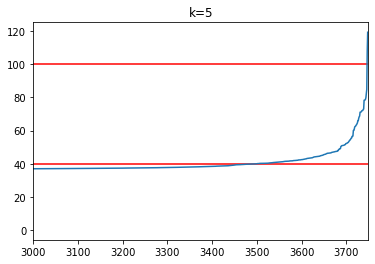

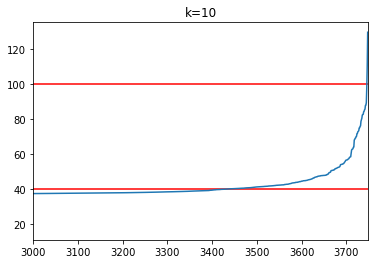

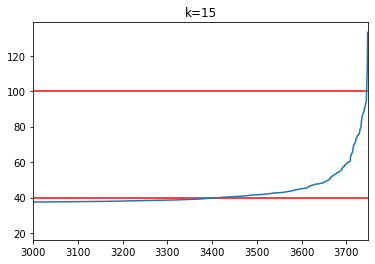

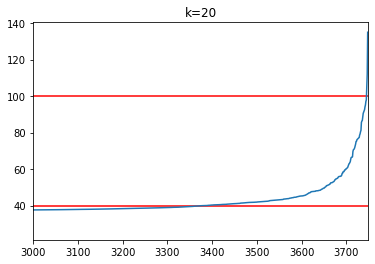

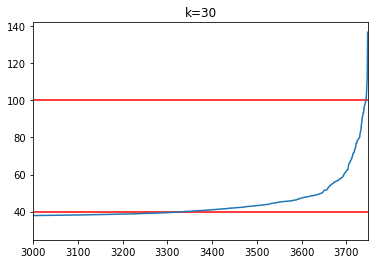

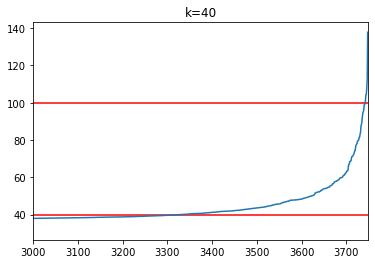

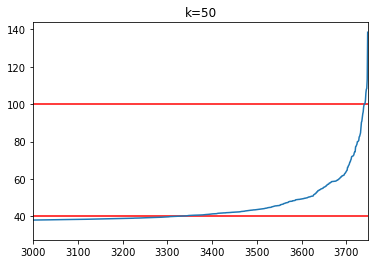

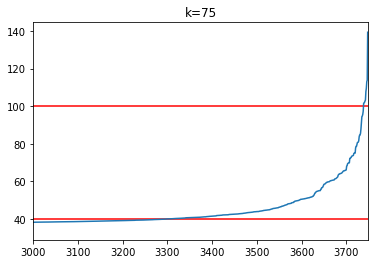

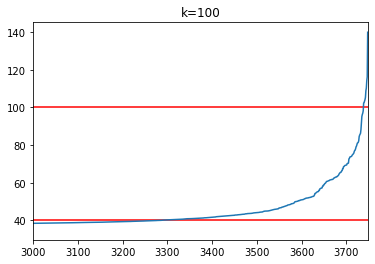

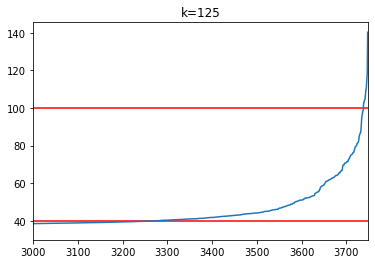

In [17]:
for k, (distances, indices) in results.items():
    d = distances[:, 1:].mean(axis=1)
    d = np.sort(d)

    fig, ax = plt.subplots()
    plt.plot(d)

    r = eps_range_per_k_to_explore[k]
    plt.hlines(r[0], 0, data.shape[0], color="red")
    plt.hlines(r[1], 0, data.shape[0], color="red")

    plt.xlim((3000, data.shape[0]))
    plt.title(f"k={k}")
    display(fig)

    plt.close(fig)

## Clustering

### Generate clusterers

In [18]:
CLUSTERING_OPTIONS = {}

# K_RANGE is the min_samples parameter in DBSCAN (sklearn)
CLUSTERING_OPTIONS["K_RANGE"] = k_values
CLUSTERING_OPTIONS["EPS_RANGE_PER_K"] = eps_range_per_k
CLUSTERING_OPTIONS["EPS_STEP"] = 33
CLUSTERING_OPTIONS["METRIC"] = "euclidean"

display(CLUSTERING_OPTIONS)

{'K_RANGE': array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120]),
 'EPS_RANGE_PER_K': {2: (40, 100),
  3: (40, 100),
  4: (40, 100),
  5: (40, 100),
  6: (40, 100),
  7: (40, 100),
  8: (40, 100),
  9: (40, 100),
  10: (40, 100),
  11: (40, 100),
  12: (40, 100),
  13: (40, 100),
  14: (40, 100),
  15: (40, 100),
  16: (40, 100),
  17: (40, 100),
  18: (40, 100),
  19: (40, 1

In [19]:
CLUSTERERS = {}

idx = 0

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    eps_range = CLUSTERING_OPTIONS["EPS_RANGE_PER_K"][k]
    eps_values = np.linspace(eps_range[0], eps_range[1], CLUSTERING_OPTIONS["EPS_STEP"])

    for eps in eps_values:
        clus = DBSCAN(min_samples=k, eps=eps, metric="precomputed", n_jobs=N_JOBS)

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        idx = idx + 1

In [20]:
display(len(CLUSTERERS))

3927

In [21]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DBSCAN #0', DBSCAN(eps=40.0, metric='precomputed', min_samples=2, n_jobs=3))

('DBSCAN #1',
 DBSCAN(eps=41.875, metric='precomputed', min_samples=2, n_jobs=3))

In [22]:
clustering_method_name = method_name
display(clustering_method_name)

'DBSCAN'

### Generate ensemble

In [23]:
data_dist = pairwise_distances(data, metric=CLUSTERING_OPTIONS["METRIC"])

In [24]:
data_dist.shape

(3749, 3749)

In [25]:
pd.Series(data_dist.flatten()).describe().apply(str)

count            14055001.0
mean     43.125402555794686
std      10.686424216072133
min                     0.0
25%       38.79637836150824
50%       39.83036155840883
75%      42.045984035637254
max       164.9804596623576
dtype: object

In [26]:
ensemble = generate_ensemble(
    data_dist,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

  0%|          | 0/3927 [00:00<?, ?it/s]

  0%|          | 1/3927 [00:00<12:43,  5.14it/s]

  0%|          | 2/3927 [00:00<12:48,  5.10it/s]

  0%|          | 3/3927 [00:00<12:45,  5.12it/s]

  0%|          | 4/3927 [00:00<12:44,  5.13it/s]

  0%|          | 5/3927 [00:00<12:41,  5.15it/s]

  0%|          | 6/3927 [00:01<12:42,  5.14it/s]

  0%|          | 7/3927 [00:01<12:41,  5.14it/s]

  0%|          | 8/3927 [00:01<12:41,  5.15it/s]

  0%|          | 9/3927 [00:01<12:41,  5.15it/s]

  0%|          | 10/3927 [00:01<12:42,  5.14it/s]

  0%|          | 11/3927 [00:02<12:43,  5.13it/s]

  0%|          | 12/3927 [00:02<12:43,  5.13it/s]

  0%|          | 13/3927 [00:02<12:42,  5.13it/s]

  0%|          | 14/3927 [00:02<12:43,  5.13it/s]

  0%|          | 15/3927 [00:02<12:44,  5.12it/s]

  0%|          | 16/3927 [00:03<12:45,  5.11it/s]

  0%|          | 17/3927 [00:03<12:46,  5.10it/s]

  0%|          | 18/3927 [00:03<12:46,  5.10it/s]

  0%|          | 19/3927 [00:03<12:46,  5.10it/s]

  1%|          | 20/3927 [00:03<12:46,  5.10it/s]

  1%|          | 21/3927 [00:04<12:46,  5.10it/s]

  1%|          | 22/3927 [00:04<12:50,  5.07it/s]

  1%|          | 23/3927 [00:04<12:49,  5.07it/s]

  1%|          | 24/3927 [00:04<12:48,  5.08it/s]

  1%|          | 25/3927 [00:04<12:48,  5.08it/s]

  1%|          | 26/3927 [00:05<12:47,  5.08it/s]

  1%|          | 27/3927 [00:05<12:48,  5.08it/s]

  1%|          | 28/3927 [00:05<12:45,  5.09it/s]

  1%|          | 29/3927 [00:05<13:49,  4.70it/s]

  1%|          | 30/3927 [00:05<13:32,  4.80it/s]

  1%|          | 31/3927 [00:06<13:18,  4.88it/s]

  1%|          | 32/3927 [00:06<13:10,  4.93it/s]

  1%|          | 33/3927 [00:06<13:03,  4.97it/s]

  1%|          | 34/3927 [00:06<12:34,  5.16it/s]

  1%|          | 35/3927 [00:06<12:32,  5.17it/s]

  1%|          | 36/3927 [00:07<12:32,  5.17it/s]

  1%|          | 37/3927 [00:07<12:35,  5.15it/s]

  1%|          | 38/3927 [00:07<12:34,  5.16it/s]

  1%|          | 39/3927 [00:07<12:34,  5.16it/s]

  1%|          | 40/3927 [00:07<12:34,  5.16it/s]

  1%|          | 41/3927 [00:08<12:34,  5.15it/s]

  1%|          | 42/3927 [00:08<12:37,  5.13it/s]

  1%|          | 43/3927 [00:08<12:37,  5.13it/s]

  1%|          | 44/3927 [00:08<12:38,  5.12it/s]

  1%|          | 45/3927 [00:08<12:39,  5.11it/s]

  1%|          | 46/3927 [00:09<12:40,  5.11it/s]

  1%|          | 47/3927 [00:09<12:41,  5.09it/s]

  1%|          | 48/3927 [00:09<12:41,  5.09it/s]

  1%|          | 49/3927 [00:09<12:41,  5.09it/s]

  1%|▏         | 50/3927 [00:09<12:41,  5.09it/s]

  1%|▏         | 51/3927 [00:10<12:42,  5.08it/s]

  1%|▏         | 52/3927 [00:10<12:43,  5.07it/s]

  1%|▏         | 53/3927 [00:10<12:44,  5.07it/s]

  1%|▏         | 54/3927 [00:10<12:44,  5.07it/s]

  1%|▏         | 55/3927 [00:10<12:44,  5.07it/s]

  1%|▏         | 56/3927 [00:11<12:44,  5.06it/s]

  1%|▏         | 57/3927 [00:11<12:46,  5.05it/s]

  1%|▏         | 58/3927 [00:11<12:46,  5.05it/s]

  2%|▏         | 59/3927 [00:11<12:46,  5.05it/s]

  2%|▏         | 60/3927 [00:11<12:44,  5.06it/s]

  2%|▏         | 61/3927 [00:12<12:45,  5.05it/s]

  2%|▏         | 62/3927 [00:12<12:45,  5.05it/s]

  2%|▏         | 63/3927 [00:12<12:44,  5.05it/s]

  2%|▏         | 64/3927 [00:12<12:43,  5.06it/s]

  2%|▏         | 65/3927 [00:12<12:43,  5.06it/s]

  2%|▏         | 66/3927 [00:12<12:48,  5.03it/s]

  2%|▏         | 67/3927 [00:13<12:24,  5.18it/s]

  2%|▏         | 68/3927 [00:13<12:28,  5.15it/s]

  2%|▏         | 69/3927 [00:13<12:28,  5.16it/s]

  2%|▏         | 70/3927 [00:13<12:26,  5.16it/s]

  2%|▏         | 71/3927 [00:13<12:27,  5.16it/s]

  2%|▏         | 72/3927 [00:14<12:28,  5.15it/s]

  2%|▏         | 73/3927 [00:14<12:30,  5.13it/s]

  2%|▏         | 74/3927 [00:14<12:34,  5.11it/s]

  2%|▏         | 75/3927 [00:14<12:35,  5.10it/s]

  2%|▏         | 76/3927 [00:14<13:32,  4.74it/s]

  2%|▏         | 77/3927 [00:15<13:16,  4.83it/s]

  2%|▏         | 78/3927 [00:15<13:04,  4.90it/s]

  2%|▏         | 79/3927 [00:15<12:56,  4.95it/s]

  2%|▏         | 80/3927 [00:15<12:48,  5.00it/s]

  2%|▏         | 81/3927 [00:15<12:43,  5.03it/s]

  2%|▏         | 82/3927 [00:16<12:39,  5.06it/s]

  2%|▏         | 83/3927 [00:16<12:40,  5.05it/s]

  2%|▏         | 84/3927 [00:16<12:38,  5.07it/s]

  2%|▏         | 85/3927 [00:16<12:35,  5.08it/s]

  2%|▏         | 86/3927 [00:16<12:34,  5.09it/s]

  2%|▏         | 87/3927 [00:17<12:35,  5.08it/s]

  2%|▏         | 88/3927 [00:17<12:36,  5.07it/s]

  2%|▏         | 89/3927 [00:17<12:37,  5.07it/s]

  2%|▏         | 90/3927 [00:17<12:38,  5.06it/s]

  2%|▏         | 91/3927 [00:17<12:38,  5.06it/s]

  2%|▏         | 92/3927 [00:18<12:37,  5.06it/s]

  2%|▏         | 93/3927 [00:18<12:39,  5.05it/s]

  2%|▏         | 94/3927 [00:18<12:38,  5.06it/s]

  2%|▏         | 95/3927 [00:18<12:37,  5.06it/s]

  2%|▏         | 96/3927 [00:18<12:36,  5.06it/s]

  2%|▏         | 97/3927 [00:19<12:37,  5.06it/s]

  2%|▏         | 98/3927 [00:19<12:36,  5.06it/s]

  3%|▎         | 99/3927 [00:19<12:35,  5.06it/s]

  3%|▎         | 100/3927 [00:19<12:09,  5.24it/s]

  3%|▎         | 101/3927 [00:19<12:11,  5.23it/s]

  3%|▎         | 102/3927 [00:20<12:12,  5.22it/s]

  3%|▎         | 103/3927 [00:20<12:15,  5.20it/s]

  3%|▎         | 104/3927 [00:20<12:17,  5.19it/s]

  3%|▎         | 105/3927 [00:20<12:19,  5.17it/s]

  3%|▎         | 106/3927 [00:20<12:19,  5.17it/s]

  3%|▎         | 107/3927 [00:21<12:22,  5.14it/s]

  3%|▎         | 108/3927 [00:21<12:24,  5.13it/s]

  3%|▎         | 109/3927 [00:21<12:24,  5.13it/s]

  3%|▎         | 110/3927 [00:21<12:26,  5.12it/s]

  3%|▎         | 111/3927 [00:21<12:26,  5.11it/s]

  3%|▎         | 112/3927 [00:22<12:26,  5.11it/s]

  3%|▎         | 113/3927 [00:22<12:27,  5.10it/s]

  3%|▎         | 114/3927 [00:22<12:27,  5.10it/s]

  3%|▎         | 115/3927 [00:22<12:26,  5.10it/s]

  3%|▎         | 116/3927 [00:22<12:25,  5.11it/s]

  3%|▎         | 117/3927 [00:23<12:25,  5.11it/s]

  3%|▎         | 118/3927 [00:23<12:26,  5.11it/s]

  3%|▎         | 119/3927 [00:23<12:26,  5.10it/s]

  3%|▎         | 120/3927 [00:23<13:23,  4.74it/s]

  3%|▎         | 121/3927 [00:23<13:06,  4.84it/s]

  3%|▎         | 122/3927 [00:24<12:54,  4.91it/s]

  3%|▎         | 123/3927 [00:24<12:47,  4.96it/s]

  3%|▎         | 124/3927 [00:24<12:41,  4.99it/s]

  3%|▎         | 125/3927 [00:24<12:36,  5.03it/s]

  3%|▎         | 126/3927 [00:24<12:34,  5.04it/s]

  3%|▎         | 127/3927 [00:25<12:32,  5.05it/s]

  3%|▎         | 128/3927 [00:25<12:32,  5.05it/s]

  3%|▎         | 129/3927 [00:25<12:32,  5.05it/s]

  3%|▎         | 130/3927 [00:25<12:31,  5.05it/s]

  3%|▎         | 131/3927 [00:25<12:29,  5.06it/s]

  3%|▎         | 132/3927 [00:26<12:28,  5.07it/s]

  3%|▎         | 133/3927 [00:26<12:02,  5.25it/s]

  3%|▎         | 134/3927 [00:26<12:06,  5.22it/s]

  3%|▎         | 135/3927 [00:26<12:06,  5.22it/s]

  3%|▎         | 136/3927 [00:26<12:07,  5.21it/s]

  3%|▎         | 137/3927 [00:26<12:08,  5.20it/s]

  4%|▎         | 138/3927 [00:27<12:10,  5.19it/s]

  4%|▎         | 139/3927 [00:27<12:12,  5.17it/s]

  4%|▎         | 140/3927 [00:27<12:13,  5.16it/s]

  4%|▎         | 141/3927 [00:27<12:14,  5.16it/s]

  4%|▎         | 142/3927 [00:27<12:14,  5.15it/s]

  4%|▎         | 143/3927 [00:28<12:16,  5.14it/s]

  4%|▎         | 144/3927 [00:28<12:17,  5.13it/s]

  4%|▎         | 145/3927 [00:28<12:17,  5.13it/s]

  4%|▎         | 146/3927 [00:28<12:17,  5.12it/s]

  4%|▎         | 147/3927 [00:28<12:17,  5.13it/s]

  4%|▍         | 148/3927 [00:29<12:17,  5.12it/s]

  4%|▍         | 149/3927 [00:29<12:19,  5.11it/s]

  4%|▍         | 150/3927 [00:29<12:18,  5.12it/s]

  4%|▍         | 151/3927 [00:29<12:19,  5.11it/s]

  4%|▍         | 152/3927 [00:29<12:18,  5.11it/s]

  4%|▍         | 153/3927 [00:30<12:19,  5.10it/s]

  4%|▍         | 154/3927 [00:30<12:17,  5.11it/s]

  4%|▍         | 155/3927 [00:30<12:18,  5.11it/s]

  4%|▍         | 156/3927 [00:30<12:18,  5.10it/s]

  4%|▍         | 157/3927 [00:30<12:19,  5.10it/s]

  4%|▍         | 158/3927 [00:31<12:20,  5.09it/s]

  4%|▍         | 159/3927 [00:31<12:22,  5.08it/s]

  4%|▍         | 160/3927 [00:31<12:22,  5.07it/s]

  4%|▍         | 161/3927 [00:31<12:22,  5.07it/s]

  4%|▍         | 162/3927 [00:31<12:22,  5.07it/s]

  4%|▍         | 163/3927 [00:32<13:13,  4.74it/s]

  4%|▍         | 164/3927 [00:32<13:00,  4.82it/s]

  4%|▍         | 165/3927 [00:32<12:49,  4.89it/s]

  4%|▍         | 166/3927 [00:32<12:14,  5.12it/s]

  4%|▍         | 167/3927 [00:32<12:10,  5.15it/s]

  4%|▍         | 168/3927 [00:33<12:07,  5.16it/s]

  4%|▍         | 169/3927 [00:33<12:08,  5.16it/s]

  4%|▍         | 170/3927 [00:33<12:06,  5.17it/s]

  4%|▍         | 171/3927 [00:33<12:07,  5.16it/s]

  4%|▍         | 172/3927 [00:33<12:07,  5.16it/s]

  4%|▍         | 173/3927 [00:34<12:07,  5.16it/s]

  4%|▍         | 174/3927 [00:34<12:08,  5.15it/s]

  4%|▍         | 175/3927 [00:34<12:09,  5.14it/s]

  4%|▍         | 176/3927 [00:34<12:09,  5.14it/s]

  5%|▍         | 177/3927 [00:34<12:09,  5.14it/s]

  5%|▍         | 178/3927 [00:34<12:09,  5.14it/s]

  5%|▍         | 179/3927 [00:35<12:09,  5.14it/s]

  5%|▍         | 180/3927 [00:35<12:11,  5.12it/s]

  5%|▍         | 181/3927 [00:35<12:11,  5.12it/s]

  5%|▍         | 182/3927 [00:35<12:12,  5.11it/s]

  5%|▍         | 183/3927 [00:35<12:13,  5.11it/s]

  5%|▍         | 184/3927 [00:36<12:12,  5.11it/s]

  5%|▍         | 185/3927 [00:36<12:12,  5.11it/s]

  5%|▍         | 186/3927 [00:36<12:11,  5.11it/s]

  5%|▍         | 187/3927 [00:36<12:12,  5.11it/s]

  5%|▍         | 188/3927 [00:36<12:13,  5.10it/s]

  5%|▍         | 189/3927 [00:37<12:15,  5.08it/s]

  5%|▍         | 190/3927 [00:37<12:16,  5.07it/s]

  5%|▍         | 191/3927 [00:37<12:17,  5.07it/s]

  5%|▍         | 192/3927 [00:37<12:16,  5.07it/s]

  5%|▍         | 193/3927 [00:37<12:17,  5.07it/s]

  5%|▍         | 194/3927 [00:38<12:17,  5.06it/s]

  5%|▍         | 195/3927 [00:38<12:19,  5.05it/s]

  5%|▍         | 196/3927 [00:38<12:18,  5.05it/s]

  5%|▌         | 197/3927 [00:38<12:17,  5.05it/s]

  5%|▌         | 198/3927 [00:38<12:19,  5.05it/s]

  5%|▌         | 199/3927 [00:39<11:53,  5.23it/s]

  5%|▌         | 200/3927 [00:39<11:55,  5.21it/s]

  5%|▌         | 201/3927 [00:39<11:55,  5.21it/s]

  5%|▌         | 202/3927 [00:39<11:56,  5.20it/s]

  5%|▌         | 203/3927 [00:39<11:57,  5.19it/s]

  5%|▌         | 204/3927 [00:40<11:59,  5.17it/s]

  5%|▌         | 205/3927 [00:40<12:01,  5.16it/s]

  5%|▌         | 206/3927 [00:40<12:01,  5.16it/s]

  5%|▌         | 207/3927 [00:40<12:02,  5.15it/s]

  5%|▌         | 208/3927 [00:40<12:03,  5.14it/s]

  5%|▌         | 209/3927 [00:41<12:03,  5.14it/s]

  5%|▌         | 210/3927 [00:41<12:56,  4.79it/s]

  5%|▌         | 211/3927 [00:41<12:43,  4.87it/s]

  5%|▌         | 212/3927 [00:41<12:31,  4.94it/s]

  5%|▌         | 213/3927 [00:41<12:23,  5.00it/s]

  5%|▌         | 214/3927 [00:42<12:17,  5.03it/s]

  5%|▌         | 215/3927 [00:42<12:15,  5.04it/s]

  6%|▌         | 216/3927 [00:42<12:15,  5.05it/s]

  6%|▌         | 217/3927 [00:42<12:13,  5.06it/s]

  6%|▌         | 218/3927 [00:42<12:11,  5.07it/s]

  6%|▌         | 219/3927 [00:43<12:09,  5.08it/s]

  6%|▌         | 220/3927 [00:43<12:09,  5.08it/s]

  6%|▌         | 221/3927 [00:43<12:11,  5.07it/s]

  6%|▌         | 222/3927 [00:43<12:09,  5.08it/s]

  6%|▌         | 223/3927 [00:43<12:08,  5.08it/s]

  6%|▌         | 224/3927 [00:44<12:09,  5.07it/s]

  6%|▌         | 225/3927 [00:44<12:10,  5.07it/s]

  6%|▌         | 226/3927 [00:44<12:10,  5.06it/s]

  6%|▌         | 227/3927 [00:44<12:11,  5.06it/s]

  6%|▌         | 228/3927 [00:44<12:10,  5.06it/s]

  6%|▌         | 229/3927 [00:45<12:11,  5.06it/s]

  6%|▌         | 230/3927 [00:45<12:11,  5.06it/s]

  6%|▌         | 231/3927 [00:45<12:12,  5.05it/s]

  6%|▌         | 232/3927 [00:45<11:45,  5.24it/s]

  6%|▌         | 233/3927 [00:45<11:48,  5.22it/s]

  6%|▌         | 234/3927 [00:45<11:49,  5.21it/s]

  6%|▌         | 235/3927 [00:46<11:51,  5.19it/s]

  6%|▌         | 236/3927 [00:46<11:53,  5.17it/s]

  6%|▌         | 237/3927 [00:46<11:55,  5.16it/s]

  6%|▌         | 238/3927 [00:46<11:54,  5.16it/s]

  6%|▌         | 239/3927 [00:46<11:56,  5.15it/s]

  6%|▌         | 240/3927 [00:47<11:57,  5.14it/s]

  6%|▌         | 241/3927 [00:47<12:00,  5.12it/s]

  6%|▌         | 242/3927 [00:47<11:58,  5.13it/s]

  6%|▌         | 243/3927 [00:47<11:58,  5.13it/s]

  6%|▌         | 244/3927 [00:47<11:58,  5.13it/s]

  6%|▌         | 245/3927 [00:48<11:58,  5.13it/s]

  6%|▋         | 246/3927 [00:48<12:00,  5.11it/s]

  6%|▋         | 247/3927 [00:48<12:00,  5.10it/s]

  6%|▋         | 248/3927 [00:48<12:00,  5.11it/s]

  6%|▋         | 249/3927 [00:48<12:01,  5.10it/s]

  6%|▋         | 250/3927 [00:49<12:01,  5.09it/s]

  6%|▋         | 251/3927 [00:49<12:00,  5.10it/s]

  6%|▋         | 252/3927 [00:49<12:01,  5.09it/s]

  6%|▋         | 253/3927 [00:49<12:00,  5.10it/s]

  6%|▋         | 254/3927 [00:49<12:01,  5.09it/s]

  6%|▋         | 255/3927 [00:50<12:00,  5.09it/s]

  7%|▋         | 256/3927 [00:50<12:02,  5.08it/s]

  7%|▋         | 257/3927 [00:50<12:55,  4.73it/s]

  7%|▋         | 258/3927 [00:50<12:40,  4.82it/s]

  7%|▋         | 259/3927 [00:50<12:30,  4.89it/s]

  7%|▋         | 260/3927 [00:51<12:21,  4.95it/s]

  7%|▋         | 261/3927 [00:51<12:17,  4.97it/s]

  7%|▋         | 262/3927 [00:51<12:12,  5.00it/s]

  7%|▋         | 263/3927 [00:51<12:09,  5.03it/s]

  7%|▋         | 264/3927 [00:51<12:07,  5.03it/s]

  7%|▋         | 265/3927 [00:52<11:40,  5.22it/s]

  7%|▋         | 266/3927 [00:52<11:41,  5.22it/s]

  7%|▋         | 267/3927 [00:52<11:44,  5.20it/s]

  7%|▋         | 268/3927 [00:52<11:44,  5.19it/s]

  7%|▋         | 269/3927 [00:52<11:45,  5.18it/s]

  7%|▋         | 270/3927 [00:53<11:45,  5.18it/s]

  7%|▋         | 271/3927 [00:53<11:46,  5.17it/s]

  7%|▋         | 272/3927 [00:53<11:50,  5.14it/s]

  7%|▋         | 273/3927 [00:53<11:50,  5.14it/s]

  7%|▋         | 274/3927 [00:53<11:51,  5.14it/s]

  7%|▋         | 275/3927 [00:54<11:50,  5.14it/s]

  7%|▋         | 276/3927 [00:54<11:50,  5.14it/s]

  7%|▋         | 277/3927 [00:54<11:52,  5.12it/s]

  7%|▋         | 278/3927 [00:54<11:51,  5.13it/s]

  7%|▋         | 279/3927 [00:54<11:52,  5.12it/s]

  7%|▋         | 280/3927 [00:55<11:52,  5.12it/s]

  7%|▋         | 281/3927 [00:55<11:52,  5.11it/s]

  7%|▋         | 282/3927 [00:55<11:54,  5.10it/s]

  7%|▋         | 283/3927 [00:55<11:55,  5.09it/s]

  7%|▋         | 284/3927 [00:55<11:54,  5.10it/s]

  7%|▋         | 285/3927 [00:55<11:53,  5.11it/s]

  7%|▋         | 286/3927 [00:56<11:53,  5.10it/s]

  7%|▋         | 287/3927 [00:56<11:55,  5.08it/s]

  7%|▋         | 288/3927 [00:56<11:55,  5.08it/s]

  7%|▋         | 289/3927 [00:56<11:55,  5.08it/s]

  7%|▋         | 290/3927 [00:56<11:54,  5.09it/s]

  7%|▋         | 291/3927 [00:57<11:55,  5.08it/s]

  7%|▋         | 292/3927 [00:57<11:56,  5.07it/s]

  7%|▋         | 293/3927 [00:57<11:57,  5.07it/s]

  7%|▋         | 294/3927 [00:57<11:55,  5.07it/s]

  8%|▊         | 295/3927 [00:57<11:56,  5.07it/s]

  8%|▊         | 296/3927 [00:58<11:55,  5.07it/s]

  8%|▊         | 297/3927 [00:58<11:57,  5.06it/s]

  8%|▊         | 298/3927 [00:58<11:31,  5.25it/s]

  8%|▊         | 299/3927 [00:58<11:32,  5.24it/s]

  8%|▊         | 300/3927 [00:58<11:33,  5.23it/s]

  8%|▊         | 301/3927 [00:59<12:23,  4.88it/s]

  8%|▊         | 302/3927 [00:59<12:12,  4.95it/s]

  8%|▊         | 303/3927 [00:59<12:03,  5.01it/s]

  8%|▊         | 304/3927 [00:59<11:57,  5.05it/s]

  8%|▊         | 305/3927 [00:59<11:54,  5.07it/s]

  8%|▊         | 306/3927 [01:00<11:54,  5.07it/s]

  8%|▊         | 307/3927 [01:00<11:48,  5.11it/s]

  8%|▊         | 308/3927 [01:00<11:49,  5.10it/s]

  8%|▊         | 309/3927 [01:00<11:47,  5.11it/s]

  8%|▊         | 310/3927 [01:00<11:46,  5.12it/s]

  8%|▊         | 311/3927 [01:01<11:45,  5.13it/s]

  8%|▊         | 312/3927 [01:01<11:45,  5.12it/s]

  8%|▊         | 313/3927 [01:01<11:47,  5.11it/s]

  8%|▊         | 314/3927 [01:01<11:46,  5.12it/s]

  8%|▊         | 315/3927 [01:01<11:46,  5.12it/s]

  8%|▊         | 316/3927 [01:02<11:46,  5.11it/s]

  8%|▊         | 317/3927 [01:02<11:45,  5.11it/s]

  8%|▊         | 318/3927 [01:02<11:45,  5.11it/s]

  8%|▊         | 319/3927 [01:02<11:46,  5.11it/s]

  8%|▊         | 320/3927 [01:02<11:45,  5.11it/s]

  8%|▊         | 321/3927 [01:03<11:46,  5.11it/s]

  8%|▊         | 322/3927 [01:03<11:46,  5.10it/s]

  8%|▊         | 323/3927 [01:03<11:49,  5.08it/s]

  8%|▊         | 324/3927 [01:03<11:48,  5.08it/s]

  8%|▊         | 325/3927 [01:03<11:48,  5.09it/s]

  8%|▊         | 326/3927 [01:04<11:47,  5.09it/s]

  8%|▊         | 327/3927 [01:04<11:47,  5.09it/s]

  8%|▊         | 328/3927 [01:04<11:49,  5.07it/s]

  8%|▊         | 329/3927 [01:04<11:49,  5.07it/s]

  8%|▊         | 330/3927 [01:04<11:49,  5.07it/s]

  8%|▊         | 331/3927 [01:05<11:23,  5.26it/s]

  8%|▊         | 332/3927 [01:05<11:25,  5.24it/s]

  8%|▊         | 333/3927 [01:05<11:27,  5.23it/s]

  9%|▊         | 334/3927 [01:05<11:28,  5.22it/s]

  9%|▊         | 335/3927 [01:05<11:31,  5.20it/s]

  9%|▊         | 336/3927 [01:05<11:31,  5.19it/s]

  9%|▊         | 337/3927 [01:06<11:33,  5.18it/s]

  9%|▊         | 338/3927 [01:06<11:34,  5.17it/s]

  9%|▊         | 339/3927 [01:06<11:34,  5.16it/s]

  9%|▊         | 340/3927 [01:06<11:36,  5.15it/s]

  9%|▊         | 341/3927 [01:06<11:35,  5.16it/s]

  9%|▊         | 342/3927 [01:07<11:35,  5.15it/s]

  9%|▊         | 343/3927 [01:07<11:35,  5.15it/s]

  9%|▉         | 344/3927 [01:07<11:37,  5.13it/s]

  9%|▉         | 345/3927 [01:07<11:37,  5.14it/s]

  9%|▉         | 346/3927 [01:07<11:37,  5.13it/s]

  9%|▉         | 347/3927 [01:08<11:37,  5.13it/s]

  9%|▉         | 348/3927 [01:08<12:30,  4.77it/s]

  9%|▉         | 349/3927 [01:08<12:17,  4.85it/s]

  9%|▉         | 350/3927 [01:08<12:06,  4.92it/s]

  9%|▉         | 351/3927 [01:08<11:59,  4.97it/s]

  9%|▉         | 352/3927 [01:09<11:53,  5.01it/s]

  9%|▉         | 353/3927 [01:09<11:49,  5.04it/s]

  9%|▉         | 354/3927 [01:09<11:48,  5.04it/s]

  9%|▉         | 355/3927 [01:09<11:46,  5.05it/s]

  9%|▉         | 356/3927 [01:09<11:45,  5.06it/s]

  9%|▉         | 357/3927 [01:10<11:44,  5.07it/s]

  9%|▉         | 358/3927 [01:10<11:44,  5.06it/s]

  9%|▉         | 359/3927 [01:10<11:47,  5.04it/s]

  9%|▉         | 360/3927 [01:10<11:47,  5.05it/s]

  9%|▉         | 361/3927 [01:10<11:45,  5.05it/s]

  9%|▉         | 362/3927 [01:11<11:45,  5.05it/s]

  9%|▉         | 363/3927 [01:11<11:45,  5.05it/s]

  9%|▉         | 364/3927 [01:11<11:20,  5.23it/s]

  9%|▉         | 365/3927 [01:11<11:19,  5.24it/s]

  9%|▉         | 366/3927 [01:11<11:20,  5.23it/s]

  9%|▉         | 367/3927 [01:12<11:23,  5.21it/s]

  9%|▉         | 368/3927 [01:12<11:25,  5.19it/s]

  9%|▉         | 369/3927 [01:12<11:27,  5.17it/s]

  9%|▉         | 370/3927 [01:12<11:26,  5.18it/s]

  9%|▉         | 371/3927 [01:12<11:29,  5.16it/s]

  9%|▉         | 372/3927 [01:13<11:30,  5.15it/s]

  9%|▉         | 373/3927 [01:13<11:31,  5.14it/s]

 10%|▉         | 374/3927 [01:13<11:31,  5.14it/s]

 10%|▉         | 375/3927 [01:13<11:31,  5.14it/s]

 10%|▉         | 376/3927 [01:13<11:30,  5.15it/s]

 10%|▉         | 377/3927 [01:14<11:30,  5.14it/s]

 10%|▉         | 378/3927 [01:14<11:31,  5.13it/s]

 10%|▉         | 379/3927 [01:14<11:33,  5.12it/s]

 10%|▉         | 380/3927 [01:14<11:31,  5.13it/s]

 10%|▉         | 381/3927 [01:14<11:31,  5.13it/s]

 10%|▉         | 382/3927 [01:14<11:32,  5.12it/s]

 10%|▉         | 383/3927 [01:15<11:32,  5.12it/s]

 10%|▉         | 384/3927 [01:15<11:32,  5.11it/s]

 10%|▉         | 385/3927 [01:15<11:32,  5.11it/s]

 10%|▉         | 386/3927 [01:15<11:32,  5.11it/s]

 10%|▉         | 387/3927 [01:15<11:32,  5.11it/s]

 10%|▉         | 388/3927 [01:16<11:34,  5.10it/s]

 10%|▉         | 389/3927 [01:16<11:34,  5.09it/s]

 10%|▉         | 390/3927 [01:16<11:36,  5.08it/s]

 10%|▉         | 391/3927 [01:16<11:36,  5.08it/s]

 10%|▉         | 392/3927 [01:16<11:36,  5.07it/s]

 10%|█         | 393/3927 [01:17<11:36,  5.07it/s]

 10%|█         | 394/3927 [01:17<12:26,  4.73it/s]

 10%|█         | 395/3927 [01:17<12:13,  4.81it/s]

 10%|█         | 396/3927 [01:17<12:03,  4.88it/s]

 10%|█         | 397/3927 [01:17<11:30,  5.11it/s]

 10%|█         | 398/3927 [01:18<11:27,  5.14it/s]

 10%|█         | 399/3927 [01:18<11:23,  5.16it/s]

 10%|█         | 400/3927 [01:18<11:24,  5.15it/s]

 10%|█         | 401/3927 [01:18<11:21,  5.18it/s]

 10%|█         | 402/3927 [01:18<11:21,  5.17it/s]

 10%|█         | 403/3927 [01:19<11:21,  5.17it/s]

 10%|█         | 404/3927 [01:19<11:21,  5.17it/s]

 10%|█         | 405/3927 [01:19<11:25,  5.14it/s]

 10%|█         | 406/3927 [01:19<11:24,  5.15it/s]

 10%|█         | 407/3927 [01:19<11:24,  5.14it/s]

 10%|█         | 408/3927 [01:20<11:24,  5.14it/s]

 10%|█         | 409/3927 [01:20<11:24,  5.14it/s]

 10%|█         | 410/3927 [01:20<11:25,  5.13it/s]

 10%|█         | 411/3927 [01:20<11:23,  5.14it/s]

 10%|█         | 412/3927 [01:20<11:24,  5.14it/s]

 11%|█         | 413/3927 [01:21<11:25,  5.12it/s]

 11%|█         | 414/3927 [01:21<11:28,  5.10it/s]

 11%|█         | 415/3927 [01:21<11:31,  5.08it/s]

 11%|█         | 416/3927 [01:21<11:33,  5.06it/s]

 11%|█         | 417/3927 [01:21<11:31,  5.08it/s]

 11%|█         | 418/3927 [01:22<11:30,  5.08it/s]

 11%|█         | 419/3927 [01:22<11:30,  5.08it/s]

 11%|█         | 420/3927 [01:22<11:32,  5.07it/s]

 11%|█         | 421/3927 [01:22<11:31,  5.07it/s]

 11%|█         | 422/3927 [01:22<11:31,  5.07it/s]

 11%|█         | 423/3927 [01:23<11:31,  5.07it/s]

 11%|█         | 424/3927 [01:23<11:32,  5.06it/s]

 11%|█         | 425/3927 [01:23<11:33,  5.05it/s]

 11%|█         | 426/3927 [01:23<11:34,  5.04it/s]

 11%|█         | 427/3927 [01:23<11:33,  5.05it/s]

 11%|█         | 428/3927 [01:24<11:32,  5.05it/s]

 11%|█         | 429/3927 [01:24<11:34,  5.04it/s]

 11%|█         | 430/3927 [01:24<11:06,  5.25it/s]

 11%|█         | 431/3927 [01:24<11:11,  5.20it/s]

 11%|█         | 432/3927 [01:24<11:10,  5.21it/s]

 11%|█         | 433/3927 [01:25<11:11,  5.20it/s]

 11%|█         | 434/3927 [01:25<11:11,  5.20it/s]

 11%|█         | 435/3927 [01:25<11:12,  5.19it/s]

 11%|█         | 436/3927 [01:25<11:14,  5.17it/s]

 11%|█         | 437/3927 [01:25<11:15,  5.17it/s]

 11%|█         | 438/3927 [01:25<11:17,  5.15it/s]

 11%|█         | 439/3927 [01:26<11:18,  5.14it/s]

 11%|█         | 440/3927 [01:26<11:19,  5.13it/s]

 11%|█         | 441/3927 [01:26<12:08,  4.78it/s]

 11%|█▏        | 442/3927 [01:26<11:55,  4.87it/s]

 11%|█▏        | 443/3927 [01:26<11:44,  4.95it/s]

 11%|█▏        | 444/3927 [01:27<11:37,  4.99it/s]

 11%|█▏        | 445/3927 [01:27<11:34,  5.01it/s]

 11%|█▏        | 446/3927 [01:27<11:31,  5.04it/s]

 11%|█▏        | 447/3927 [01:27<11:29,  5.05it/s]

 11%|█▏        | 448/3927 [01:27<11:28,  5.05it/s]

 11%|█▏        | 449/3927 [01:28<11:27,  5.06it/s]

 11%|█▏        | 450/3927 [01:28<11:26,  5.06it/s]

 11%|█▏        | 451/3927 [01:28<11:25,  5.07it/s]

 12%|█▏        | 452/3927 [01:28<11:25,  5.07it/s]

 12%|█▏        | 453/3927 [01:28<11:27,  5.06it/s]

 12%|█▏        | 454/3927 [01:29<11:26,  5.06it/s]

 12%|█▏        | 455/3927 [01:29<11:26,  5.05it/s]

 12%|█▏        | 456/3927 [01:29<11:27,  5.05it/s]

 12%|█▏        | 457/3927 [01:29<11:28,  5.04it/s]

 12%|█▏        | 458/3927 [01:29<11:28,  5.04it/s]

 12%|█▏        | 459/3927 [01:30<11:27,  5.04it/s]

 12%|█▏        | 460/3927 [01:30<11:27,  5.04it/s]

 12%|█▏        | 461/3927 [01:30<11:22,  5.08it/s]

 12%|█▏        | 462/3927 [01:30<11:24,  5.06it/s]

 12%|█▏        | 463/3927 [01:30<11:00,  5.24it/s]

 12%|█▏        | 464/3927 [01:31<11:02,  5.23it/s]

 12%|█▏        | 465/3927 [01:31<11:04,  5.21it/s]

 12%|█▏        | 466/3927 [01:31<11:06,  5.19it/s]

 12%|█▏        | 467/3927 [01:31<11:07,  5.18it/s]

 12%|█▏        | 468/3927 [01:31<11:07,  5.18it/s]

 12%|█▏        | 469/3927 [01:32<11:08,  5.17it/s]

 12%|█▏        | 470/3927 [01:32<11:10,  5.16it/s]

 12%|█▏        | 471/3927 [01:32<11:13,  5.13it/s]

 12%|█▏        | 472/3927 [01:32<11:15,  5.12it/s]

 12%|█▏        | 473/3927 [01:32<11:14,  5.12it/s]

 12%|█▏        | 474/3927 [01:33<11:13,  5.13it/s]

 12%|█▏        | 475/3927 [01:33<11:13,  5.12it/s]

 12%|█▏        | 476/3927 [01:33<11:13,  5.12it/s]

 12%|█▏        | 477/3927 [01:33<11:16,  5.10it/s]

 12%|█▏        | 478/3927 [01:33<11:16,  5.10it/s]

 12%|█▏        | 479/3927 [01:34<11:16,  5.10it/s]

 12%|█▏        | 480/3927 [01:34<11:16,  5.10it/s]

 12%|█▏        | 481/3927 [01:34<11:16,  5.09it/s]

 12%|█▏        | 482/3927 [01:34<11:19,  5.07it/s]

 12%|█▏        | 483/3927 [01:34<11:18,  5.08it/s]

 12%|█▏        | 484/3927 [01:35<11:16,  5.09it/s]

 12%|█▏        | 485/3927 [01:35<11:16,  5.09it/s]

 12%|█▏        | 486/3927 [01:35<11:16,  5.09it/s]

 12%|█▏        | 487/3927 [01:35<11:17,  5.07it/s]

 12%|█▏        | 488/3927 [01:35<11:18,  5.07it/s]

 12%|█▏        | 489/3927 [01:36<11:18,  5.07it/s]

 12%|█▏        | 490/3927 [01:36<12:07,  4.73it/s]

 13%|█▎        | 491/3927 [01:36<11:52,  4.82it/s]

 13%|█▎        | 492/3927 [01:36<11:45,  4.87it/s]

 13%|█▎        | 493/3927 [01:36<11:38,  4.92it/s]

 13%|█▎        | 494/3927 [01:37<11:32,  4.95it/s]

 13%|█▎        | 495/3927 [01:37<11:29,  4.98it/s]

 13%|█▎        | 496/3927 [01:37<11:01,  5.19it/s]

 13%|█▎        | 497/3927 [01:37<11:01,  5.18it/s]

 13%|█▎        | 498/3927 [01:37<11:01,  5.18it/s]

 13%|█▎        | 499/3927 [01:38<11:00,  5.19it/s]

 13%|█▎        | 500/3927 [01:38<11:01,  5.18it/s]

 13%|█▎        | 501/3927 [01:38<11:02,  5.17it/s]

 13%|█▎        | 502/3927 [01:38<11:04,  5.16it/s]

 13%|█▎        | 503/3927 [01:38<11:05,  5.15it/s]

 13%|█▎        | 504/3927 [01:38<11:05,  5.14it/s]

 13%|█▎        | 505/3927 [01:39<11:06,  5.14it/s]

 13%|█▎        | 506/3927 [01:39<11:06,  5.13it/s]

 13%|█▎        | 507/3927 [01:39<11:07,  5.12it/s]

 13%|█▎        | 508/3927 [01:39<11:06,  5.13it/s]

 13%|█▎        | 509/3927 [01:39<11:04,  5.15it/s]

 13%|█▎        | 510/3927 [01:40<11:06,  5.13it/s]

 13%|█▎        | 511/3927 [01:40<11:07,  5.12it/s]

 13%|█▎        | 512/3927 [01:40<11:09,  5.10it/s]

 13%|█▎        | 513/3927 [01:40<11:07,  5.11it/s]

 13%|█▎        | 514/3927 [01:40<11:07,  5.11it/s]

 13%|█▎        | 515/3927 [01:41<11:08,  5.10it/s]

 13%|█▎        | 516/3927 [01:41<11:10,  5.09it/s]

 13%|█▎        | 517/3927 [01:41<11:12,  5.07it/s]

 13%|█▎        | 518/3927 [01:41<11:13,  5.06it/s]

 13%|█▎        | 519/3927 [01:41<11:13,  5.06it/s]

 13%|█▎        | 520/3927 [01:42<11:12,  5.07it/s]

 13%|█▎        | 521/3927 [01:42<11:12,  5.06it/s]

 13%|█▎        | 522/3927 [01:42<11:13,  5.05it/s]

 13%|█▎        | 523/3927 [01:42<11:14,  5.05it/s]

 13%|█▎        | 524/3927 [01:42<11:14,  5.05it/s]

 13%|█▎        | 525/3927 [01:43<11:13,  5.05it/s]

 13%|█▎        | 526/3927 [01:43<11:12,  5.06it/s]

 13%|█▎        | 527/3927 [01:43<11:13,  5.05it/s]

 13%|█▎        | 528/3927 [01:43<11:13,  5.04it/s]

 13%|█▎        | 529/3927 [01:43<10:46,  5.25it/s]

 13%|█▎        | 530/3927 [01:44<10:47,  5.25it/s]

 14%|█▎        | 531/3927 [01:44<10:49,  5.23it/s]

 14%|█▎        | 532/3927 [01:44<10:50,  5.22it/s]

 14%|█▎        | 533/3927 [01:44<10:52,  5.20it/s]

 14%|█▎        | 534/3927 [01:44<10:53,  5.19it/s]

 14%|█▎        | 535/3927 [01:45<10:55,  5.17it/s]

 14%|█▎        | 536/3927 [01:45<10:56,  5.16it/s]

 14%|█▎        | 537/3927 [01:45<10:57,  5.15it/s]

 14%|█▎        | 538/3927 [01:45<11:00,  5.13it/s]

 14%|█▎        | 539/3927 [01:45<10:59,  5.13it/s]

 14%|█▍        | 540/3927 [01:46<11:46,  4.79it/s]

 14%|█▍        | 541/3927 [01:46<11:35,  4.87it/s]

 14%|█▍        | 542/3927 [01:46<11:23,  4.95it/s]

 14%|█▍        | 543/3927 [01:46<11:17,  5.00it/s]

 14%|█▍        | 544/3927 [01:46<11:10,  5.05it/s]

 14%|█▍        | 545/3927 [01:47<11:06,  5.08it/s]

 14%|█▍        | 546/3927 [01:47<11:03,  5.10it/s]

 14%|█▍        | 547/3927 [01:47<11:01,  5.11it/s]

 14%|█▍        | 548/3927 [01:47<11:01,  5.11it/s]

 14%|█▍        | 549/3927 [01:47<10:59,  5.12it/s]

 14%|█▍        | 550/3927 [01:48<10:59,  5.12it/s]

 14%|█▍        | 551/3927 [01:48<10:58,  5.13it/s]

 14%|█▍        | 552/3927 [01:48<11:01,  5.11it/s]

 14%|█▍        | 553/3927 [01:48<11:05,  5.07it/s]

 14%|█▍        | 554/3927 [01:48<11:06,  5.06it/s]

 14%|█▍        | 555/3927 [01:49<11:09,  5.04it/s]

 14%|█▍        | 556/3927 [01:49<11:08,  5.05it/s]

 14%|█▍        | 557/3927 [01:49<11:07,  5.05it/s]

 14%|█▍        | 558/3927 [01:49<11:08,  5.04it/s]

 14%|█▍        | 559/3927 [01:49<11:06,  5.05it/s]

 14%|█▍        | 560/3927 [01:49<11:06,  5.05it/s]

 14%|█▍        | 561/3927 [01:50<11:06,  5.05it/s]

 14%|█▍        | 562/3927 [01:50<10:41,  5.25it/s]

 14%|█▍        | 563/3927 [01:50<10:41,  5.25it/s]

 14%|█▍        | 564/3927 [01:50<10:41,  5.25it/s]

 14%|█▍        | 565/3927 [01:50<10:40,  5.25it/s]

 14%|█▍        | 566/3927 [01:51<10:42,  5.23it/s]

 14%|█▍        | 567/3927 [01:51<10:44,  5.22it/s]

 14%|█▍        | 568/3927 [01:51<10:46,  5.20it/s]

 14%|█▍        | 569/3927 [01:51<10:48,  5.18it/s]

 15%|█▍        | 570/3927 [01:51<10:50,  5.16it/s]

 15%|█▍        | 571/3927 [01:52<10:51,  5.15it/s]

 15%|█▍        | 572/3927 [01:52<10:50,  5.15it/s]

 15%|█▍        | 573/3927 [01:52<10:51,  5.15it/s]

 15%|█▍        | 574/3927 [01:52<10:53,  5.13it/s]

 15%|█▍        | 575/3927 [01:52<10:52,  5.14it/s]

 15%|█▍        | 576/3927 [01:53<10:51,  5.14it/s]

 15%|█▍        | 577/3927 [01:53<10:52,  5.13it/s]

 15%|█▍        | 578/3927 [01:53<10:53,  5.13it/s]

 15%|█▍        | 579/3927 [01:53<10:54,  5.11it/s]

 15%|█▍        | 580/3927 [01:53<10:52,  5.13it/s]

 15%|█▍        | 581/3927 [01:54<10:53,  5.12it/s]

 15%|█▍        | 582/3927 [01:54<10:52,  5.13it/s]

 15%|█▍        | 583/3927 [01:54<10:54,  5.11it/s]

 15%|█▍        | 584/3927 [01:54<10:57,  5.09it/s]

 15%|█▍        | 585/3927 [01:54<10:56,  5.09it/s]

 15%|█▍        | 586/3927 [01:55<10:55,  5.09it/s]

 15%|█▍        | 587/3927 [01:55<11:45,  4.74it/s]

 15%|█▍        | 588/3927 [01:55<11:31,  4.83it/s]

 15%|█▍        | 589/3927 [01:55<11:22,  4.89it/s]

 15%|█▌        | 590/3927 [01:55<11:14,  4.95it/s]

 15%|█▌        | 591/3927 [01:56<11:08,  4.99it/s]

 15%|█▌        | 592/3927 [01:56<11:05,  5.01it/s]

 15%|█▌        | 593/3927 [01:56<11:04,  5.01it/s]

 15%|█▌        | 594/3927 [01:56<11:03,  5.02it/s]

 15%|█▌        | 595/3927 [01:56<10:34,  5.25it/s]

 15%|█▌        | 596/3927 [01:57<10:32,  5.27it/s]

 15%|█▌        | 597/3927 [01:57<10:30,  5.28it/s]

 15%|█▌        | 598/3927 [01:57<10:32,  5.26it/s]

 15%|█▌        | 599/3927 [01:57<10:35,  5.23it/s]

 15%|█▌        | 600/3927 [01:57<10:37,  5.22it/s]

 15%|█▌        | 601/3927 [01:57<10:38,  5.21it/s]

 15%|█▌        | 602/3927 [01:58<10:40,  5.19it/s]

 15%|█▌        | 603/3927 [01:58<10:41,  5.18it/s]

 15%|█▌        | 604/3927 [01:58<10:44,  5.16it/s]

 15%|█▌        | 605/3927 [01:58<10:45,  5.14it/s]

 15%|█▌        | 606/3927 [01:58<10:44,  5.15it/s]

 15%|█▌        | 607/3927 [01:59<10:44,  5.15it/s]

 15%|█▌        | 608/3927 [01:59<10:45,  5.14it/s]

 16%|█▌        | 609/3927 [01:59<10:45,  5.14it/s]

 16%|█▌        | 610/3927 [01:59<10:47,  5.12it/s]

 16%|█▌        | 611/3927 [01:59<10:48,  5.12it/s]

 16%|█▌        | 612/3927 [02:00<10:48,  5.11it/s]

 16%|█▌        | 613/3927 [02:00<10:48,  5.11it/s]

 16%|█▌        | 614/3927 [02:00<10:49,  5.10it/s]

 16%|█▌        | 615/3927 [02:00<10:45,  5.13it/s]

 16%|█▌        | 616/3927 [02:00<10:46,  5.12it/s]

 16%|█▌        | 617/3927 [02:01<10:49,  5.10it/s]

 16%|█▌        | 618/3927 [02:01<10:49,  5.10it/s]

 16%|█▌        | 619/3927 [02:01<10:52,  5.07it/s]

 16%|█▌        | 620/3927 [02:01<10:54,  5.05it/s]

 16%|█▌        | 621/3927 [02:01<10:53,  5.06it/s]

 16%|█▌        | 622/3927 [02:02<10:52,  5.06it/s]

 16%|█▌        | 623/3927 [02:02<10:51,  5.07it/s]

 16%|█▌        | 624/3927 [02:02<10:51,  5.07it/s]

 16%|█▌        | 625/3927 [02:02<10:53,  5.05it/s]

 16%|█▌        | 626/3927 [02:02<10:51,  5.06it/s]

 16%|█▌        | 627/3927 [02:03<10:51,  5.07it/s]

 16%|█▌        | 628/3927 [02:03<10:27,  5.26it/s]

 16%|█▌        | 629/3927 [02:03<10:27,  5.26it/s]

 16%|█▌        | 630/3927 [02:03<10:28,  5.24it/s]

 16%|█▌        | 631/3927 [02:03<10:29,  5.24it/s]

 16%|█▌        | 632/3927 [02:04<10:30,  5.23it/s]

 16%|█▌        | 633/3927 [02:04<10:31,  5.21it/s]

 16%|█▌        | 634/3927 [02:04<10:33,  5.20it/s]

 16%|█▌        | 635/3927 [02:04<11:24,  4.81it/s]

 16%|█▌        | 636/3927 [02:04<11:10,  4.91it/s]

 16%|█▌        | 637/3927 [02:05<11:01,  4.97it/s]

 16%|█▌        | 638/3927 [02:05<10:56,  5.01it/s]

 16%|█▋        | 639/3927 [02:05<10:49,  5.06it/s]

 16%|█▋        | 640/3927 [02:05<10:46,  5.08it/s]

 16%|█▋        | 641/3927 [02:05<10:44,  5.10it/s]

 16%|█▋        | 642/3927 [02:06<10:42,  5.11it/s]

 16%|█▋        | 643/3927 [02:06<10:41,  5.12it/s]

 16%|█▋        | 644/3927 [02:06<10:41,  5.12it/s]

 16%|█▋        | 645/3927 [02:06<10:42,  5.11it/s]

 16%|█▋        | 646/3927 [02:06<10:42,  5.11it/s]

 16%|█▋        | 647/3927 [02:06<10:40,  5.12it/s]

 17%|█▋        | 648/3927 [02:07<10:39,  5.12it/s]

 17%|█▋        | 649/3927 [02:07<10:40,  5.12it/s]

 17%|█▋        | 650/3927 [02:07<10:41,  5.11it/s]

 17%|█▋        | 651/3927 [02:07<10:43,  5.09it/s]

 17%|█▋        | 652/3927 [02:07<10:42,  5.10it/s]

 17%|█▋        | 653/3927 [02:08<10:44,  5.08it/s]

 17%|█▋        | 654/3927 [02:08<10:47,  5.06it/s]

 17%|█▋        | 655/3927 [02:08<10:47,  5.05it/s]

 17%|█▋        | 656/3927 [02:08<10:50,  5.03it/s]

 17%|█▋        | 657/3927 [02:08<10:49,  5.04it/s]

 17%|█▋        | 658/3927 [02:09<10:49,  5.03it/s]

 17%|█▋        | 659/3927 [02:09<10:48,  5.04it/s]

 17%|█▋        | 660/3927 [02:09<10:46,  5.05it/s]

 17%|█▋        | 661/3927 [02:09<10:24,  5.23it/s]

 17%|█▋        | 662/3927 [02:09<10:24,  5.23it/s]

 17%|█▋        | 663/3927 [02:10<10:23,  5.23it/s]

 17%|█▋        | 664/3927 [02:10<10:23,  5.23it/s]

 17%|█▋        | 665/3927 [02:10<10:24,  5.22it/s]

 17%|█▋        | 666/3927 [02:10<10:26,  5.21it/s]

 17%|█▋        | 667/3927 [02:10<10:27,  5.19it/s]

 17%|█▋        | 668/3927 [02:11<10:27,  5.19it/s]

 17%|█▋        | 669/3927 [02:11<10:30,  5.17it/s]

 17%|█▋        | 670/3927 [02:11<10:30,  5.17it/s]

 17%|█▋        | 671/3927 [02:11<10:32,  5.15it/s]

 17%|█▋        | 672/3927 [02:11<10:34,  5.13it/s]

 17%|█▋        | 673/3927 [02:12<10:34,  5.13it/s]

 17%|█▋        | 674/3927 [02:12<10:35,  5.12it/s]

 17%|█▋        | 675/3927 [02:12<10:34,  5.13it/s]

 17%|█▋        | 676/3927 [02:12<10:36,  5.11it/s]

 17%|█▋        | 677/3927 [02:12<10:37,  5.10it/s]

 17%|█▋        | 678/3927 [02:13<10:38,  5.09it/s]

 17%|█▋        | 679/3927 [02:13<10:38,  5.08it/s]

 17%|█▋        | 680/3927 [02:13<10:38,  5.09it/s]

 17%|█▋        | 681/3927 [02:13<11:23,  4.75it/s]

 17%|█▋        | 682/3927 [02:13<11:08,  4.85it/s]

 17%|█▋        | 683/3927 [02:14<10:58,  4.93it/s]

 17%|█▋        | 684/3927 [02:14<10:52,  4.97it/s]

 17%|█▋        | 685/3927 [02:14<10:48,  5.00it/s]

 17%|█▋        | 686/3927 [02:14<10:46,  5.01it/s]

 17%|█▋        | 687/3927 [02:14<10:44,  5.02it/s]

 18%|█▊        | 688/3927 [02:15<10:44,  5.03it/s]

 18%|█▊        | 689/3927 [02:15<10:44,  5.02it/s]

 18%|█▊        | 690/3927 [02:15<10:43,  5.03it/s]

 18%|█▊        | 691/3927 [02:15<10:43,  5.03it/s]

 18%|█▊        | 692/3927 [02:15<10:42,  5.03it/s]

 18%|█▊        | 693/3927 [02:16<10:41,  5.04it/s]

 18%|█▊        | 694/3927 [02:16<10:16,  5.24it/s]

 18%|█▊        | 695/3927 [02:16<10:15,  5.25it/s]

 18%|█▊        | 696/3927 [02:16<10:17,  5.24it/s]

 18%|█▊        | 697/3927 [02:16<10:17,  5.23it/s]

 18%|█▊        | 698/3927 [02:16<10:17,  5.23it/s]

 18%|█▊        | 699/3927 [02:17<10:19,  5.21it/s]

 18%|█▊        | 700/3927 [02:17<10:21,  5.19it/s]

 18%|█▊        | 701/3927 [02:17<10:23,  5.18it/s]

 18%|█▊        | 702/3927 [02:17<10:25,  5.16it/s]

 18%|█▊        | 703/3927 [02:17<10:25,  5.15it/s]

 18%|█▊        | 704/3927 [02:18<10:27,  5.14it/s]

 18%|█▊        | 705/3927 [02:18<10:28,  5.13it/s]

 18%|█▊        | 706/3927 [02:18<10:30,  5.11it/s]

 18%|█▊        | 707/3927 [02:18<10:31,  5.10it/s]

 18%|█▊        | 708/3927 [02:18<10:30,  5.11it/s]

 18%|█▊        | 709/3927 [02:19<10:29,  5.11it/s]

 18%|█▊        | 710/3927 [02:19<10:29,  5.11it/s]

 18%|█▊        | 711/3927 [02:19<10:31,  5.10it/s]

 18%|█▊        | 712/3927 [02:19<10:31,  5.09it/s]

 18%|█▊        | 713/3927 [02:19<10:31,  5.09it/s]

 18%|█▊        | 714/3927 [02:20<10:31,  5.09it/s]

 18%|█▊        | 715/3927 [02:20<10:31,  5.09it/s]

 18%|█▊        | 716/3927 [02:20<10:30,  5.09it/s]

 18%|█▊        | 717/3927 [02:20<10:32,  5.07it/s]

 18%|█▊        | 718/3927 [02:20<10:33,  5.07it/s]

 18%|█▊        | 719/3927 [02:21<10:32,  5.07it/s]

 18%|█▊        | 720/3927 [02:21<10:33,  5.07it/s]

 18%|█▊        | 721/3927 [02:21<10:32,  5.07it/s]

 18%|█▊        | 722/3927 [02:21<10:33,  5.06it/s]

 18%|█▊        | 723/3927 [02:21<10:33,  5.06it/s]

 18%|█▊        | 724/3927 [02:22<10:32,  5.06it/s]

 18%|█▊        | 725/3927 [02:22<10:33,  5.06it/s]

 18%|█▊        | 726/3927 [02:22<10:32,  5.06it/s]

 19%|█▊        | 727/3927 [02:22<10:09,  5.25it/s]

 19%|█▊        | 728/3927 [02:22<10:10,  5.24it/s]

 19%|█▊        | 729/3927 [02:23<11:00,  4.84it/s]

 19%|█▊        | 730/3927 [02:23<10:47,  4.94it/s]

 19%|█▊        | 731/3927 [02:23<10:36,  5.02it/s]

 19%|█▊        | 732/3927 [02:23<10:29,  5.07it/s]

 19%|█▊        | 733/3927 [02:23<10:25,  5.11it/s]

 19%|█▊        | 734/3927 [02:24<10:21,  5.14it/s]

 19%|█▊        | 735/3927 [02:24<10:20,  5.15it/s]

 19%|█▊        | 736/3927 [02:24<10:21,  5.14it/s]

 19%|█▉        | 737/3927 [02:24<10:21,  5.13it/s]

 19%|█▉        | 738/3927 [02:24<10:23,  5.12it/s]

 19%|█▉        | 739/3927 [02:25<10:21,  5.13it/s]

 19%|█▉        | 740/3927 [02:25<10:20,  5.14it/s]

 19%|█▉        | 741/3927 [02:25<10:19,  5.14it/s]

 19%|█▉        | 742/3927 [02:25<10:19,  5.14it/s]

 19%|█▉        | 743/3927 [02:25<10:22,  5.12it/s]

 19%|█▉        | 744/3927 [02:26<10:22,  5.11it/s]

 19%|█▉        | 745/3927 [02:26<10:23,  5.11it/s]

 19%|█▉        | 746/3927 [02:26<10:23,  5.10it/s]

 19%|█▉        | 747/3927 [02:26<10:23,  5.10it/s]

 19%|█▉        | 748/3927 [02:26<10:24,  5.09it/s]

 19%|█▉        | 749/3927 [02:26<10:22,  5.10it/s]

 19%|█▉        | 750/3927 [02:27<10:21,  5.11it/s]

 19%|█▉        | 751/3927 [02:27<10:22,  5.10it/s]

 19%|█▉        | 752/3927 [02:27<10:23,  5.10it/s]

 19%|█▉        | 753/3927 [02:27<10:26,  5.07it/s]

 19%|█▉        | 754/3927 [02:27<10:26,  5.07it/s]

 19%|█▉        | 755/3927 [02:28<10:24,  5.08it/s]

 19%|█▉        | 756/3927 [02:28<10:25,  5.07it/s]

 19%|█▉        | 757/3927 [02:28<10:25,  5.07it/s]

 19%|█▉        | 758/3927 [02:28<10:25,  5.07it/s]

 19%|█▉        | 759/3927 [02:28<10:24,  5.07it/s]

 19%|█▉        | 760/3927 [02:29<10:01,  5.26it/s]

 19%|█▉        | 761/3927 [02:29<10:02,  5.26it/s]

 19%|█▉        | 762/3927 [02:29<10:02,  5.25it/s]

 19%|█▉        | 763/3927 [02:29<10:04,  5.23it/s]

 19%|█▉        | 764/3927 [02:29<10:05,  5.22it/s]

 19%|█▉        | 765/3927 [02:30<10:06,  5.22it/s]

 20%|█▉        | 766/3927 [02:30<10:08,  5.19it/s]

 20%|█▉        | 767/3927 [02:30<10:08,  5.20it/s]

 20%|█▉        | 768/3927 [02:30<10:09,  5.18it/s]

 20%|█▉        | 769/3927 [02:30<10:06,  5.20it/s]

 20%|█▉        | 770/3927 [02:31<10:11,  5.16it/s]

 20%|█▉        | 771/3927 [02:31<10:14,  5.14it/s]

 20%|█▉        | 772/3927 [02:31<10:12,  5.15it/s]

 20%|█▉        | 773/3927 [02:31<10:57,  4.80it/s]

 20%|█▉        | 774/3927 [02:31<10:47,  4.87it/s]

 20%|█▉        | 775/3927 [02:32<10:37,  4.94it/s]

 20%|█▉        | 776/3927 [02:32<10:31,  4.99it/s]

 20%|█▉        | 777/3927 [02:32<10:26,  5.02it/s]

 20%|█▉        | 778/3927 [02:32<10:24,  5.05it/s]

 20%|█▉        | 779/3927 [02:32<10:23,  5.05it/s]

 20%|█▉        | 780/3927 [02:33<10:22,  5.06it/s]

 20%|█▉        | 781/3927 [02:33<10:20,  5.07it/s]

 20%|█▉        | 782/3927 [02:33<10:18,  5.09it/s]

 20%|█▉        | 783/3927 [02:33<10:17,  5.09it/s]

 20%|█▉        | 784/3927 [02:33<10:18,  5.08it/s]

 20%|█▉        | 785/3927 [02:34<10:17,  5.09it/s]

 20%|██        | 786/3927 [02:34<10:16,  5.09it/s]

 20%|██        | 787/3927 [02:34<10:16,  5.10it/s]

 20%|██        | 788/3927 [02:34<10:15,  5.10it/s]

 20%|██        | 789/3927 [02:34<10:16,  5.09it/s]

 20%|██        | 790/3927 [02:35<10:16,  5.09it/s]

 20%|██        | 791/3927 [02:35<10:15,  5.09it/s]

 20%|██        | 792/3927 [02:35<10:15,  5.10it/s]

 20%|██        | 793/3927 [02:35<09:50,  5.30it/s]

 20%|██        | 794/3927 [02:35<09:52,  5.29it/s]

 20%|██        | 795/3927 [02:35<09:53,  5.28it/s]

 20%|██        | 796/3927 [02:36<09:53,  5.28it/s]

 20%|██        | 797/3927 [02:36<09:54,  5.26it/s]

 20%|██        | 798/3927 [02:36<09:55,  5.25it/s]

 20%|██        | 799/3927 [02:36<09:57,  5.24it/s]

 20%|██        | 800/3927 [02:36<09:58,  5.23it/s]

 20%|██        | 801/3927 [02:37<10:01,  5.20it/s]

 20%|██        | 802/3927 [02:37<10:02,  5.19it/s]

 20%|██        | 803/3927 [02:37<10:03,  5.17it/s]

 20%|██        | 804/3927 [02:37<10:04,  5.17it/s]

 20%|██        | 805/3927 [02:37<10:03,  5.17it/s]

 21%|██        | 806/3927 [02:38<10:03,  5.17it/s]

 21%|██        | 807/3927 [02:38<10:03,  5.17it/s]

 21%|██        | 808/3927 [02:38<10:04,  5.16it/s]

 21%|██        | 809/3927 [02:38<10:04,  5.15it/s]

 21%|██        | 810/3927 [02:38<10:07,  5.13it/s]

 21%|██        | 811/3927 [02:39<10:07,  5.13it/s]

 21%|██        | 812/3927 [02:39<10:06,  5.13it/s]

 21%|██        | 813/3927 [02:39<10:07,  5.13it/s]

 21%|██        | 814/3927 [02:39<10:06,  5.13it/s]

 21%|██        | 815/3927 [02:39<10:08,  5.12it/s]

 21%|██        | 816/3927 [02:40<10:07,  5.12it/s]

 21%|██        | 817/3927 [02:40<10:07,  5.12it/s]

 21%|██        | 818/3927 [02:40<10:07,  5.12it/s]

 21%|██        | 819/3927 [02:40<10:07,  5.12it/s]

 21%|██        | 820/3927 [02:40<10:09,  5.10it/s]

 21%|██        | 821/3927 [02:41<10:09,  5.10it/s]

 21%|██        | 822/3927 [02:41<10:09,  5.10it/s]

 21%|██        | 823/3927 [02:41<10:57,  4.72it/s]

 21%|██        | 824/3927 [02:41<10:42,  4.83it/s]

 21%|██        | 825/3927 [02:41<10:34,  4.89it/s]

 21%|██        | 826/3927 [02:42<10:02,  5.15it/s]

 21%|██        | 827/3927 [02:42<09:57,  5.19it/s]

 21%|██        | 828/3927 [02:42<09:54,  5.21it/s]

 21%|██        | 829/3927 [02:42<09:52,  5.23it/s]

 21%|██        | 830/3927 [02:42<09:53,  5.22it/s]

 21%|██        | 831/3927 [02:42<09:52,  5.23it/s]

 21%|██        | 832/3927 [02:43<09:51,  5.24it/s]

 21%|██        | 833/3927 [02:43<09:51,  5.23it/s]

 21%|██        | 834/3927 [02:43<09:53,  5.21it/s]

 21%|██▏       | 835/3927 [02:43<09:54,  5.20it/s]

 21%|██▏       | 836/3927 [02:43<09:56,  5.18it/s]

 21%|██▏       | 837/3927 [02:44<09:58,  5.16it/s]

 21%|██▏       | 838/3927 [02:44<09:57,  5.17it/s]

 21%|██▏       | 839/3927 [02:44<09:57,  5.17it/s]

 21%|██▏       | 840/3927 [02:44<09:58,  5.16it/s]

 21%|██▏       | 841/3927 [02:44<09:58,  5.16it/s]

 21%|██▏       | 842/3927 [02:45<09:57,  5.16it/s]

 21%|██▏       | 843/3927 [02:45<09:58,  5.15it/s]

 21%|██▏       | 844/3927 [02:45<09:58,  5.15it/s]

 22%|██▏       | 845/3927 [02:45<09:59,  5.14it/s]

 22%|██▏       | 846/3927 [02:45<10:01,  5.12it/s]

 22%|██▏       | 847/3927 [02:46<10:00,  5.13it/s]

 22%|██▏       | 848/3927 [02:46<10:00,  5.13it/s]

 22%|██▏       | 849/3927 [02:46<10:00,  5.13it/s]

 22%|██▏       | 850/3927 [02:46<09:59,  5.13it/s]

 22%|██▏       | 851/3927 [02:46<10:02,  5.11it/s]

 22%|██▏       | 852/3927 [02:47<10:02,  5.10it/s]

 22%|██▏       | 853/3927 [02:47<10:01,  5.11it/s]

 22%|██▏       | 854/3927 [02:47<10:00,  5.12it/s]

 22%|██▏       | 855/3927 [02:47<09:59,  5.12it/s]

 22%|██▏       | 856/3927 [02:47<10:01,  5.11it/s]

 22%|██▏       | 857/3927 [02:48<10:00,  5.11it/s]

 22%|██▏       | 858/3927 [02:48<09:59,  5.12it/s]

 22%|██▏       | 859/3927 [02:48<09:36,  5.32it/s]

 22%|██▏       | 860/3927 [02:48<09:36,  5.32it/s]

 22%|██▏       | 861/3927 [02:48<09:37,  5.31it/s]

 22%|██▏       | 862/3927 [02:48<09:38,  5.30it/s]

 22%|██▏       | 863/3927 [02:49<09:39,  5.29it/s]

 22%|██▏       | 864/3927 [02:49<09:39,  5.28it/s]

 22%|██▏       | 865/3927 [02:49<09:40,  5.27it/s]

 22%|██▏       | 866/3927 [02:49<09:41,  5.26it/s]

 22%|██▏       | 867/3927 [02:49<09:45,  5.22it/s]

 22%|██▏       | 868/3927 [02:50<09:46,  5.22it/s]

 22%|██▏       | 869/3927 [02:50<09:48,  5.19it/s]

 22%|██▏       | 870/3927 [02:50<10:31,  4.84it/s]

 22%|██▏       | 871/3927 [02:50<10:21,  4.92it/s]

 22%|██▏       | 872/3927 [02:50<10:12,  4.99it/s]

 22%|██▏       | 873/3927 [02:51<10:06,  5.04it/s]

 22%|██▏       | 874/3927 [02:51<10:01,  5.07it/s]

 22%|██▏       | 875/3927 [02:51<10:00,  5.09it/s]

 22%|██▏       | 876/3927 [02:51<09:56,  5.11it/s]

 22%|██▏       | 877/3927 [02:51<09:57,  5.10it/s]

 22%|██▏       | 878/3927 [02:52<09:56,  5.11it/s]

 22%|██▏       | 879/3927 [02:52<09:56,  5.11it/s]

 22%|██▏       | 880/3927 [02:52<09:54,  5.13it/s]

 22%|██▏       | 881/3927 [02:52<09:54,  5.12it/s]

 22%|██▏       | 882/3927 [02:52<09:55,  5.11it/s]

 22%|██▏       | 883/3927 [02:53<09:54,  5.12it/s]

 23%|██▎       | 884/3927 [02:53<09:54,  5.12it/s]

 23%|██▎       | 885/3927 [02:53<09:54,  5.12it/s]

 23%|██▎       | 886/3927 [02:53<09:54,  5.12it/s]

 23%|██▎       | 887/3927 [02:53<09:55,  5.10it/s]

 23%|██▎       | 888/3927 [02:54<09:54,  5.11it/s]

 23%|██▎       | 889/3927 [02:54<09:55,  5.11it/s]

 23%|██▎       | 890/3927 [02:54<09:55,  5.10it/s]

 23%|██▎       | 891/3927 [02:54<09:55,  5.09it/s]

 23%|██▎       | 892/3927 [02:54<09:34,  5.28it/s]

 23%|██▎       | 893/3927 [02:55<09:34,  5.29it/s]

 23%|██▎       | 894/3927 [02:55<09:34,  5.28it/s]

 23%|██▎       | 895/3927 [02:55<09:34,  5.27it/s]

 23%|██▎       | 896/3927 [02:55<09:35,  5.27it/s]

 23%|██▎       | 897/3927 [02:55<09:36,  5.26it/s]

 23%|██▎       | 898/3927 [02:55<09:37,  5.25it/s]

 23%|██▎       | 899/3927 [02:56<09:38,  5.24it/s]

 23%|██▎       | 900/3927 [02:56<09:40,  5.22it/s]

 23%|██▎       | 901/3927 [02:56<09:42,  5.20it/s]

 23%|██▎       | 902/3927 [02:56<09:44,  5.18it/s]

 23%|██▎       | 903/3927 [02:56<09:46,  5.16it/s]

 23%|██▎       | 904/3927 [02:57<09:46,  5.16it/s]

 23%|██▎       | 905/3927 [02:57<09:45,  5.16it/s]

 23%|██▎       | 906/3927 [02:57<09:46,  5.15it/s]

 23%|██▎       | 907/3927 [02:57<09:49,  5.12it/s]

 23%|██▎       | 908/3927 [02:57<09:51,  5.10it/s]

 23%|██▎       | 909/3927 [02:58<09:51,  5.10it/s]

 23%|██▎       | 910/3927 [02:58<09:51,  5.10it/s]

 23%|██▎       | 911/3927 [02:58<09:50,  5.11it/s]

 23%|██▎       | 912/3927 [02:58<09:50,  5.11it/s]

 23%|██▎       | 913/3927 [02:58<09:50,  5.11it/s]

 23%|██▎       | 914/3927 [02:59<09:49,  5.11it/s]

 23%|██▎       | 915/3927 [02:59<09:49,  5.11it/s]

 23%|██▎       | 916/3927 [02:59<09:48,  5.11it/s]

 23%|██▎       | 917/3927 [02:59<09:47,  5.12it/s]

 23%|██▎       | 918/3927 [02:59<09:48,  5.11it/s]

 23%|██▎       | 919/3927 [03:00<09:48,  5.11it/s]

 23%|██▎       | 920/3927 [03:00<10:35,  4.73it/s]

 23%|██▎       | 921/3927 [03:00<10:20,  4.84it/s]

 23%|██▎       | 922/3927 [03:00<10:10,  4.92it/s]

 24%|██▎       | 923/3927 [03:00<10:05,  4.96it/s]

 24%|██▎       | 924/3927 [03:01<09:54,  5.05it/s]

 24%|██▎       | 925/3927 [03:01<09:30,  5.26it/s]

 24%|██▎       | 926/3927 [03:01<09:28,  5.28it/s]

 24%|██▎       | 927/3927 [03:01<09:28,  5.28it/s]

 24%|██▎       | 928/3927 [03:01<09:28,  5.27it/s]

 24%|██▎       | 929/3927 [03:02<09:28,  5.27it/s]

 24%|██▎       | 930/3927 [03:02<09:29,  5.27it/s]

 24%|██▎       | 931/3927 [03:02<09:29,  5.26it/s]

 24%|██▎       | 932/3927 [03:02<09:30,  5.25it/s]

 24%|██▍       | 933/3927 [03:02<09:32,  5.23it/s]

 24%|██▍       | 934/3927 [03:02<09:33,  5.22it/s]

 24%|██▍       | 935/3927 [03:03<09:35,  5.20it/s]

 24%|██▍       | 936/3927 [03:03<09:35,  5.20it/s]

 24%|██▍       | 937/3927 [03:03<09:36,  5.19it/s]

 24%|██▍       | 938/3927 [03:03<09:36,  5.18it/s]

 24%|██▍       | 939/3927 [03:03<09:39,  5.16it/s]

 24%|██▍       | 940/3927 [03:04<09:38,  5.16it/s]

 24%|██▍       | 941/3927 [03:04<09:39,  5.16it/s]

 24%|██▍       | 942/3927 [03:04<09:39,  5.15it/s]

 24%|██▍       | 943/3927 [03:04<09:39,  5.15it/s]

 24%|██▍       | 944/3927 [03:04<09:41,  5.13it/s]

 24%|██▍       | 945/3927 [03:05<09:41,  5.13it/s]

 24%|██▍       | 946/3927 [03:05<09:41,  5.13it/s]

 24%|██▍       | 947/3927 [03:05<09:40,  5.14it/s]

 24%|██▍       | 948/3927 [03:05<09:40,  5.13it/s]

 24%|██▍       | 949/3927 [03:05<09:41,  5.12it/s]

 24%|██▍       | 950/3927 [03:06<09:41,  5.12it/s]

 24%|██▍       | 951/3927 [03:06<09:40,  5.12it/s]

 24%|██▍       | 952/3927 [03:06<09:40,  5.12it/s]

 24%|██▍       | 953/3927 [03:06<09:41,  5.12it/s]

 24%|██▍       | 954/3927 [03:06<09:42,  5.10it/s]

 24%|██▍       | 955/3927 [03:07<09:41,  5.11it/s]

 24%|██▍       | 956/3927 [03:07<09:41,  5.11it/s]

 24%|██▍       | 957/3927 [03:07<09:41,  5.11it/s]

 24%|██▍       | 958/3927 [03:07<09:19,  5.31it/s]

 24%|██▍       | 959/3927 [03:07<09:20,  5.30it/s]

 24%|██▍       | 960/3927 [03:08<09:22,  5.28it/s]

 24%|██▍       | 961/3927 [03:08<09:23,  5.26it/s]

 24%|██▍       | 962/3927 [03:08<09:25,  5.25it/s]

 25%|██▍       | 963/3927 [03:08<10:11,  4.85it/s]

 25%|██▍       | 964/3927 [03:08<10:01,  4.93it/s]

 25%|██▍       | 965/3927 [03:09<09:51,  5.01it/s]

 25%|██▍       | 966/3927 [03:09<09:44,  5.07it/s]

 25%|██▍       | 967/3927 [03:09<09:40,  5.10it/s]

 25%|██▍       | 968/3927 [03:09<09:37,  5.12it/s]

 25%|██▍       | 969/3927 [03:09<09:34,  5.15it/s]

 25%|██▍       | 970/3927 [03:10<09:35,  5.14it/s]

 25%|██▍       | 971/3927 [03:10<09:34,  5.14it/s]

 25%|██▍       | 972/3927 [03:10<09:35,  5.14it/s]

 25%|██▍       | 973/3927 [03:10<09:34,  5.14it/s]

 25%|██▍       | 974/3927 [03:10<09:34,  5.14it/s]

 25%|██▍       | 975/3927 [03:10<09:36,  5.12it/s]

 25%|██▍       | 976/3927 [03:11<09:36,  5.11it/s]

 25%|██▍       | 977/3927 [03:11<09:35,  5.13it/s]

 25%|██▍       | 978/3927 [03:11<09:36,  5.12it/s]

 25%|██▍       | 979/3927 [03:11<09:35,  5.12it/s]

 25%|██▍       | 980/3927 [03:11<09:36,  5.11it/s]

 25%|██▍       | 981/3927 [03:12<09:35,  5.12it/s]

 25%|██▌       | 982/3927 [03:12<09:34,  5.12it/s]

 25%|██▌       | 983/3927 [03:12<09:34,  5.13it/s]

 25%|██▌       | 984/3927 [03:12<09:35,  5.12it/s]

 25%|██▌       | 985/3927 [03:12<09:35,  5.11it/s]

 25%|██▌       | 986/3927 [03:13<09:35,  5.11it/s]

 25%|██▌       | 987/3927 [03:13<09:33,  5.12it/s]

 25%|██▌       | 988/3927 [03:13<09:33,  5.13it/s]

 25%|██▌       | 989/3927 [03:13<09:33,  5.13it/s]

 25%|██▌       | 990/3927 [03:13<09:33,  5.12it/s]

 25%|██▌       | 991/3927 [03:14<09:10,  5.33it/s]

 25%|██▌       | 992/3927 [03:14<09:11,  5.33it/s]

 25%|██▌       | 993/3927 [03:14<09:11,  5.32it/s]

 25%|██▌       | 994/3927 [03:14<09:12,  5.31it/s]

 25%|██▌       | 995/3927 [03:14<09:13,  5.30it/s]

 25%|██▌       | 996/3927 [03:15<09:16,  5.27it/s]

 25%|██▌       | 997/3927 [03:15<09:17,  5.25it/s]

 25%|██▌       | 998/3927 [03:15<09:18,  5.24it/s]

 25%|██▌       | 999/3927 [03:15<09:19,  5.23it/s]

 25%|██▌       | 1000/3927 [03:15<09:20,  5.23it/s]

 25%|██▌       | 1001/3927 [03:15<09:23,  5.20it/s]

 26%|██▌       | 1002/3927 [03:16<09:21,  5.21it/s]

 26%|██▌       | 1003/3927 [03:16<09:24,  5.18it/s]

 26%|██▌       | 1004/3927 [03:16<09:26,  5.16it/s]

 26%|██▌       | 1005/3927 [03:16<09:26,  5.16it/s]

 26%|██▌       | 1006/3927 [03:16<09:27,  5.14it/s]

 26%|██▌       | 1007/3927 [03:17<09:28,  5.13it/s]

 26%|██▌       | 1008/3927 [03:17<09:28,  5.13it/s]

 26%|██▌       | 1009/3927 [03:17<09:28,  5.14it/s]

 26%|██▌       | 1010/3927 [03:17<09:28,  5.13it/s]

 26%|██▌       | 1011/3927 [03:17<09:29,  5.12it/s]

 26%|██▌       | 1012/3927 [03:18<10:13,  4.75it/s]

 26%|██▌       | 1013/3927 [03:18<10:00,  4.85it/s]

 26%|██▌       | 1014/3927 [03:18<09:52,  4.92it/s]

 26%|██▌       | 1015/3927 [03:18<09:46,  4.97it/s]

 26%|██▌       | 1016/3927 [03:18<09:42,  4.99it/s]

 26%|██▌       | 1017/3927 [03:19<09:38,  5.03it/s]

 26%|██▌       | 1018/3927 [03:19<09:36,  5.04it/s]

 26%|██▌       | 1019/3927 [03:19<09:35,  5.06it/s]

 26%|██▌       | 1020/3927 [03:19<09:34,  5.06it/s]

 26%|██▌       | 1021/3927 [03:19<09:35,  5.05it/s]

 26%|██▌       | 1022/3927 [03:20<09:33,  5.07it/s]

 26%|██▌       | 1023/3927 [03:20<09:32,  5.08it/s]

 26%|██▌       | 1024/3927 [03:20<09:07,  5.30it/s]

 26%|██▌       | 1025/3927 [03:20<09:07,  5.30it/s]

 26%|██▌       | 1026/3927 [03:20<09:09,  5.28it/s]

 26%|██▌       | 1027/3927 [03:21<09:09,  5.27it/s]

 26%|██▌       | 1028/3927 [03:21<09:10,  5.27it/s]

 26%|██▌       | 1029/3927 [03:21<09:10,  5.27it/s]

 26%|██▌       | 1030/3927 [03:21<09:11,  5.26it/s]

 26%|██▋       | 1031/3927 [03:21<09:11,  5.25it/s]

 26%|██▋       | 1032/3927 [03:22<09:13,  5.23it/s]

 26%|██▋       | 1033/3927 [03:22<09:16,  5.20it/s]

 26%|██▋       | 1034/3927 [03:22<09:18,  5.18it/s]

 26%|██▋       | 1035/3927 [03:22<09:17,  5.19it/s]

 26%|██▋       | 1036/3927 [03:22<09:17,  5.18it/s]

 26%|██▋       | 1037/3927 [03:23<09:20,  5.16it/s]

 26%|██▋       | 1038/3927 [03:23<09:22,  5.14it/s]

 26%|██▋       | 1039/3927 [03:23<09:21,  5.14it/s]

 26%|██▋       | 1040/3927 [03:23<09:22,  5.14it/s]

 27%|██▋       | 1041/3927 [03:23<09:21,  5.14it/s]

 27%|██▋       | 1042/3927 [03:23<09:22,  5.13it/s]

 27%|██▋       | 1043/3927 [03:24<09:22,  5.13it/s]

 27%|██▋       | 1044/3927 [03:24<09:22,  5.12it/s]

 27%|██▋       | 1045/3927 [03:24<09:21,  5.14it/s]

 27%|██▋       | 1046/3927 [03:24<09:19,  5.14it/s]

 27%|██▋       | 1047/3927 [03:24<09:20,  5.14it/s]

 27%|██▋       | 1048/3927 [03:25<09:20,  5.13it/s]

 27%|██▋       | 1049/3927 [03:25<09:23,  5.11it/s]

 27%|██▋       | 1050/3927 [03:25<09:21,  5.12it/s]

 27%|██▋       | 1051/3927 [03:25<09:23,  5.10it/s]

 27%|██▋       | 1052/3927 [03:25<09:25,  5.09it/s]

 27%|██▋       | 1053/3927 [03:26<09:24,  5.09it/s]

 27%|██▋       | 1054/3927 [03:26<09:24,  5.09it/s]

 27%|██▋       | 1055/3927 [03:26<09:25,  5.08it/s]

 27%|██▋       | 1056/3927 [03:26<09:26,  5.07it/s]

 27%|██▋       | 1057/3927 [03:26<09:05,  5.26it/s]

 27%|██▋       | 1058/3927 [03:27<09:06,  5.25it/s]

 27%|██▋       | 1059/3927 [03:27<09:06,  5.25it/s]

 27%|██▋       | 1060/3927 [03:27<09:05,  5.25it/s]

 27%|██▋       | 1061/3927 [03:27<09:05,  5.25it/s]

 27%|██▋       | 1062/3927 [03:27<09:47,  4.88it/s]

 27%|██▋       | 1063/3927 [03:28<09:37,  4.96it/s]

 27%|██▋       | 1064/3927 [03:28<09:29,  5.02it/s]

 27%|██▋       | 1065/3927 [03:28<09:22,  5.09it/s]

 27%|██▋       | 1066/3927 [03:28<09:19,  5.11it/s]

 27%|██▋       | 1067/3927 [03:28<09:18,  5.12it/s]

 27%|██▋       | 1068/3927 [03:29<09:18,  5.12it/s]

 27%|██▋       | 1069/3927 [03:29<09:16,  5.14it/s]

 27%|██▋       | 1070/3927 [03:29<09:15,  5.14it/s]

 27%|██▋       | 1071/3927 [03:29<09:16,  5.13it/s]

 27%|██▋       | 1072/3927 [03:29<09:15,  5.14it/s]

 27%|██▋       | 1073/3927 [03:30<09:16,  5.13it/s]

 27%|██▋       | 1074/3927 [03:30<09:17,  5.12it/s]

 27%|██▋       | 1075/3927 [03:30<09:16,  5.13it/s]

 27%|██▋       | 1076/3927 [03:30<09:16,  5.12it/s]

 27%|██▋       | 1077/3927 [03:30<09:16,  5.12it/s]

 27%|██▋       | 1078/3927 [03:31<09:17,  5.11it/s]

 27%|██▋       | 1079/3927 [03:31<09:15,  5.12it/s]

 28%|██▊       | 1080/3927 [03:31<09:08,  5.20it/s]

 28%|██▊       | 1081/3927 [03:31<09:09,  5.18it/s]

 28%|██▊       | 1082/3927 [03:31<09:10,  5.17it/s]

 28%|██▊       | 1083/3927 [03:31<09:12,  5.15it/s]

 28%|██▊       | 1084/3927 [03:32<09:13,  5.14it/s]

 28%|██▊       | 1085/3927 [03:32<09:14,  5.13it/s]

 28%|██▊       | 1086/3927 [03:32<09:14,  5.12it/s]

 28%|██▊       | 1087/3927 [03:32<09:14,  5.12it/s]

 28%|██▊       | 1088/3927 [03:32<09:15,  5.11it/s]

 28%|██▊       | 1089/3927 [03:33<09:15,  5.11it/s]

 28%|██▊       | 1090/3927 [03:33<08:53,  5.32it/s]

 28%|██▊       | 1091/3927 [03:33<08:53,  5.31it/s]

 28%|██▊       | 1092/3927 [03:33<08:55,  5.30it/s]

 28%|██▊       | 1093/3927 [03:33<08:56,  5.28it/s]

 28%|██▊       | 1094/3927 [03:34<08:58,  5.26it/s]

 28%|██▊       | 1095/3927 [03:34<08:59,  5.25it/s]

 28%|██▊       | 1096/3927 [03:34<08:58,  5.25it/s]

 28%|██▊       | 1097/3927 [03:34<08:59,  5.24it/s]

 28%|██▊       | 1098/3927 [03:34<08:59,  5.24it/s]

 28%|██▊       | 1099/3927 [03:35<09:04,  5.19it/s]

 28%|██▊       | 1100/3927 [03:35<09:06,  5.17it/s]

 28%|██▊       | 1101/3927 [03:35<09:05,  5.18it/s]

 28%|██▊       | 1102/3927 [03:35<09:05,  5.18it/s]

 28%|██▊       | 1103/3927 [03:35<09:07,  5.16it/s]

 28%|██▊       | 1104/3927 [03:36<09:09,  5.14it/s]

 28%|██▊       | 1105/3927 [03:36<09:08,  5.15it/s]

 28%|██▊       | 1106/3927 [03:36<09:48,  4.80it/s]

 28%|██▊       | 1107/3927 [03:36<09:37,  4.89it/s]

 28%|██▊       | 1108/3927 [03:36<09:28,  4.96it/s]

 28%|██▊       | 1109/3927 [03:37<09:24,  4.99it/s]

 28%|██▊       | 1110/3927 [03:37<09:20,  5.03it/s]

 28%|██▊       | 1111/3927 [03:37<09:15,  5.07it/s]

 28%|██▊       | 1112/3927 [03:37<09:13,  5.09it/s]

 28%|██▊       | 1113/3927 [03:37<09:13,  5.09it/s]

 28%|██▊       | 1114/3927 [03:38<09:13,  5.08it/s]

 28%|██▊       | 1115/3927 [03:38<09:13,  5.08it/s]

 28%|██▊       | 1116/3927 [03:38<09:11,  5.10it/s]

 28%|██▊       | 1117/3927 [03:38<09:10,  5.10it/s]

 28%|██▊       | 1118/3927 [03:38<09:10,  5.11it/s]

 28%|██▊       | 1119/3927 [03:39<09:11,  5.09it/s]

 29%|██▊       | 1120/3927 [03:39<09:10,  5.10it/s]

 29%|██▊       | 1121/3927 [03:39<09:09,  5.10it/s]

 29%|██▊       | 1122/3927 [03:39<09:09,  5.11it/s]

 29%|██▊       | 1123/3927 [03:39<08:46,  5.33it/s]

 29%|██▊       | 1124/3927 [03:39<08:47,  5.32it/s]

 29%|██▊       | 1125/3927 [03:40<08:47,  5.31it/s]

 29%|██▊       | 1126/3927 [03:40<08:48,  5.30it/s]

 29%|██▊       | 1127/3927 [03:40<08:49,  5.29it/s]

 29%|██▊       | 1128/3927 [03:40<08:49,  5.29it/s]

 29%|██▊       | 1129/3927 [03:40<08:51,  5.27it/s]

 29%|██▉       | 1130/3927 [03:41<08:54,  5.24it/s]

 29%|██▉       | 1131/3927 [03:41<08:54,  5.23it/s]

 29%|██▉       | 1132/3927 [03:41<08:54,  5.23it/s]

 29%|██▉       | 1133/3927 [03:41<08:56,  5.21it/s]

 29%|██▉       | 1134/3927 [03:41<08:57,  5.20it/s]

 29%|██▉       | 1135/3927 [03:42<08:59,  5.18it/s]

 29%|██▉       | 1136/3927 [03:42<08:59,  5.17it/s]

 29%|██▉       | 1137/3927 [03:42<09:00,  5.16it/s]

 29%|██▉       | 1138/3927 [03:42<09:00,  5.16it/s]

 29%|██▉       | 1139/3927 [03:42<09:00,  5.16it/s]

 29%|██▉       | 1140/3927 [03:43<09:02,  5.14it/s]

 29%|██▉       | 1141/3927 [03:43<09:02,  5.14it/s]

 29%|██▉       | 1142/3927 [03:43<09:02,  5.13it/s]

 29%|██▉       | 1143/3927 [03:43<09:03,  5.12it/s]

 29%|██▉       | 1144/3927 [03:43<09:02,  5.13it/s]

 29%|██▉       | 1145/3927 [03:44<09:02,  5.12it/s]

 29%|██▉       | 1146/3927 [03:44<09:03,  5.11it/s]

 29%|██▉       | 1147/3927 [03:44<09:04,  5.11it/s]

 29%|██▉       | 1148/3927 [03:44<09:03,  5.11it/s]

 29%|██▉       | 1149/3927 [03:44<09:04,  5.11it/s]

 29%|██▉       | 1150/3927 [03:44<09:05,  5.09it/s]

 29%|██▉       | 1151/3927 [03:45<09:04,  5.10it/s]

 29%|██▉       | 1152/3927 [03:45<09:03,  5.10it/s]

 29%|██▉       | 1153/3927 [03:45<09:42,  4.76it/s]

 29%|██▉       | 1154/3927 [03:45<09:31,  4.85it/s]

 29%|██▉       | 1155/3927 [03:46<09:24,  4.91it/s]

 29%|██▉       | 1156/3927 [03:46<08:56,  5.17it/s]

 29%|██▉       | 1157/3927 [03:46<08:53,  5.19it/s]

 29%|██▉       | 1158/3927 [03:46<08:50,  5.22it/s]

 30%|██▉       | 1159/3927 [03:46<08:49,  5.23it/s]

 30%|██▉       | 1160/3927 [03:46<08:48,  5.24it/s]

 30%|██▉       | 1161/3927 [03:47<08:49,  5.22it/s]

 30%|██▉       | 1162/3927 [03:47<08:48,  5.23it/s]

 30%|██▉       | 1163/3927 [03:47<08:48,  5.23it/s]

 30%|██▉       | 1164/3927 [03:47<08:48,  5.23it/s]

 30%|██▉       | 1165/3927 [03:47<08:49,  5.22it/s]

 30%|██▉       | 1166/3927 [03:48<08:51,  5.19it/s]

 30%|██▉       | 1167/3927 [03:48<08:51,  5.19it/s]

 30%|██▉       | 1168/3927 [03:48<08:51,  5.19it/s]

 30%|██▉       | 1169/3927 [03:48<08:51,  5.18it/s]

 30%|██▉       | 1170/3927 [03:48<08:53,  5.17it/s]

 30%|██▉       | 1171/3927 [03:49<08:55,  5.15it/s]

 30%|██▉       | 1172/3927 [03:49<08:54,  5.15it/s]

 30%|██▉       | 1173/3927 [03:49<08:55,  5.15it/s]

 30%|██▉       | 1174/3927 [03:49<08:55,  5.14it/s]

 30%|██▉       | 1175/3927 [03:49<08:54,  5.15it/s]

 30%|██▉       | 1176/3927 [03:50<08:56,  5.13it/s]

 30%|██▉       | 1177/3927 [03:50<08:55,  5.13it/s]

 30%|██▉       | 1178/3927 [03:50<08:55,  5.13it/s]

 30%|███       | 1179/3927 [03:50<08:55,  5.13it/s]

 30%|███       | 1180/3927 [03:50<08:54,  5.14it/s]

 30%|███       | 1181/3927 [03:51<08:56,  5.12it/s]

 30%|███       | 1182/3927 [03:51<08:56,  5.12it/s]

 30%|███       | 1183/3927 [03:51<08:56,  5.12it/s]

 30%|███       | 1184/3927 [03:51<08:56,  5.12it/s]

 30%|███       | 1185/3927 [03:51<08:56,  5.11it/s]

 30%|███       | 1186/3927 [03:52<08:57,  5.10it/s]

 30%|███       | 1187/3927 [03:52<08:58,  5.09it/s]

 30%|███       | 1188/3927 [03:52<08:59,  5.08it/s]

 30%|███       | 1189/3927 [03:52<08:38,  5.28it/s]

 30%|███       | 1190/3927 [03:52<08:39,  5.27it/s]

 30%|███       | 1191/3927 [03:52<08:38,  5.28it/s]

 30%|███       | 1192/3927 [03:53<08:40,  5.25it/s]

 30%|███       | 1193/3927 [03:53<08:40,  5.25it/s]

 30%|███       | 1194/3927 [03:53<08:41,  5.24it/s]

 30%|███       | 1195/3927 [03:53<08:41,  5.23it/s]

 30%|███       | 1196/3927 [03:53<08:41,  5.24it/s]

 30%|███       | 1197/3927 [03:54<08:44,  5.21it/s]

 31%|███       | 1198/3927 [03:54<08:45,  5.19it/s]

 31%|███       | 1199/3927 [03:54<08:46,  5.18it/s]

 31%|███       | 1200/3927 [03:54<08:45,  5.19it/s]

 31%|███       | 1201/3927 [03:54<08:44,  5.19it/s]

 31%|███       | 1202/3927 [03:55<08:46,  5.18it/s]

 31%|███       | 1203/3927 [03:55<08:47,  5.17it/s]

 31%|███       | 1204/3927 [03:55<08:47,  5.17it/s]

 31%|███       | 1205/3927 [03:55<08:47,  5.16it/s]

 31%|███       | 1206/3927 [03:55<09:28,  4.79it/s]

 31%|███       | 1207/3927 [03:56<09:17,  4.88it/s]

 31%|███       | 1208/3927 [03:56<09:09,  4.95it/s]

 31%|███       | 1209/3927 [03:56<09:05,  4.98it/s]

 31%|███       | 1210/3927 [03:56<09:01,  5.02it/s]

 31%|███       | 1211/3927 [03:56<08:57,  5.05it/s]

 31%|███       | 1212/3927 [03:57<08:56,  5.06it/s]

 31%|███       | 1213/3927 [03:57<08:54,  5.08it/s]

 31%|███       | 1214/3927 [03:57<08:52,  5.09it/s]

 31%|███       | 1215/3927 [03:57<08:51,  5.10it/s]

 31%|███       | 1216/3927 [03:57<08:49,  5.12it/s]

 31%|███       | 1217/3927 [03:58<08:50,  5.10it/s]

 31%|███       | 1218/3927 [03:58<08:51,  5.10it/s]

 31%|███       | 1219/3927 [03:58<08:50,  5.11it/s]

 31%|███       | 1220/3927 [03:58<08:49,  5.11it/s]

 31%|███       | 1221/3927 [03:58<08:49,  5.11it/s]

 31%|███       | 1222/3927 [03:59<08:28,  5.32it/s]

 31%|███       | 1223/3927 [03:59<08:30,  5.30it/s]

 31%|███       | 1224/3927 [03:59<08:30,  5.30it/s]

 31%|███       | 1225/3927 [03:59<08:30,  5.29it/s]

 31%|███       | 1226/3927 [03:59<08:30,  5.29it/s]

 31%|███       | 1227/3927 [03:59<08:30,  5.29it/s]

 31%|███▏      | 1228/3927 [04:00<08:33,  5.26it/s]

 31%|███▏      | 1229/3927 [04:00<08:33,  5.25it/s]

 31%|███▏      | 1230/3927 [04:00<08:34,  5.24it/s]

 31%|███▏      | 1231/3927 [04:00<08:35,  5.23it/s]

 31%|███▏      | 1232/3927 [04:00<08:36,  5.22it/s]

 31%|███▏      | 1233/3927 [04:01<08:39,  5.19it/s]

 31%|███▏      | 1234/3927 [04:01<08:39,  5.19it/s]

 31%|███▏      | 1235/3927 [04:01<08:39,  5.19it/s]

 31%|███▏      | 1236/3927 [04:01<08:33,  5.24it/s]

 31%|███▏      | 1237/3927 [04:01<08:33,  5.24it/s]

 32%|███▏      | 1238/3927 [04:02<08:36,  5.21it/s]

 32%|███▏      | 1239/3927 [04:02<08:38,  5.19it/s]

 32%|███▏      | 1240/3927 [04:02<08:39,  5.17it/s]

 32%|███▏      | 1241/3927 [04:02<08:39,  5.17it/s]

 32%|███▏      | 1242/3927 [04:02<08:40,  5.16it/s]

 32%|███▏      | 1243/3927 [04:03<08:40,  5.16it/s]

 32%|███▏      | 1244/3927 [04:03<08:41,  5.14it/s]

 32%|███▏      | 1245/3927 [04:03<08:41,  5.14it/s]

 32%|███▏      | 1246/3927 [04:03<08:41,  5.15it/s]

 32%|███▏      | 1247/3927 [04:03<08:41,  5.14it/s]

 32%|███▏      | 1248/3927 [04:04<08:40,  5.15it/s]

 32%|███▏      | 1249/3927 [04:04<08:42,  5.12it/s]

 32%|███▏      | 1250/3927 [04:04<08:43,  5.12it/s]

 32%|███▏      | 1251/3927 [04:04<08:42,  5.12it/s]

 32%|███▏      | 1252/3927 [04:04<08:43,  5.11it/s]

 32%|███▏      | 1253/3927 [04:05<09:23,  4.74it/s]

 32%|███▏      | 1254/3927 [04:05<09:12,  4.84it/s]

 32%|███▏      | 1255/3927 [04:05<08:42,  5.12it/s]

 32%|███▏      | 1256/3927 [04:05<08:35,  5.18it/s]

 32%|███▏      | 1257/3927 [04:05<08:31,  5.22it/s]

 32%|███▏      | 1258/3927 [04:05<08:30,  5.23it/s]

 32%|███▏      | 1259/3927 [04:06<08:30,  5.23it/s]

 32%|███▏      | 1260/3927 [04:06<08:29,  5.24it/s]

 32%|███▏      | 1261/3927 [04:06<08:28,  5.25it/s]

 32%|███▏      | 1262/3927 [04:06<08:28,  5.24it/s]

 32%|███▏      | 1263/3927 [04:06<08:29,  5.23it/s]

 32%|███▏      | 1264/3927 [04:07<08:31,  5.20it/s]

 32%|███▏      | 1265/3927 [04:07<08:32,  5.20it/s]

 32%|███▏      | 1266/3927 [04:07<08:32,  5.19it/s]

 32%|███▏      | 1267/3927 [04:07<08:32,  5.19it/s]

 32%|███▏      | 1268/3927 [04:07<08:33,  5.18it/s]

 32%|███▏      | 1269/3927 [04:08<08:36,  5.15it/s]

 32%|███▏      | 1270/3927 [04:08<08:36,  5.14it/s]

 32%|███▏      | 1271/3927 [04:08<08:35,  5.15it/s]

 32%|███▏      | 1272/3927 [04:08<08:37,  5.13it/s]

 32%|███▏      | 1273/3927 [04:08<08:39,  5.11it/s]

 32%|███▏      | 1274/3927 [04:09<08:41,  5.09it/s]

 32%|███▏      | 1275/3927 [04:09<08:42,  5.07it/s]

 32%|███▏      | 1276/3927 [04:09<08:42,  5.07it/s]

 33%|███▎      | 1277/3927 [04:09<08:42,  5.07it/s]

 33%|███▎      | 1278/3927 [04:09<08:42,  5.07it/s]

 33%|███▎      | 1279/3927 [04:10<08:44,  5.04it/s]

 33%|███▎      | 1280/3927 [04:10<08:45,  5.04it/s]

 33%|███▎      | 1281/3927 [04:10<08:44,  5.05it/s]

 33%|███▎      | 1282/3927 [04:10<08:44,  5.04it/s]

 33%|███▎      | 1283/3927 [04:10<08:43,  5.05it/s]

 33%|███▎      | 1284/3927 [04:11<08:45,  5.03it/s]

 33%|███▎      | 1285/3927 [04:11<08:46,  5.01it/s]

 33%|███▎      | 1286/3927 [04:11<08:47,  5.01it/s]

 33%|███▎      | 1287/3927 [04:11<08:46,  5.02it/s]

 33%|███▎      | 1288/3927 [04:11<08:24,  5.23it/s]

 33%|███▎      | 1289/3927 [04:12<08:24,  5.23it/s]

 33%|███▎      | 1290/3927 [04:12<08:25,  5.21it/s]

 33%|███▎      | 1291/3927 [04:12<08:25,  5.21it/s]

 33%|███▎      | 1292/3927 [04:12<08:25,  5.21it/s]

 33%|███▎      | 1293/3927 [04:12<08:25,  5.21it/s]

 33%|███▎      | 1294/3927 [04:12<08:27,  5.19it/s]

 33%|███▎      | 1295/3927 [04:13<08:29,  5.16it/s]

 33%|███▎      | 1296/3927 [04:13<08:29,  5.17it/s]

 33%|███▎      | 1297/3927 [04:13<08:29,  5.16it/s]

 33%|███▎      | 1298/3927 [04:13<09:07,  4.80it/s]

 33%|███▎      | 1299/3927 [04:14<08:56,  4.89it/s]

 33%|███▎      | 1300/3927 [04:14<08:50,  4.95it/s]

 33%|███▎      | 1301/3927 [04:14<08:45,  5.00it/s]

 33%|███▎      | 1302/3927 [04:14<08:41,  5.03it/s]

 33%|███▎      | 1303/3927 [04:14<08:39,  5.05it/s]

 33%|███▎      | 1304/3927 [04:14<08:37,  5.07it/s]

 33%|███▎      | 1305/3927 [04:15<08:37,  5.07it/s]

 33%|███▎      | 1306/3927 [04:15<08:36,  5.08it/s]

 33%|███▎      | 1307/3927 [04:15<08:35,  5.08it/s]

 33%|███▎      | 1308/3927 [04:15<08:36,  5.08it/s]

 33%|███▎      | 1309/3927 [04:15<08:36,  5.07it/s]

 33%|███▎      | 1310/3927 [04:16<08:37,  5.06it/s]

 33%|███▎      | 1311/3927 [04:16<08:36,  5.06it/s]

 33%|███▎      | 1312/3927 [04:16<08:36,  5.06it/s]

 33%|███▎      | 1313/3927 [04:16<08:36,  5.06it/s]

 33%|███▎      | 1314/3927 [04:16<08:36,  5.06it/s]

 33%|███▎      | 1315/3927 [04:17<08:37,  5.04it/s]

 34%|███▎      | 1316/3927 [04:17<08:37,  5.04it/s]

 34%|███▎      | 1317/3927 [04:17<08:37,  5.04it/s]

 34%|███▎      | 1318/3927 [04:17<08:36,  5.05it/s]

 34%|███▎      | 1319/3927 [04:17<08:37,  5.04it/s]

 34%|███▎      | 1320/3927 [04:18<08:37,  5.04it/s]

 34%|███▎      | 1321/3927 [04:18<08:17,  5.24it/s]

 34%|███▎      | 1322/3927 [04:18<08:17,  5.24it/s]

 34%|███▎      | 1323/3927 [04:18<08:17,  5.24it/s]

 34%|███▎      | 1324/3927 [04:18<08:17,  5.23it/s]

 34%|███▎      | 1325/3927 [04:19<08:18,  5.22it/s]

 34%|███▍      | 1326/3927 [04:19<08:19,  5.21it/s]

 34%|███▍      | 1327/3927 [04:19<08:19,  5.20it/s]

 34%|███▍      | 1328/3927 [04:19<08:21,  5.18it/s]

 34%|███▍      | 1329/3927 [04:19<08:21,  5.18it/s]

 34%|███▍      | 1330/3927 [04:20<08:22,  5.17it/s]

 34%|███▍      | 1331/3927 [04:20<08:25,  5.13it/s]

 34%|███▍      | 1332/3927 [04:20<08:25,  5.14it/s]

 34%|███▍      | 1333/3927 [04:20<08:25,  5.14it/s]

 34%|███▍      | 1334/3927 [04:20<08:25,  5.13it/s]

 34%|███▍      | 1335/3927 [04:21<08:26,  5.12it/s]

 34%|███▍      | 1336/3927 [04:21<08:28,  5.10it/s]

 34%|███▍      | 1337/3927 [04:21<08:27,  5.10it/s]

 34%|███▍      | 1338/3927 [04:21<08:27,  5.10it/s]

 34%|███▍      | 1339/3927 [04:21<08:27,  5.10it/s]

 34%|███▍      | 1340/3927 [04:22<08:28,  5.09it/s]

 34%|███▍      | 1341/3927 [04:22<08:29,  5.07it/s]

 34%|███▍      | 1342/3927 [04:22<09:06,  4.73it/s]

 34%|███▍      | 1343/3927 [04:22<08:55,  4.82it/s]

 34%|███▍      | 1344/3927 [04:22<08:46,  4.90it/s]

 34%|███▍      | 1345/3927 [04:23<08:41,  4.95it/s]

 34%|███▍      | 1346/3927 [04:23<08:38,  4.97it/s]

 34%|███▍      | 1347/3927 [04:23<08:35,  5.00it/s]

 34%|███▍      | 1348/3927 [04:23<08:33,  5.02it/s]

 34%|███▍      | 1349/3927 [04:23<08:32,  5.03it/s]

 34%|███▍      | 1350/3927 [04:24<08:31,  5.04it/s]

 34%|███▍      | 1351/3927 [04:24<08:31,  5.03it/s]

 34%|███▍      | 1352/3927 [04:24<08:31,  5.03it/s]

 34%|███▍      | 1353/3927 [04:24<08:31,  5.03it/s]

 34%|███▍      | 1354/3927 [04:24<08:10,  5.24it/s]

 35%|███▍      | 1355/3927 [04:25<08:10,  5.24it/s]

 35%|███▍      | 1356/3927 [04:25<08:11,  5.24it/s]

 35%|███▍      | 1357/3927 [04:25<08:12,  5.22it/s]

 35%|███▍      | 1358/3927 [04:25<08:13,  5.20it/s]

 35%|███▍      | 1359/3927 [04:25<08:13,  5.20it/s]

 35%|███▍      | 1360/3927 [04:25<08:15,  5.19it/s]

 35%|███▍      | 1361/3927 [04:26<08:16,  5.17it/s]

 35%|███▍      | 1362/3927 [04:26<08:17,  5.16it/s]

 35%|███▍      | 1363/3927 [04:26<08:17,  5.15it/s]

 35%|███▍      | 1364/3927 [04:26<08:18,  5.14it/s]

 35%|███▍      | 1365/3927 [04:26<08:19,  5.13it/s]

 35%|███▍      | 1366/3927 [04:27<08:20,  5.12it/s]

 35%|███▍      | 1367/3927 [04:27<08:20,  5.11it/s]

 35%|███▍      | 1368/3927 [04:27<08:20,  5.11it/s]

 35%|███▍      | 1369/3927 [04:27<08:19,  5.12it/s]

 35%|███▍      | 1370/3927 [04:27<08:20,  5.11it/s]

 35%|███▍      | 1371/3927 [04:28<08:19,  5.11it/s]

 35%|███▍      | 1372/3927 [04:28<08:22,  5.09it/s]

 35%|███▍      | 1373/3927 [04:28<08:22,  5.09it/s]

 35%|███▍      | 1374/3927 [04:28<08:22,  5.08it/s]

 35%|███▌      | 1375/3927 [04:28<08:24,  5.06it/s]

 35%|███▌      | 1376/3927 [04:29<08:23,  5.07it/s]

 35%|███▌      | 1377/3927 [04:29<08:25,  5.05it/s]

 35%|███▌      | 1378/3927 [04:29<08:24,  5.05it/s]

 35%|███▌      | 1379/3927 [04:29<08:25,  5.04it/s]

 35%|███▌      | 1380/3927 [04:29<08:25,  5.04it/s]

 35%|███▌      | 1381/3927 [04:30<08:24,  5.05it/s]

 35%|███▌      | 1382/3927 [04:30<08:25,  5.03it/s]

 35%|███▌      | 1383/3927 [04:30<08:25,  5.04it/s]

 35%|███▌      | 1384/3927 [04:30<08:24,  5.04it/s]

 35%|███▌      | 1385/3927 [04:30<08:24,  5.04it/s]

 35%|███▌      | 1386/3927 [04:31<08:23,  5.05it/s]

 35%|███▌      | 1387/3927 [04:31<08:05,  5.23it/s]

 35%|███▌      | 1388/3927 [04:31<08:04,  5.24it/s]

 35%|███▌      | 1389/3927 [04:31<08:04,  5.23it/s]

 35%|███▌      | 1390/3927 [04:31<08:06,  5.22it/s]

 35%|███▌      | 1391/3927 [04:32<08:01,  5.27it/s]

 35%|███▌      | 1392/3927 [04:32<08:01,  5.26it/s]

 35%|███▌      | 1393/3927 [04:32<08:04,  5.23it/s]

 35%|███▌      | 1394/3927 [04:32<08:07,  5.20it/s]

 36%|███▌      | 1395/3927 [04:32<08:09,  5.17it/s]

 36%|███▌      | 1396/3927 [04:32<08:13,  5.13it/s]

 36%|███▌      | 1397/3927 [04:33<08:50,  4.76it/s]

 36%|███▌      | 1398/3927 [04:33<08:42,  4.84it/s]

 36%|███▌      | 1399/3927 [04:33<08:35,  4.91it/s]

 36%|███▌      | 1400/3927 [04:33<08:29,  4.96it/s]

 36%|███▌      | 1401/3927 [04:34<08:25,  5.00it/s]

 36%|███▌      | 1402/3927 [04:34<08:24,  5.01it/s]

 36%|███▌      | 1403/3927 [04:34<08:22,  5.03it/s]

 36%|███▌      | 1404/3927 [04:34<08:20,  5.04it/s]

 36%|███▌      | 1405/3927 [04:34<08:19,  5.05it/s]

 36%|███▌      | 1406/3927 [04:35<08:18,  5.06it/s]

 36%|███▌      | 1407/3927 [04:35<08:19,  5.05it/s]

 36%|███▌      | 1408/3927 [04:35<08:18,  5.05it/s]

 36%|███▌      | 1409/3927 [04:35<08:18,  5.06it/s]

 36%|███▌      | 1410/3927 [04:35<08:16,  5.07it/s]

 36%|███▌      | 1411/3927 [04:36<08:17,  5.06it/s]

 36%|███▌      | 1412/3927 [04:36<08:17,  5.05it/s]

 36%|███▌      | 1413/3927 [04:36<08:19,  5.04it/s]

 36%|███▌      | 1414/3927 [04:36<08:18,  5.04it/s]

 36%|███▌      | 1415/3927 [04:36<08:18,  5.03it/s]

 36%|███▌      | 1416/3927 [04:37<08:19,  5.03it/s]

 36%|███▌      | 1417/3927 [04:37<08:19,  5.02it/s]

 36%|███▌      | 1418/3927 [04:37<08:19,  5.02it/s]

 36%|███▌      | 1419/3927 [04:37<08:18,  5.03it/s]

 36%|███▌      | 1420/3927 [04:37<07:58,  5.24it/s]

 36%|███▌      | 1421/3927 [04:37<07:58,  5.24it/s]

 36%|███▌      | 1422/3927 [04:38<07:58,  5.23it/s]

 36%|███▌      | 1423/3927 [04:38<08:01,  5.20it/s]

 36%|███▋      | 1424/3927 [04:38<08:01,  5.20it/s]

 36%|███▋      | 1425/3927 [04:38<08:02,  5.19it/s]

 36%|███▋      | 1426/3927 [04:38<08:03,  5.18it/s]

 36%|███▋      | 1427/3927 [04:39<08:03,  5.17it/s]

 36%|███▋      | 1428/3927 [04:39<08:06,  5.14it/s]

 36%|███▋      | 1429/3927 [04:39<08:06,  5.13it/s]

 36%|███▋      | 1430/3927 [04:39<08:07,  5.13it/s]

 36%|███▋      | 1431/3927 [04:39<08:07,  5.12it/s]

 36%|███▋      | 1432/3927 [04:40<08:07,  5.11it/s]

 36%|███▋      | 1433/3927 [04:40<08:09,  5.10it/s]

 37%|███▋      | 1434/3927 [04:40<08:09,  5.09it/s]

 37%|███▋      | 1435/3927 [04:40<08:09,  5.09it/s]

 37%|███▋      | 1436/3927 [04:40<08:09,  5.09it/s]

 37%|███▋      | 1437/3927 [04:41<08:10,  5.08it/s]

 37%|███▋      | 1438/3927 [04:41<08:11,  5.07it/s]

 37%|███▋      | 1439/3927 [04:41<08:11,  5.06it/s]

 37%|███▋      | 1440/3927 [04:41<08:11,  5.06it/s]

 37%|███▋      | 1441/3927 [04:41<08:10,  5.06it/s]

 37%|███▋      | 1442/3927 [04:42<08:10,  5.07it/s]

 37%|███▋      | 1443/3927 [04:42<08:11,  5.05it/s]

 37%|███▋      | 1444/3927 [04:42<08:11,  5.05it/s]

 37%|███▋      | 1445/3927 [04:42<08:11,  5.05it/s]

 37%|███▋      | 1446/3927 [04:42<08:12,  5.04it/s]

 37%|███▋      | 1447/3927 [04:43<08:51,  4.67it/s]

 37%|███▋      | 1448/3927 [04:43<08:41,  4.75it/s]

 37%|███▋      | 1449/3927 [04:43<08:32,  4.83it/s]

 37%|███▋      | 1450/3927 [04:43<08:26,  4.89it/s]

 37%|███▋      | 1451/3927 [04:43<08:22,  4.93it/s]

 37%|███▋      | 1452/3927 [04:44<08:18,  4.96it/s]

 37%|███▋      | 1453/3927 [04:44<07:59,  5.16it/s]

 37%|███▋      | 1454/3927 [04:44<07:57,  5.18it/s]

 37%|███▋      | 1455/3927 [04:44<07:57,  5.18it/s]

 37%|███▋      | 1456/3927 [04:44<07:57,  5.18it/s]

 37%|███▋      | 1457/3927 [04:45<07:57,  5.17it/s]

 37%|███▋      | 1458/3927 [04:45<07:57,  5.17it/s]

 37%|███▋      | 1459/3927 [04:45<07:57,  5.17it/s]

 37%|███▋      | 1460/3927 [04:45<07:58,  5.15it/s]

 37%|███▋      | 1461/3927 [04:45<07:59,  5.14it/s]

 37%|███▋      | 1462/3927 [04:46<08:00,  5.13it/s]

 37%|███▋      | 1463/3927 [04:46<08:01,  5.12it/s]

 37%|███▋      | 1464/3927 [04:46<08:02,  5.11it/s]

 37%|███▋      | 1465/3927 [04:46<08:02,  5.11it/s]

 37%|███▋      | 1466/3927 [04:46<08:01,  5.11it/s]

 37%|███▋      | 1467/3927 [04:47<08:01,  5.11it/s]

 37%|███▋      | 1468/3927 [04:47<08:02,  5.09it/s]

 37%|███▋      | 1469/3927 [04:47<08:02,  5.09it/s]

 37%|███▋      | 1470/3927 [04:47<08:03,  5.08it/s]

 37%|███▋      | 1471/3927 [04:47<08:03,  5.08it/s]

 37%|███▋      | 1472/3927 [04:48<08:03,  5.07it/s]

 38%|███▊      | 1473/3927 [04:48<08:04,  5.06it/s]

 38%|███▊      | 1474/3927 [04:48<08:05,  5.05it/s]

 38%|███▊      | 1475/3927 [04:48<08:04,  5.06it/s]

 38%|███▊      | 1476/3927 [04:48<08:04,  5.06it/s]

 38%|███▊      | 1477/3927 [04:49<08:04,  5.05it/s]

 38%|███▊      | 1478/3927 [04:49<08:05,  5.05it/s]

 38%|███▊      | 1479/3927 [04:49<08:06,  5.03it/s]

 38%|███▊      | 1480/3927 [04:49<08:06,  5.03it/s]

 38%|███▊      | 1481/3927 [04:49<08:06,  5.03it/s]

 38%|███▊      | 1482/3927 [04:49<08:06,  5.03it/s]

 38%|███▊      | 1483/3927 [04:50<08:06,  5.03it/s]

 38%|███▊      | 1484/3927 [04:50<08:07,  5.01it/s]

 38%|███▊      | 1485/3927 [04:50<08:06,  5.02it/s]

 38%|███▊      | 1486/3927 [04:50<07:47,  5.22it/s]

 38%|███▊      | 1487/3927 [04:50<07:46,  5.23it/s]

 38%|███▊      | 1488/3927 [04:51<07:47,  5.22it/s]

 38%|███▊      | 1489/3927 [04:51<07:49,  5.19it/s]

 38%|███▊      | 1490/3927 [04:51<07:49,  5.19it/s]

 38%|███▊      | 1491/3927 [04:51<07:50,  5.18it/s]

 38%|███▊      | 1492/3927 [04:51<07:52,  5.15it/s]

 38%|███▊      | 1493/3927 [04:52<07:56,  5.11it/s]

 38%|███▊      | 1494/3927 [04:52<08:31,  4.75it/s]

 38%|███▊      | 1495/3927 [04:52<08:21,  4.85it/s]

 38%|███▊      | 1496/3927 [04:52<08:15,  4.91it/s]

 38%|███▊      | 1497/3927 [04:52<08:10,  4.96it/s]

 38%|███▊      | 1498/3927 [04:53<08:06,  5.00it/s]

 38%|███▊      | 1499/3927 [04:53<08:04,  5.01it/s]

 38%|███▊      | 1500/3927 [04:53<08:02,  5.03it/s]

 38%|███▊      | 1501/3927 [04:53<08:01,  5.04it/s]

 38%|███▊      | 1502/3927 [04:53<08:00,  5.05it/s]

 38%|███▊      | 1503/3927 [04:54<07:58,  5.06it/s]

 38%|███▊      | 1504/3927 [04:54<07:59,  5.05it/s]

 38%|███▊      | 1505/3927 [04:54<07:59,  5.06it/s]

 38%|███▊      | 1506/3927 [04:54<07:59,  5.05it/s]

 38%|███▊      | 1507/3927 [04:54<07:58,  5.06it/s]

 38%|███▊      | 1508/3927 [04:55<07:57,  5.07it/s]

 38%|███▊      | 1509/3927 [04:55<07:58,  5.05it/s]

 38%|███▊      | 1510/3927 [04:55<08:01,  5.02it/s]

 38%|███▊      | 1511/3927 [04:55<08:03,  5.00it/s]

 39%|███▊      | 1512/3927 [04:55<08:04,  4.98it/s]

 39%|███▊      | 1513/3927 [04:56<08:04,  4.99it/s]

 39%|███▊      | 1514/3927 [04:56<08:03,  4.99it/s]

 39%|███▊      | 1515/3927 [04:56<08:05,  4.97it/s]

 39%|███▊      | 1516/3927 [04:56<08:05,  4.97it/s]

 39%|███▊      | 1517/3927 [04:56<08:03,  4.98it/s]

 39%|███▊      | 1518/3927 [04:57<08:03,  4.98it/s]

 39%|███▊      | 1519/3927 [04:57<07:44,  5.18it/s]

 39%|███▊      | 1520/3927 [04:57<07:43,  5.20it/s]

 39%|███▊      | 1521/3927 [04:57<07:43,  5.19it/s]

 39%|███▉      | 1522/3927 [04:57<07:43,  5.19it/s]

 39%|███▉      | 1523/3927 [04:58<07:43,  5.19it/s]

 39%|███▉      | 1524/3927 [04:58<07:44,  5.18it/s]

 39%|███▉      | 1525/3927 [04:58<07:44,  5.17it/s]

 39%|███▉      | 1526/3927 [04:58<07:45,  5.16it/s]

 39%|███▉      | 1527/3927 [04:58<07:46,  5.15it/s]

 39%|███▉      | 1528/3927 [04:59<07:46,  5.14it/s]

 39%|███▉      | 1529/3927 [04:59<07:48,  5.12it/s]

 39%|███▉      | 1530/3927 [04:59<07:48,  5.11it/s]

 39%|███▉      | 1531/3927 [04:59<07:48,  5.11it/s]

 39%|███▉      | 1532/3927 [04:59<07:49,  5.11it/s]

 39%|███▉      | 1533/3927 [05:00<07:49,  5.10it/s]

 39%|███▉      | 1534/3927 [05:00<07:49,  5.10it/s]

 39%|███▉      | 1535/3927 [05:00<07:51,  5.08it/s]

 39%|███▉      | 1536/3927 [05:00<07:50,  5.08it/s]

 39%|███▉      | 1537/3927 [05:00<07:50,  5.08it/s]

 39%|███▉      | 1538/3927 [05:01<07:50,  5.08it/s]

 39%|███▉      | 1539/3927 [05:01<07:51,  5.07it/s]

 39%|███▉      | 1540/3927 [05:01<07:53,  5.04it/s]

 39%|███▉      | 1541/3927 [05:01<08:26,  4.71it/s]

 39%|███▉      | 1542/3927 [05:01<08:16,  4.80it/s]

 39%|███▉      | 1543/3927 [05:02<08:08,  4.88it/s]

 39%|███▉      | 1544/3927 [05:02<08:04,  4.91it/s]

 39%|███▉      | 1545/3927 [05:02<07:54,  5.02it/s]

 39%|███▉      | 1546/3927 [05:02<07:50,  5.06it/s]

 39%|███▉      | 1547/3927 [05:02<07:50,  5.06it/s]

 39%|███▉      | 1548/3927 [05:03<07:51,  5.04it/s]

 39%|███▉      | 1549/3927 [05:03<07:51,  5.04it/s]

 39%|███▉      | 1550/3927 [05:03<07:52,  5.03it/s]

 39%|███▉      | 1551/3927 [05:03<07:51,  5.04it/s]

 40%|███▉      | 1552/3927 [05:03<07:32,  5.25it/s]

 40%|███▉      | 1553/3927 [05:04<07:32,  5.25it/s]

 40%|███▉      | 1554/3927 [05:04<07:32,  5.25it/s]

 40%|███▉      | 1555/3927 [05:04<07:34,  5.22it/s]

 40%|███▉      | 1556/3927 [05:04<07:35,  5.20it/s]

 40%|███▉      | 1557/3927 [05:04<07:36,  5.20it/s]

 40%|███▉      | 1558/3927 [05:04<07:37,  5.18it/s]

 40%|███▉      | 1559/3927 [05:05<07:38,  5.16it/s]

 40%|███▉      | 1560/3927 [05:05<07:39,  5.15it/s]

 40%|███▉      | 1561/3927 [05:05<07:41,  5.13it/s]

 40%|███▉      | 1562/3927 [05:05<07:42,  5.12it/s]

 40%|███▉      | 1563/3927 [05:05<07:43,  5.10it/s]

 40%|███▉      | 1564/3927 [05:06<07:43,  5.10it/s]

 40%|███▉      | 1565/3927 [05:06<07:44,  5.08it/s]

 40%|███▉      | 1566/3927 [05:06<07:45,  5.07it/s]

 40%|███▉      | 1567/3927 [05:06<07:44,  5.08it/s]

 40%|███▉      | 1568/3927 [05:06<07:45,  5.07it/s]

 40%|███▉      | 1569/3927 [05:07<07:45,  5.07it/s]

 40%|███▉      | 1570/3927 [05:07<07:46,  5.06it/s]

 40%|████      | 1571/3927 [05:07<07:47,  5.04it/s]

 40%|████      | 1572/3927 [05:07<07:48,  5.03it/s]

 40%|████      | 1573/3927 [05:07<07:48,  5.03it/s]

 40%|████      | 1574/3927 [05:08<07:47,  5.03it/s]

 40%|████      | 1575/3927 [05:08<07:48,  5.02it/s]

 40%|████      | 1576/3927 [05:08<07:48,  5.02it/s]

 40%|████      | 1577/3927 [05:08<07:48,  5.02it/s]

 40%|████      | 1578/3927 [05:08<07:48,  5.02it/s]

 40%|████      | 1579/3927 [05:09<07:48,  5.01it/s]

 40%|████      | 1580/3927 [05:09<07:48,  5.01it/s]

 40%|████      | 1581/3927 [05:09<07:48,  5.01it/s]

 40%|████      | 1582/3927 [05:09<07:47,  5.01it/s]

 40%|████      | 1583/3927 [05:09<07:47,  5.02it/s]

 40%|████      | 1584/3927 [05:10<07:46,  5.03it/s]

 40%|████      | 1585/3927 [05:10<07:28,  5.22it/s]

 40%|████      | 1586/3927 [05:10<07:29,  5.21it/s]

 40%|████      | 1587/3927 [05:10<07:28,  5.22it/s]

 40%|████      | 1588/3927 [05:10<07:29,  5.20it/s]

 40%|████      | 1589/3927 [05:11<07:29,  5.20it/s]

 40%|████      | 1590/3927 [05:11<07:30,  5.19it/s]

 41%|████      | 1591/3927 [05:11<07:32,  5.16it/s]

 41%|████      | 1592/3927 [05:11<07:32,  5.16it/s]

 41%|████      | 1593/3927 [05:11<07:34,  5.14it/s]

 41%|████      | 1594/3927 [05:12<07:35,  5.12it/s]

 41%|████      | 1595/3927 [05:12<07:36,  5.11it/s]

 41%|████      | 1596/3927 [05:12<08:11,  4.74it/s]

 41%|████      | 1597/3927 [05:12<08:02,  4.83it/s]

 41%|████      | 1598/3927 [05:12<07:55,  4.90it/s]

 41%|████      | 1599/3927 [05:13<07:50,  4.95it/s]

 41%|████      | 1600/3927 [05:13<07:46,  4.99it/s]

 41%|████      | 1601/3927 [05:13<07:45,  4.99it/s]

 41%|████      | 1602/3927 [05:13<07:43,  5.02it/s]

 41%|████      | 1603/3927 [05:13<07:41,  5.03it/s]

 41%|████      | 1604/3927 [05:14<07:40,  5.04it/s]

 41%|████      | 1605/3927 [05:14<07:40,  5.04it/s]

 41%|████      | 1606/3927 [05:14<07:42,  5.02it/s]

 41%|████      | 1607/3927 [05:14<07:40,  5.03it/s]

 41%|████      | 1608/3927 [05:14<07:41,  5.03it/s]

 41%|████      | 1609/3927 [05:15<07:40,  5.04it/s]

 41%|████      | 1610/3927 [05:15<07:39,  5.04it/s]

 41%|████      | 1611/3927 [05:15<07:41,  5.02it/s]

 41%|████      | 1612/3927 [05:15<07:40,  5.02it/s]

 41%|████      | 1613/3927 [05:15<07:40,  5.02it/s]

 41%|████      | 1614/3927 [05:16<07:39,  5.03it/s]

 41%|████      | 1615/3927 [05:16<07:39,  5.03it/s]

 41%|████      | 1616/3927 [05:16<07:41,  5.01it/s]

 41%|████      | 1617/3927 [05:16<07:40,  5.01it/s]

 41%|████      | 1618/3927 [05:16<07:21,  5.23it/s]

 41%|████      | 1619/3927 [05:17<07:22,  5.22it/s]

 41%|████▏     | 1620/3927 [05:17<07:21,  5.22it/s]

 41%|████▏     | 1621/3927 [05:17<07:24,  5.19it/s]

 41%|████▏     | 1622/3927 [05:17<07:24,  5.18it/s]

 41%|████▏     | 1623/3927 [05:17<07:25,  5.17it/s]

 41%|████▏     | 1624/3927 [05:18<07:25,  5.17it/s]

 41%|████▏     | 1625/3927 [05:18<07:26,  5.16it/s]

 41%|████▏     | 1626/3927 [05:18<07:27,  5.14it/s]

 41%|████▏     | 1627/3927 [05:18<07:27,  5.14it/s]

 41%|████▏     | 1628/3927 [05:18<07:28,  5.13it/s]

 41%|████▏     | 1629/3927 [05:18<07:28,  5.12it/s]

 42%|████▏     | 1630/3927 [05:19<07:28,  5.12it/s]

 42%|████▏     | 1631/3927 [05:19<07:29,  5.11it/s]

 42%|████▏     | 1632/3927 [05:19<07:30,  5.10it/s]

 42%|████▏     | 1633/3927 [05:19<07:30,  5.09it/s]

 42%|████▏     | 1634/3927 [05:19<07:31,  5.08it/s]

 42%|████▏     | 1635/3927 [05:20<07:31,  5.08it/s]

 42%|████▏     | 1636/3927 [05:20<07:32,  5.07it/s]

 42%|████▏     | 1637/3927 [05:20<07:31,  5.07it/s]

 42%|████▏     | 1638/3927 [05:20<07:32,  5.06it/s]

 42%|████▏     | 1639/3927 [05:20<07:32,  5.06it/s]

 42%|████▏     | 1640/3927 [05:21<07:32,  5.06it/s]

 42%|████▏     | 1641/3927 [05:21<07:32,  5.05it/s]

 42%|████▏     | 1642/3927 [05:21<07:32,  5.05it/s]

 42%|████▏     | 1643/3927 [05:21<07:32,  5.04it/s]

 42%|████▏     | 1644/3927 [05:21<07:32,  5.04it/s]

 42%|████▏     | 1645/3927 [05:22<08:04,  4.71it/s]

 42%|████▏     | 1646/3927 [05:22<07:56,  4.79it/s]

 42%|████▏     | 1647/3927 [05:22<07:49,  4.85it/s]

 42%|████▏     | 1648/3927 [05:22<07:44,  4.91it/s]

 42%|████▏     | 1649/3927 [05:22<07:41,  4.93it/s]

 42%|████▏     | 1650/3927 [05:23<07:39,  4.96it/s]

 42%|████▏     | 1651/3927 [05:23<07:20,  5.17it/s]

 42%|████▏     | 1652/3927 [05:23<07:19,  5.18it/s]

 42%|████▏     | 1653/3927 [05:23<07:20,  5.16it/s]

 42%|████▏     | 1654/3927 [05:23<07:20,  5.16it/s]

 42%|████▏     | 1655/3927 [05:24<07:22,  5.14it/s]

 42%|████▏     | 1656/3927 [05:24<07:22,  5.14it/s]

 42%|████▏     | 1657/3927 [05:24<07:23,  5.11it/s]

 42%|████▏     | 1658/3927 [05:24<07:25,  5.09it/s]

 42%|████▏     | 1659/3927 [05:24<07:25,  5.09it/s]

 42%|████▏     | 1660/3927 [05:25<07:26,  5.08it/s]

 42%|████▏     | 1661/3927 [05:25<07:25,  5.08it/s]

 42%|████▏     | 1662/3927 [05:25<07:26,  5.07it/s]

 42%|████▏     | 1663/3927 [05:25<07:25,  5.08it/s]

 42%|████▏     | 1664/3927 [05:25<07:25,  5.08it/s]

 42%|████▏     | 1665/3927 [05:26<07:25,  5.07it/s]

 42%|████▏     | 1666/3927 [05:26<07:25,  5.07it/s]

 42%|████▏     | 1667/3927 [05:26<07:27,  5.05it/s]

 42%|████▏     | 1668/3927 [05:26<07:27,  5.05it/s]

 43%|████▎     | 1669/3927 [05:26<07:28,  5.04it/s]

 43%|████▎     | 1670/3927 [05:27<07:28,  5.03it/s]

 43%|████▎     | 1671/3927 [05:27<07:29,  5.02it/s]

 43%|████▎     | 1672/3927 [05:27<07:31,  5.00it/s]

 43%|████▎     | 1673/3927 [05:27<07:29,  5.01it/s]

 43%|████▎     | 1674/3927 [05:27<07:29,  5.02it/s]

 43%|████▎     | 1675/3927 [05:28<07:28,  5.02it/s]

 43%|████▎     | 1676/3927 [05:28<07:28,  5.02it/s]

 43%|████▎     | 1677/3927 [05:28<07:28,  5.02it/s]

 43%|████▎     | 1678/3927 [05:28<07:27,  5.02it/s]

 43%|████▎     | 1679/3927 [05:28<07:27,  5.02it/s]

 43%|████▎     | 1680/3927 [05:29<07:26,  5.03it/s]

 43%|████▎     | 1681/3927 [05:29<07:26,  5.03it/s]

 43%|████▎     | 1682/3927 [05:29<07:27,  5.02it/s]

 43%|████▎     | 1683/3927 [05:29<07:26,  5.02it/s]

 43%|████▎     | 1684/3927 [05:29<07:09,  5.22it/s]

 43%|████▎     | 1685/3927 [05:30<07:09,  5.22it/s]

 43%|████▎     | 1686/3927 [05:30<07:09,  5.22it/s]

 43%|████▎     | 1687/3927 [05:30<07:10,  5.20it/s]

 43%|████▎     | 1688/3927 [05:30<07:11,  5.19it/s]

 43%|████▎     | 1689/3927 [05:30<07:10,  5.19it/s]

 43%|████▎     | 1690/3927 [05:31<07:11,  5.19it/s]

 43%|████▎     | 1691/3927 [05:31<07:12,  5.17it/s]

 43%|████▎     | 1692/3927 [05:31<07:13,  5.15it/s]

 43%|████▎     | 1693/3927 [05:31<07:47,  4.78it/s]

 43%|████▎     | 1694/3927 [05:31<07:39,  4.86it/s]

 43%|████▎     | 1695/3927 [05:32<07:32,  4.94it/s]

 43%|████▎     | 1696/3927 [05:32<07:28,  4.98it/s]

 43%|████▎     | 1697/3927 [05:32<07:26,  5.00it/s]

 43%|████▎     | 1698/3927 [05:32<07:24,  5.01it/s]

 43%|████▎     | 1699/3927 [05:32<07:16,  5.10it/s]

 43%|████▎     | 1700/3927 [05:33<07:13,  5.14it/s]

 43%|████▎     | 1701/3927 [05:33<07:16,  5.10it/s]

 43%|████▎     | 1702/3927 [05:33<07:17,  5.08it/s]

 43%|████▎     | 1703/3927 [05:33<07:17,  5.08it/s]

 43%|████▎     | 1704/3927 [05:33<07:18,  5.07it/s]

 43%|████▎     | 1705/3927 [05:34<07:20,  5.05it/s]

 43%|████▎     | 1706/3927 [05:34<07:19,  5.05it/s]

 43%|████▎     | 1707/3927 [05:34<07:22,  5.02it/s]

 43%|████▎     | 1708/3927 [05:34<07:23,  5.00it/s]

 44%|████▎     | 1709/3927 [05:34<07:22,  5.01it/s]

 44%|████▎     | 1710/3927 [05:35<07:22,  5.01it/s]

 44%|████▎     | 1711/3927 [05:35<07:23,  5.00it/s]

 44%|████▎     | 1712/3927 [05:35<07:23,  4.99it/s]

 44%|████▎     | 1713/3927 [05:35<07:22,  5.01it/s]

 44%|████▎     | 1714/3927 [05:35<07:22,  5.01it/s]

 44%|████▎     | 1715/3927 [05:36<07:22,  5.00it/s]

 44%|████▎     | 1716/3927 [05:36<07:21,  5.00it/s]

 44%|████▎     | 1717/3927 [05:36<07:06,  5.18it/s]

 44%|████▎     | 1718/3927 [05:36<07:06,  5.18it/s]

 44%|████▍     | 1719/3927 [05:36<07:06,  5.18it/s]

 44%|████▍     | 1720/3927 [05:36<07:07,  5.16it/s]

 44%|████▍     | 1721/3927 [05:37<07:08,  5.15it/s]

 44%|████▍     | 1722/3927 [05:37<07:07,  5.16it/s]

 44%|████▍     | 1723/3927 [05:37<07:09,  5.13it/s]

 44%|████▍     | 1724/3927 [05:37<07:09,  5.13it/s]

 44%|████▍     | 1725/3927 [05:37<07:10,  5.12it/s]

 44%|████▍     | 1726/3927 [05:38<07:10,  5.11it/s]

 44%|████▍     | 1727/3927 [05:38<07:11,  5.10it/s]

 44%|████▍     | 1728/3927 [05:38<07:13,  5.08it/s]

 44%|████▍     | 1729/3927 [05:38<07:12,  5.09it/s]

 44%|████▍     | 1730/3927 [05:38<07:12,  5.08it/s]

 44%|████▍     | 1731/3927 [05:39<07:12,  5.08it/s]

 44%|████▍     | 1732/3927 [05:39<07:12,  5.07it/s]

 44%|████▍     | 1733/3927 [05:39<07:13,  5.06it/s]

 44%|████▍     | 1734/3927 [05:39<07:12,  5.07it/s]

 44%|████▍     | 1735/3927 [05:39<07:12,  5.07it/s]

 44%|████▍     | 1736/3927 [05:40<07:12,  5.07it/s]

 44%|████▍     | 1737/3927 [05:40<07:12,  5.07it/s]

 44%|████▍     | 1738/3927 [05:40<07:47,  4.69it/s]

 44%|████▍     | 1739/3927 [05:40<07:36,  4.79it/s]

 44%|████▍     | 1740/3927 [05:40<07:29,  4.87it/s]

 44%|████▍     | 1741/3927 [05:41<07:24,  4.92it/s]

 44%|████▍     | 1742/3927 [05:41<07:21,  4.95it/s]

 44%|████▍     | 1743/3927 [05:41<07:20,  4.96it/s]

 44%|████▍     | 1744/3927 [05:41<07:18,  4.98it/s]

 44%|████▍     | 1745/3927 [05:41<07:17,  4.99it/s]

 44%|████▍     | 1746/3927 [05:42<07:15,  5.00it/s]

 44%|████▍     | 1747/3927 [05:42<07:14,  5.01it/s]

 45%|████▍     | 1748/3927 [05:42<07:15,  5.00it/s]

 45%|████▍     | 1749/3927 [05:42<07:15,  5.01it/s]

 45%|████▍     | 1750/3927 [05:42<06:56,  5.22it/s]

 45%|████▍     | 1751/3927 [05:43<06:57,  5.21it/s]

 45%|████▍     | 1752/3927 [05:43<06:57,  5.21it/s]

 45%|████▍     | 1753/3927 [05:43<06:58,  5.19it/s]

 45%|████▍     | 1754/3927 [05:43<06:59,  5.18it/s]

 45%|████▍     | 1755/3927 [05:43<07:00,  5.17it/s]

 45%|████▍     | 1756/3927 [05:44<07:00,  5.16it/s]

 45%|████▍     | 1757/3927 [05:44<07:02,  5.14it/s]

 45%|████▍     | 1758/3927 [05:44<07:03,  5.12it/s]

 45%|████▍     | 1759/3927 [05:44<07:04,  5.11it/s]

 45%|████▍     | 1760/3927 [05:44<07:05,  5.09it/s]

 45%|████▍     | 1761/3927 [05:45<07:07,  5.07it/s]

 45%|████▍     | 1762/3927 [05:45<07:07,  5.06it/s]

 45%|████▍     | 1763/3927 [05:45<07:08,  5.05it/s]

 45%|████▍     | 1764/3927 [05:45<07:08,  5.05it/s]

 45%|████▍     | 1765/3927 [05:45<07:08,  5.05it/s]

 45%|████▍     | 1766/3927 [05:46<07:07,  5.06it/s]

 45%|████▍     | 1767/3927 [05:46<07:07,  5.06it/s]

 45%|████▌     | 1768/3927 [05:46<07:06,  5.06it/s]

 45%|████▌     | 1769/3927 [05:46<07:07,  5.05it/s]

 45%|████▌     | 1770/3927 [05:46<07:07,  5.04it/s]

 45%|████▌     | 1771/3927 [05:47<07:07,  5.04it/s]

 45%|████▌     | 1772/3927 [05:47<07:08,  5.03it/s]

 45%|████▌     | 1773/3927 [05:47<07:09,  5.02it/s]

 45%|████▌     | 1774/3927 [05:47<07:09,  5.02it/s]

 45%|████▌     | 1775/3927 [05:47<07:08,  5.02it/s]

 45%|████▌     | 1776/3927 [05:48<07:08,  5.01it/s]

 45%|████▌     | 1777/3927 [05:48<07:08,  5.02it/s]

 45%|████▌     | 1778/3927 [05:48<07:09,  5.00it/s]

 45%|████▌     | 1779/3927 [05:48<07:09,  5.00it/s]

 45%|████▌     | 1780/3927 [05:48<07:09,  5.00it/s]

 45%|████▌     | 1781/3927 [05:49<07:08,  5.01it/s]

 45%|████▌     | 1782/3927 [05:49<07:08,  5.01it/s]

 45%|████▌     | 1783/3927 [05:49<06:50,  5.22it/s]

 45%|████▌     | 1784/3927 [05:49<06:51,  5.21it/s]

 45%|████▌     | 1785/3927 [05:49<06:51,  5.21it/s]

 45%|████▌     | 1786/3927 [05:50<06:51,  5.20it/s]

 46%|████▌     | 1787/3927 [05:50<06:51,  5.20it/s]

 46%|████▌     | 1788/3927 [05:50<07:25,  4.80it/s]

 46%|████▌     | 1789/3927 [05:50<07:16,  4.89it/s]

 46%|████▌     | 1790/3927 [05:50<07:10,  4.96it/s]

 46%|████▌     | 1791/3927 [05:51<07:05,  5.02it/s]

 46%|████▌     | 1792/3927 [05:51<07:03,  5.04it/s]

 46%|████▌     | 1793/3927 [05:51<07:01,  5.06it/s]

 46%|████▌     | 1794/3927 [05:51<07:01,  5.06it/s]

 46%|████▌     | 1795/3927 [05:51<07:00,  5.07it/s]

 46%|████▌     | 1796/3927 [05:52<06:59,  5.08it/s]

 46%|████▌     | 1797/3927 [05:52<06:59,  5.07it/s]

 46%|████▌     | 1798/3927 [05:52<06:59,  5.08it/s]

 46%|████▌     | 1799/3927 [05:52<06:59,  5.07it/s]

 46%|████▌     | 1800/3927 [05:52<06:59,  5.07it/s]

 46%|████▌     | 1801/3927 [05:53<06:58,  5.08it/s]

 46%|████▌     | 1802/3927 [05:53<06:59,  5.07it/s]

 46%|████▌     | 1803/3927 [05:53<06:59,  5.06it/s]

 46%|████▌     | 1804/3927 [05:53<07:00,  5.05it/s]

 46%|████▌     | 1805/3927 [05:53<07:00,  5.04it/s]

 46%|████▌     | 1806/3927 [05:53<07:00,  5.04it/s]

 46%|████▌     | 1807/3927 [05:54<07:00,  5.04it/s]

 46%|████▌     | 1808/3927 [05:54<07:00,  5.04it/s]

 46%|████▌     | 1809/3927 [05:54<07:00,  5.04it/s]

 46%|████▌     | 1810/3927 [05:54<06:58,  5.05it/s]

 46%|████▌     | 1811/3927 [05:54<06:57,  5.06it/s]

 46%|████▌     | 1812/3927 [05:55<06:57,  5.06it/s]

 46%|████▌     | 1813/3927 [05:55<06:57,  5.07it/s]

 46%|████▌     | 1814/3927 [05:55<06:57,  5.06it/s]

 46%|████▌     | 1815/3927 [05:55<06:55,  5.08it/s]

 46%|████▌     | 1816/3927 [05:55<06:39,  5.29it/s]

 46%|████▋     | 1817/3927 [05:56<06:39,  5.28it/s]

 46%|████▋     | 1818/3927 [05:56<06:40,  5.27it/s]

 46%|████▋     | 1819/3927 [05:56<06:43,  5.22it/s]

 46%|████▋     | 1820/3927 [05:56<06:44,  5.21it/s]

 46%|████▋     | 1821/3927 [05:56<06:44,  5.21it/s]

 46%|████▋     | 1822/3927 [05:57<06:44,  5.20it/s]

 46%|████▋     | 1823/3927 [05:57<06:45,  5.19it/s]

 46%|████▋     | 1824/3927 [05:57<06:46,  5.17it/s]

 46%|████▋     | 1825/3927 [05:57<06:48,  5.15it/s]

 46%|████▋     | 1826/3927 [05:57<06:48,  5.14it/s]

 47%|████▋     | 1827/3927 [05:58<06:49,  5.13it/s]

 47%|████▋     | 1828/3927 [05:58<06:48,  5.14it/s]

 47%|████▋     | 1829/3927 [05:58<06:48,  5.13it/s]

 47%|████▋     | 1830/3927 [05:58<06:50,  5.11it/s]

 47%|████▋     | 1831/3927 [05:58<06:50,  5.11it/s]

 47%|████▋     | 1832/3927 [05:59<06:50,  5.11it/s]

 47%|████▋     | 1833/3927 [05:59<06:49,  5.11it/s]

 47%|████▋     | 1834/3927 [05:59<06:50,  5.10it/s]

 47%|████▋     | 1835/3927 [05:59<07:23,  4.72it/s]

 47%|████▋     | 1836/3927 [05:59<07:14,  4.82it/s]

 47%|████▋     | 1837/3927 [06:00<07:07,  4.89it/s]

 47%|████▋     | 1838/3927 [06:00<07:02,  4.94it/s]

 47%|████▋     | 1839/3927 [06:00<06:59,  4.98it/s]

 47%|████▋     | 1840/3927 [06:00<06:56,  5.01it/s]

 47%|████▋     | 1841/3927 [06:00<06:54,  5.03it/s]

 47%|████▋     | 1842/3927 [06:01<06:53,  5.04it/s]

 47%|████▋     | 1843/3927 [06:01<06:52,  5.05it/s]

 47%|████▋     | 1844/3927 [06:01<06:52,  5.05it/s]

 47%|████▋     | 1845/3927 [06:01<06:53,  5.04it/s]

 47%|████▋     | 1846/3927 [06:01<06:53,  5.04it/s]

 47%|████▋     | 1847/3927 [06:02<06:52,  5.05it/s]

 47%|████▋     | 1848/3927 [06:02<06:51,  5.05it/s]

 47%|████▋     | 1849/3927 [06:02<06:35,  5.26it/s]

 47%|████▋     | 1850/3927 [06:02<06:36,  5.24it/s]

 47%|████▋     | 1851/3927 [06:02<06:36,  5.24it/s]

 47%|████▋     | 1852/3927 [06:03<06:36,  5.23it/s]

 47%|████▋     | 1853/3927 [06:03<06:31,  5.29it/s]

 47%|████▋     | 1854/3927 [06:03<06:28,  5.33it/s]

 47%|████▋     | 1855/3927 [06:03<06:32,  5.27it/s]

 47%|████▋     | 1856/3927 [06:03<06:35,  5.23it/s]

 47%|████▋     | 1857/3927 [06:03<06:37,  5.21it/s]

 47%|████▋     | 1858/3927 [06:04<06:39,  5.18it/s]

 47%|████▋     | 1859/3927 [06:04<06:40,  5.17it/s]

 47%|████▋     | 1860/3927 [06:04<06:41,  5.15it/s]

 47%|████▋     | 1861/3927 [06:04<06:41,  5.14it/s]

 47%|████▋     | 1862/3927 [06:04<06:43,  5.12it/s]

 47%|████▋     | 1863/3927 [06:05<06:43,  5.12it/s]

 47%|████▋     | 1864/3927 [06:05<06:43,  5.11it/s]

 47%|████▋     | 1865/3927 [06:05<06:43,  5.11it/s]

 48%|████▊     | 1866/3927 [06:05<06:43,  5.11it/s]

 48%|████▊     | 1867/3927 [06:05<06:45,  5.09it/s]

 48%|████▊     | 1868/3927 [06:06<06:44,  5.09it/s]

 48%|████▊     | 1869/3927 [06:06<06:45,  5.07it/s]

 48%|████▊     | 1870/3927 [06:06<06:46,  5.06it/s]

 48%|████▊     | 1871/3927 [06:06<06:47,  5.05it/s]

 48%|████▊     | 1872/3927 [06:06<06:46,  5.05it/s]

 48%|████▊     | 1873/3927 [06:07<06:46,  5.06it/s]

 48%|████▊     | 1874/3927 [06:07<06:45,  5.06it/s]

 48%|████▊     | 1875/3927 [06:07<06:45,  5.06it/s]

 48%|████▊     | 1876/3927 [06:07<06:45,  5.05it/s]

 48%|████▊     | 1877/3927 [06:07<06:44,  5.06it/s]

 48%|████▊     | 1878/3927 [06:08<06:44,  5.07it/s]

 48%|████▊     | 1879/3927 [06:08<06:44,  5.06it/s]

 48%|████▊     | 1880/3927 [06:08<06:43,  5.07it/s]

 48%|████▊     | 1881/3927 [06:08<07:13,  4.72it/s]

 48%|████▊     | 1882/3927 [06:08<06:49,  4.99it/s]

 48%|████▊     | 1883/3927 [06:09<06:44,  5.05it/s]

 48%|████▊     | 1884/3927 [06:09<06:41,  5.09it/s]

 48%|████▊     | 1885/3927 [06:09<06:38,  5.12it/s]

 48%|████▊     | 1886/3927 [06:09<06:38,  5.12it/s]

 48%|████▊     | 1887/3927 [06:09<06:36,  5.14it/s]

 48%|████▊     | 1888/3927 [06:10<06:36,  5.15it/s]

 48%|████▊     | 1889/3927 [06:10<06:35,  5.15it/s]

 48%|████▊     | 1890/3927 [06:10<06:35,  5.16it/s]

 48%|████▊     | 1891/3927 [06:10<06:35,  5.14it/s]

 48%|████▊     | 1892/3927 [06:10<06:35,  5.15it/s]

 48%|████▊     | 1893/3927 [06:11<06:35,  5.15it/s]

 48%|████▊     | 1894/3927 [06:11<06:35,  5.14it/s]

 48%|████▊     | 1895/3927 [06:11<06:35,  5.14it/s]

 48%|████▊     | 1896/3927 [06:11<06:36,  5.12it/s]

 48%|████▊     | 1897/3927 [06:11<06:36,  5.12it/s]

 48%|████▊     | 1898/3927 [06:12<06:36,  5.12it/s]

 48%|████▊     | 1899/3927 [06:12<06:36,  5.12it/s]

 48%|████▊     | 1900/3927 [06:12<06:36,  5.11it/s]

 48%|████▊     | 1901/3927 [06:12<06:37,  5.10it/s]

 48%|████▊     | 1902/3927 [06:12<06:38,  5.09it/s]

 48%|████▊     | 1903/3927 [06:13<06:37,  5.09it/s]

 48%|████▊     | 1904/3927 [06:13<06:38,  5.08it/s]

 49%|████▊     | 1905/3927 [06:13<06:37,  5.08it/s]

 49%|████▊     | 1906/3927 [06:13<06:38,  5.08it/s]

 49%|████▊     | 1907/3927 [06:13<06:37,  5.08it/s]

 49%|████▊     | 1908/3927 [06:13<06:38,  5.07it/s]

 49%|████▊     | 1909/3927 [06:14<06:38,  5.07it/s]

 49%|████▊     | 1910/3927 [06:14<06:38,  5.06it/s]

 49%|████▊     | 1911/3927 [06:14<06:39,  5.05it/s]

 49%|████▊     | 1912/3927 [06:14<06:39,  5.05it/s]

 49%|████▊     | 1913/3927 [06:14<06:38,  5.05it/s]

 49%|████▊     | 1914/3927 [06:15<06:38,  5.06it/s]

 49%|████▉     | 1915/3927 [06:15<06:22,  5.26it/s]

 49%|████▉     | 1916/3927 [06:15<06:23,  5.24it/s]

 49%|████▉     | 1917/3927 [06:15<06:24,  5.23it/s]

 49%|████▉     | 1918/3927 [06:15<06:24,  5.22it/s]

 49%|████▉     | 1919/3927 [06:16<06:24,  5.22it/s]

 49%|████▉     | 1920/3927 [06:16<06:24,  5.22it/s]

 49%|████▉     | 1921/3927 [06:16<06:24,  5.21it/s]

 49%|████▉     | 1922/3927 [06:16<06:26,  5.18it/s]

 49%|████▉     | 1923/3927 [06:16<06:26,  5.18it/s]

 49%|████▉     | 1924/3927 [06:17<06:26,  5.18it/s]

 49%|████▉     | 1925/3927 [06:17<06:27,  5.17it/s]

 49%|████▉     | 1926/3927 [06:17<06:27,  5.16it/s]

 49%|████▉     | 1927/3927 [06:17<06:27,  5.16it/s]

 49%|████▉     | 1928/3927 [06:17<06:27,  5.15it/s]

 49%|████▉     | 1929/3927 [06:18<06:56,  4.80it/s]

 49%|████▉     | 1930/3927 [06:18<06:48,  4.88it/s]

 49%|████▉     | 1931/3927 [06:18<06:43,  4.95it/s]

 49%|████▉     | 1932/3927 [06:18<06:40,  4.99it/s]

 49%|████▉     | 1933/3927 [06:18<06:36,  5.03it/s]

 49%|████▉     | 1934/3927 [06:19<06:33,  5.06it/s]

 49%|████▉     | 1935/3927 [06:19<06:33,  5.07it/s]

 49%|████▉     | 1936/3927 [06:19<06:32,  5.08it/s]

 49%|████▉     | 1937/3927 [06:19<06:32,  5.06it/s]

 49%|████▉     | 1938/3927 [06:19<06:31,  5.07it/s]

 49%|████▉     | 1939/3927 [06:20<06:31,  5.08it/s]

 49%|████▉     | 1940/3927 [06:20<06:31,  5.08it/s]

 49%|████▉     | 1941/3927 [06:20<06:31,  5.07it/s]

 49%|████▉     | 1942/3927 [06:20<06:31,  5.07it/s]

 49%|████▉     | 1943/3927 [06:20<06:31,  5.07it/s]

 50%|████▉     | 1944/3927 [06:21<06:31,  5.07it/s]

 50%|████▉     | 1945/3927 [06:21<06:31,  5.06it/s]

 50%|████▉     | 1946/3927 [06:21<06:31,  5.06it/s]

 50%|████▉     | 1947/3927 [06:21<06:31,  5.06it/s]

 50%|████▉     | 1948/3927 [06:21<06:15,  5.27it/s]

 50%|████▉     | 1949/3927 [06:22<06:15,  5.27it/s]

 50%|████▉     | 1950/3927 [06:22<06:15,  5.26it/s]

 50%|████▉     | 1951/3927 [06:22<06:16,  5.25it/s]

 50%|████▉     | 1952/3927 [06:22<06:17,  5.23it/s]

 50%|████▉     | 1953/3927 [06:22<06:18,  5.22it/s]

 50%|████▉     | 1954/3927 [06:22<06:18,  5.22it/s]

 50%|████▉     | 1955/3927 [06:23<06:19,  5.20it/s]

 50%|████▉     | 1956/3927 [06:23<06:19,  5.19it/s]

 50%|████▉     | 1957/3927 [06:23<06:20,  5.18it/s]

 50%|████▉     | 1958/3927 [06:23<06:22,  5.15it/s]

 50%|████▉     | 1959/3927 [06:23<06:22,  5.15it/s]

 50%|████▉     | 1960/3927 [06:24<06:23,  5.13it/s]

 50%|████▉     | 1961/3927 [06:24<06:23,  5.12it/s]

 50%|████▉     | 1962/3927 [06:24<06:23,  5.12it/s]

 50%|████▉     | 1963/3927 [06:24<06:24,  5.11it/s]

 50%|█████     | 1964/3927 [06:24<06:25,  5.10it/s]

 50%|█████     | 1965/3927 [06:25<06:24,  5.10it/s]

 50%|█████     | 1966/3927 [06:25<06:24,  5.10it/s]

 50%|█████     | 1967/3927 [06:25<06:24,  5.10it/s]

 50%|█████     | 1968/3927 [06:25<06:24,  5.09it/s]

 50%|█████     | 1969/3927 [06:25<06:24,  5.09it/s]

 50%|█████     | 1970/3927 [06:26<06:24,  5.09it/s]

 50%|█████     | 1971/3927 [06:26<06:24,  5.08it/s]

 50%|█████     | 1972/3927 [06:26<06:24,  5.08it/s]

 50%|█████     | 1973/3927 [06:26<06:25,  5.07it/s]

 50%|█████     | 1974/3927 [06:26<06:25,  5.07it/s]

 50%|█████     | 1975/3927 [06:27<06:24,  5.08it/s]

 50%|█████     | 1976/3927 [06:27<06:24,  5.08it/s]

 50%|█████     | 1977/3927 [06:27<06:24,  5.07it/s]

 50%|█████     | 1978/3927 [06:27<06:24,  5.07it/s]

 50%|█████     | 1979/3927 [06:27<06:24,  5.07it/s]

 50%|█████     | 1980/3927 [06:28<06:24,  5.06it/s]

 50%|█████     | 1981/3927 [06:28<06:36,  4.91it/s]

 50%|█████     | 1982/3927 [06:28<06:29,  4.99it/s]

 50%|█████     | 1983/3927 [06:28<06:24,  5.05it/s]

 51%|█████     | 1984/3927 [06:28<06:20,  5.11it/s]

 51%|█████     | 1985/3927 [06:29<06:17,  5.14it/s]

 51%|█████     | 1986/3927 [06:29<06:16,  5.16it/s]

 51%|█████     | 1987/3927 [06:29<06:15,  5.17it/s]

 51%|█████     | 1988/3927 [06:29<06:15,  5.16it/s]

 51%|█████     | 1989/3927 [06:29<06:15,  5.17it/s]

 51%|█████     | 1990/3927 [06:30<06:14,  5.17it/s]

 51%|█████     | 1991/3927 [06:30<06:14,  5.17it/s]

 51%|█████     | 1992/3927 [06:30<06:14,  5.16it/s]

 51%|█████     | 1993/3927 [06:30<06:15,  5.15it/s]

 51%|█████     | 1994/3927 [06:30<06:16,  5.13it/s]

 51%|█████     | 1995/3927 [06:30<06:16,  5.13it/s]

 51%|█████     | 1996/3927 [06:31<06:17,  5.12it/s]

 51%|█████     | 1997/3927 [06:31<06:17,  5.12it/s]

 51%|█████     | 1998/3927 [06:31<06:17,  5.11it/s]

 51%|█████     | 1999/3927 [06:31<06:19,  5.08it/s]

 51%|█████     | 2000/3927 [06:31<06:18,  5.09it/s]

 51%|█████     | 2001/3927 [06:32<06:19,  5.08it/s]

 51%|█████     | 2002/3927 [06:32<06:19,  5.07it/s]

 51%|█████     | 2003/3927 [06:32<06:19,  5.08it/s]

 51%|█████     | 2004/3927 [06:32<06:20,  5.05it/s]

 51%|█████     | 2005/3927 [06:32<06:20,  5.06it/s]

 51%|█████     | 2006/3927 [06:33<06:19,  5.06it/s]

 51%|█████     | 2007/3927 [06:33<06:20,  5.05it/s]

 51%|█████     | 2008/3927 [06:33<06:15,  5.12it/s]

 51%|█████     | 2009/3927 [06:33<06:11,  5.16it/s]

 51%|█████     | 2010/3927 [06:33<06:14,  5.12it/s]

 51%|█████     | 2011/3927 [06:34<06:15,  5.11it/s]

 51%|█████     | 2012/3927 [06:34<06:15,  5.10it/s]

 51%|█████▏    | 2013/3927 [06:34<06:16,  5.09it/s]

 51%|█████▏    | 2014/3927 [06:34<06:02,  5.27it/s]

 51%|█████▏    | 2015/3927 [06:34<06:02,  5.27it/s]

 51%|█████▏    | 2016/3927 [06:35<06:03,  5.26it/s]

 51%|█████▏    | 2017/3927 [06:35<06:03,  5.25it/s]

 51%|█████▏    | 2018/3927 [06:35<06:04,  5.24it/s]

 51%|█████▏    | 2019/3927 [06:35<06:04,  5.23it/s]

 51%|█████▏    | 2020/3927 [06:35<06:06,  5.21it/s]

 51%|█████▏    | 2021/3927 [06:36<06:06,  5.20it/s]

 51%|█████▏    | 2022/3927 [06:36<06:07,  5.18it/s]

 52%|█████▏    | 2023/3927 [06:36<06:09,  5.16it/s]

 52%|█████▏    | 2024/3927 [06:36<06:10,  5.14it/s]

 52%|█████▏    | 2025/3927 [06:36<06:10,  5.13it/s]

 52%|█████▏    | 2026/3927 [06:37<06:10,  5.13it/s]

 52%|█████▏    | 2027/3927 [06:37<06:11,  5.12it/s]

 52%|█████▏    | 2028/3927 [06:37<06:11,  5.11it/s]

 52%|█████▏    | 2029/3927 [06:37<06:11,  5.10it/s]

 52%|█████▏    | 2030/3927 [06:37<06:11,  5.10it/s]

 52%|█████▏    | 2031/3927 [06:38<06:38,  4.75it/s]

 52%|█████▏    | 2032/3927 [06:38<06:31,  4.85it/s]

 52%|█████▏    | 2033/3927 [06:38<06:25,  4.92it/s]

 52%|█████▏    | 2034/3927 [06:38<06:21,  4.96it/s]

 52%|█████▏    | 2035/3927 [06:38<06:18,  4.99it/s]

 52%|█████▏    | 2036/3927 [06:39<06:16,  5.02it/s]

 52%|█████▏    | 2037/3927 [06:39<06:14,  5.05it/s]

 52%|█████▏    | 2038/3927 [06:39<06:13,  5.06it/s]

 52%|█████▏    | 2039/3927 [06:39<06:13,  5.05it/s]

 52%|█████▏    | 2040/3927 [06:39<06:13,  5.05it/s]

 52%|█████▏    | 2041/3927 [06:40<06:12,  5.06it/s]

 52%|█████▏    | 2042/3927 [06:40<06:12,  5.07it/s]

 52%|█████▏    | 2043/3927 [06:40<06:11,  5.07it/s]

 52%|█████▏    | 2044/3927 [06:40<06:10,  5.08it/s]

 52%|█████▏    | 2045/3927 [06:40<06:11,  5.06it/s]

 52%|█████▏    | 2046/3927 [06:41<06:11,  5.07it/s]

 52%|█████▏    | 2047/3927 [06:41<05:55,  5.28it/s]

 52%|█████▏    | 2048/3927 [06:41<05:55,  5.28it/s]

 52%|█████▏    | 2049/3927 [06:41<05:56,  5.27it/s]

 52%|█████▏    | 2050/3927 [06:41<05:57,  5.25it/s]

 52%|█████▏    | 2051/3927 [06:41<05:57,  5.25it/s]

 52%|█████▏    | 2052/3927 [06:42<05:58,  5.24it/s]

 52%|█████▏    | 2053/3927 [06:42<05:58,  5.23it/s]

 52%|█████▏    | 2054/3927 [06:42<05:59,  5.21it/s]

 52%|█████▏    | 2055/3927 [06:42<06:01,  5.18it/s]

 52%|█████▏    | 2056/3927 [06:42<06:01,  5.17it/s]

 52%|█████▏    | 2057/3927 [06:43<06:02,  5.17it/s]

 52%|█████▏    | 2058/3927 [06:43<06:02,  5.15it/s]

 52%|█████▏    | 2059/3927 [06:43<06:02,  5.15it/s]

 52%|█████▏    | 2060/3927 [06:43<06:03,  5.14it/s]

 52%|█████▏    | 2061/3927 [06:43<06:03,  5.13it/s]

 53%|█████▎    | 2062/3927 [06:44<06:04,  5.12it/s]

 53%|█████▎    | 2063/3927 [06:44<06:03,  5.12it/s]

 53%|█████▎    | 2064/3927 [06:44<06:03,  5.12it/s]

 53%|█████▎    | 2065/3927 [06:44<06:04,  5.11it/s]

 53%|█████▎    | 2066/3927 [06:44<06:04,  5.10it/s]

 53%|█████▎    | 2067/3927 [06:45<06:04,  5.10it/s]

 53%|█████▎    | 2068/3927 [06:45<06:05,  5.09it/s]

 53%|█████▎    | 2069/3927 [06:45<06:05,  5.09it/s]

 53%|█████▎    | 2070/3927 [06:45<06:06,  5.07it/s]

 53%|█████▎    | 2071/3927 [06:45<06:06,  5.07it/s]

 53%|█████▎    | 2072/3927 [06:46<06:06,  5.07it/s]

 53%|█████▎    | 2073/3927 [06:46<06:05,  5.07it/s]

 53%|█████▎    | 2074/3927 [06:46<06:05,  5.07it/s]

 53%|█████▎    | 2075/3927 [06:46<06:31,  4.73it/s]

 53%|█████▎    | 2076/3927 [06:46<06:24,  4.81it/s]

 53%|█████▎    | 2077/3927 [06:47<06:18,  4.89it/s]

 53%|█████▎    | 2078/3927 [06:47<06:13,  4.94it/s]

 53%|█████▎    | 2079/3927 [06:47<06:11,  4.98it/s]

 53%|█████▎    | 2080/3927 [06:47<05:55,  5.20it/s]

 53%|█████▎    | 2081/3927 [06:47<05:54,  5.21it/s]

 53%|█████▎    | 2082/3927 [06:48<05:53,  5.22it/s]

 53%|█████▎    | 2083/3927 [06:48<05:53,  5.21it/s]

 53%|█████▎    | 2084/3927 [06:48<05:53,  5.21it/s]

 53%|█████▎    | 2085/3927 [06:48<05:53,  5.21it/s]

 53%|█████▎    | 2086/3927 [06:48<05:54,  5.19it/s]

 53%|█████▎    | 2087/3927 [06:49<05:55,  5.18it/s]

 53%|█████▎    | 2088/3927 [06:49<05:55,  5.18it/s]

 53%|█████▎    | 2089/3927 [06:49<05:55,  5.17it/s]

 53%|█████▎    | 2090/3927 [06:49<05:55,  5.16it/s]

 53%|█████▎    | 2091/3927 [06:49<05:57,  5.14it/s]

 53%|█████▎    | 2092/3927 [06:49<05:56,  5.15it/s]

 53%|█████▎    | 2093/3927 [06:50<05:56,  5.14it/s]

 53%|█████▎    | 2094/3927 [06:50<05:57,  5.13it/s]

 53%|█████▎    | 2095/3927 [06:50<05:57,  5.12it/s]

 53%|█████▎    | 2096/3927 [06:50<05:58,  5.11it/s]

 53%|█████▎    | 2097/3927 [06:50<05:58,  5.11it/s]

 53%|█████▎    | 2098/3927 [06:51<05:57,  5.11it/s]

 53%|█████▎    | 2099/3927 [06:51<05:57,  5.11it/s]

 53%|█████▎    | 2100/3927 [06:51<05:58,  5.10it/s]

 54%|█████▎    | 2101/3927 [06:51<05:59,  5.08it/s]

 54%|█████▎    | 2102/3927 [06:51<05:58,  5.09it/s]

 54%|█████▎    | 2103/3927 [06:52<05:59,  5.07it/s]

 54%|█████▎    | 2104/3927 [06:52<05:59,  5.07it/s]

 54%|█████▎    | 2105/3927 [06:52<05:59,  5.06it/s]

 54%|█████▎    | 2106/3927 [06:52<06:01,  5.04it/s]

 54%|█████▎    | 2107/3927 [06:52<06:00,  5.05it/s]

 54%|█████▎    | 2108/3927 [06:53<06:00,  5.05it/s]

 54%|█████▎    | 2109/3927 [06:53<06:00,  5.04it/s]

 54%|█████▎    | 2110/3927 [06:53<06:01,  5.03it/s]

 54%|█████▍    | 2111/3927 [06:53<05:59,  5.05it/s]

 54%|█████▍    | 2112/3927 [06:53<06:00,  5.04it/s]

 54%|█████▍    | 2113/3927 [06:54<05:46,  5.24it/s]

 54%|█████▍    | 2114/3927 [06:54<05:46,  5.23it/s]

 54%|█████▍    | 2115/3927 [06:54<05:46,  5.23it/s]

 54%|█████▍    | 2116/3927 [06:54<05:46,  5.22it/s]

 54%|█████▍    | 2117/3927 [06:54<05:47,  5.21it/s]

 54%|█████▍    | 2118/3927 [06:55<06:11,  4.86it/s]

 54%|█████▍    | 2119/3927 [06:55<06:06,  4.94it/s]

 54%|█████▍    | 2120/3927 [06:55<06:01,  5.00it/s]

 54%|█████▍    | 2121/3927 [06:55<05:57,  5.05it/s]

 54%|█████▍    | 2122/3927 [06:55<05:55,  5.08it/s]

 54%|█████▍    | 2123/3927 [06:56<05:54,  5.09it/s]

 54%|█████▍    | 2124/3927 [06:56<05:53,  5.11it/s]

 54%|█████▍    | 2125/3927 [06:56<05:53,  5.10it/s]

 54%|█████▍    | 2126/3927 [06:56<05:52,  5.10it/s]

 54%|█████▍    | 2127/3927 [06:56<05:53,  5.10it/s]

 54%|█████▍    | 2128/3927 [06:57<05:52,  5.10it/s]

 54%|█████▍    | 2129/3927 [06:57<05:51,  5.11it/s]

 54%|█████▍    | 2130/3927 [06:57<05:51,  5.11it/s]

 54%|█████▍    | 2131/3927 [06:57<05:51,  5.11it/s]

 54%|█████▍    | 2132/3927 [06:57<05:52,  5.09it/s]

 54%|█████▍    | 2133/3927 [06:58<05:52,  5.09it/s]

 54%|█████▍    | 2134/3927 [06:58<05:52,  5.09it/s]

 54%|█████▍    | 2135/3927 [06:58<05:52,  5.09it/s]

 54%|█████▍    | 2136/3927 [06:58<05:52,  5.09it/s]

 54%|█████▍    | 2137/3927 [06:58<05:52,  5.07it/s]

 54%|█████▍    | 2138/3927 [06:59<05:52,  5.07it/s]

 54%|█████▍    | 2139/3927 [06:59<05:52,  5.07it/s]

 54%|█████▍    | 2140/3927 [06:59<05:53,  5.06it/s]

 55%|█████▍    | 2141/3927 [06:59<05:52,  5.06it/s]

 55%|█████▍    | 2142/3927 [06:59<05:53,  5.04it/s]

 55%|█████▍    | 2143/3927 [07:00<05:53,  5.05it/s]

 55%|█████▍    | 2144/3927 [07:00<05:53,  5.05it/s]

 55%|█████▍    | 2145/3927 [07:00<05:52,  5.05it/s]

 55%|█████▍    | 2146/3927 [07:00<05:39,  5.25it/s]

 55%|█████▍    | 2147/3927 [07:00<05:39,  5.24it/s]

 55%|█████▍    | 2148/3927 [07:00<05:38,  5.25it/s]

 55%|█████▍    | 2149/3927 [07:01<05:38,  5.26it/s]

 55%|█████▍    | 2150/3927 [07:01<05:38,  5.25it/s]

 55%|█████▍    | 2151/3927 [07:01<05:38,  5.24it/s]

 55%|█████▍    | 2152/3927 [07:01<05:40,  5.21it/s]

 55%|█████▍    | 2153/3927 [07:01<05:42,  5.19it/s]

 55%|█████▍    | 2154/3927 [07:02<05:42,  5.17it/s]

 55%|█████▍    | 2155/3927 [07:02<05:43,  5.16it/s]

 55%|█████▍    | 2156/3927 [07:02<05:43,  5.16it/s]

 55%|█████▍    | 2157/3927 [07:02<05:44,  5.14it/s]

 55%|█████▍    | 2158/3927 [07:02<05:46,  5.11it/s]

 55%|█████▍    | 2159/3927 [07:03<05:45,  5.12it/s]

 55%|█████▌    | 2160/3927 [07:03<05:45,  5.11it/s]

 55%|█████▌    | 2161/3927 [07:03<05:46,  5.10it/s]

 55%|█████▌    | 2162/3927 [07:03<05:45,  5.11it/s]

 55%|█████▌    | 2163/3927 [07:03<05:45,  5.10it/s]

 55%|█████▌    | 2164/3927 [07:04<05:41,  5.17it/s]

 55%|█████▌    | 2165/3927 [07:04<05:39,  5.19it/s]

 55%|█████▌    | 2166/3927 [07:04<05:43,  5.13it/s]

 55%|█████▌    | 2167/3927 [07:04<05:44,  5.11it/s]

 55%|█████▌    | 2168/3927 [07:04<06:12,  4.73it/s]

 55%|█████▌    | 2169/3927 [07:05<06:04,  4.82it/s]

 55%|█████▌    | 2170/3927 [07:05<05:59,  4.89it/s]

 55%|█████▌    | 2171/3927 [07:05<05:55,  4.94it/s]

 55%|█████▌    | 2172/3927 [07:05<05:52,  4.97it/s]

 55%|█████▌    | 2173/3927 [07:05<05:51,  4.99it/s]

 55%|█████▌    | 2174/3927 [07:06<05:48,  5.03it/s]

 55%|█████▌    | 2175/3927 [07:06<05:47,  5.03it/s]

 55%|█████▌    | 2176/3927 [07:06<05:47,  5.04it/s]

 55%|█████▌    | 2177/3927 [07:06<05:46,  5.05it/s]

 55%|█████▌    | 2178/3927 [07:06<05:47,  5.04it/s]

 55%|█████▌    | 2179/3927 [07:07<05:33,  5.24it/s]

 56%|█████▌    | 2180/3927 [07:07<05:33,  5.24it/s]

 56%|█████▌    | 2181/3927 [07:07<05:32,  5.25it/s]

 56%|█████▌    | 2182/3927 [07:07<05:32,  5.24it/s]

 56%|█████▌    | 2183/3927 [07:07<05:33,  5.23it/s]

 56%|█████▌    | 2184/3927 [07:08<05:33,  5.23it/s]

 56%|█████▌    | 2185/3927 [07:08<05:33,  5.22it/s]

 56%|█████▌    | 2186/3927 [07:08<05:34,  5.20it/s]

 56%|█████▌    | 2187/3927 [07:08<05:34,  5.20it/s]

 56%|█████▌    | 2188/3927 [07:08<05:35,  5.18it/s]

 56%|█████▌    | 2189/3927 [07:08<05:35,  5.17it/s]

 56%|█████▌    | 2190/3927 [07:09<05:35,  5.17it/s]

 56%|█████▌    | 2191/3927 [07:09<05:35,  5.17it/s]

 56%|█████▌    | 2192/3927 [07:09<05:36,  5.16it/s]

 56%|█████▌    | 2193/3927 [07:09<05:37,  5.14it/s]

 56%|█████▌    | 2194/3927 [07:09<05:37,  5.13it/s]

 56%|█████▌    | 2195/3927 [07:10<05:37,  5.13it/s]

 56%|█████▌    | 2196/3927 [07:10<05:37,  5.13it/s]

 56%|█████▌    | 2197/3927 [07:10<05:37,  5.12it/s]

 56%|█████▌    | 2198/3927 [07:10<05:38,  5.11it/s]

 56%|█████▌    | 2199/3927 [07:10<05:39,  5.09it/s]

 56%|█████▌    | 2200/3927 [07:11<05:39,  5.09it/s]

 56%|█████▌    | 2201/3927 [07:11<05:39,  5.09it/s]

 56%|█████▌    | 2202/3927 [07:11<05:38,  5.09it/s]

 56%|█████▌    | 2203/3927 [07:11<05:38,  5.09it/s]

 56%|█████▌    | 2204/3927 [07:11<05:39,  5.07it/s]

 56%|█████▌    | 2205/3927 [07:12<05:39,  5.07it/s]

 56%|█████▌    | 2206/3927 [07:12<05:38,  5.08it/s]

 56%|█████▌    | 2207/3927 [07:12<05:38,  5.09it/s]

 56%|█████▌    | 2208/3927 [07:12<05:37,  5.09it/s]

 56%|█████▋    | 2209/3927 [07:12<05:37,  5.09it/s]

 56%|█████▋    | 2210/3927 [07:13<05:37,  5.09it/s]

 56%|█████▋    | 2211/3927 [07:13<05:37,  5.08it/s]

 56%|█████▋    | 2212/3927 [07:13<05:48,  4.93it/s]

 56%|█████▋    | 2213/3927 [07:13<05:42,  5.01it/s]

 56%|█████▋    | 2214/3927 [07:13<05:37,  5.07it/s]

 56%|█████▋    | 2215/3927 [07:14<05:34,  5.12it/s]

 56%|█████▋    | 2216/3927 [07:14<05:32,  5.14it/s]

 56%|█████▋    | 2217/3927 [07:14<05:30,  5.17it/s]

 56%|█████▋    | 2218/3927 [07:14<05:30,  5.18it/s]

 57%|█████▋    | 2219/3927 [07:14<05:30,  5.17it/s]

 57%|█████▋    | 2220/3927 [07:15<05:29,  5.18it/s]

 57%|█████▋    | 2221/3927 [07:15<05:30,  5.16it/s]

 57%|█████▋    | 2222/3927 [07:15<05:30,  5.15it/s]

 57%|█████▋    | 2223/3927 [07:15<05:32,  5.13it/s]

 57%|█████▋    | 2224/3927 [07:15<05:33,  5.11it/s]

 57%|█████▋    | 2225/3927 [07:16<05:34,  5.09it/s]

 57%|█████▋    | 2226/3927 [07:16<05:34,  5.09it/s]

 57%|█████▋    | 2227/3927 [07:16<05:34,  5.08it/s]

 57%|█████▋    | 2228/3927 [07:16<05:33,  5.09it/s]

 57%|█████▋    | 2229/3927 [07:16<05:33,  5.09it/s]

 57%|█████▋    | 2230/3927 [07:17<05:32,  5.10it/s]

 57%|█████▋    | 2231/3927 [07:17<05:32,  5.10it/s]

 57%|█████▋    | 2232/3927 [07:17<05:32,  5.09it/s]

 57%|█████▋    | 2233/3927 [07:17<05:32,  5.09it/s]

 57%|█████▋    | 2234/3927 [07:17<05:34,  5.06it/s]

 57%|█████▋    | 2235/3927 [07:18<05:34,  5.06it/s]

 57%|█████▋    | 2236/3927 [07:18<05:34,  5.06it/s]

 57%|█████▋    | 2237/3927 [07:18<05:33,  5.07it/s]

 57%|█████▋    | 2238/3927 [07:18<05:33,  5.06it/s]

 57%|█████▋    | 2239/3927 [07:18<05:33,  5.05it/s]

 57%|█████▋    | 2240/3927 [07:18<05:33,  5.06it/s]

 57%|█████▋    | 2241/3927 [07:19<05:33,  5.06it/s]

 57%|█████▋    | 2242/3927 [07:19<05:34,  5.04it/s]

 57%|█████▋    | 2243/3927 [07:19<05:33,  5.04it/s]

 57%|█████▋    | 2244/3927 [07:19<05:33,  5.04it/s]

 57%|█████▋    | 2245/3927 [07:19<05:20,  5.24it/s]

 57%|█████▋    | 2246/3927 [07:20<05:20,  5.25it/s]

 57%|█████▋    | 2247/3927 [07:20<05:20,  5.24it/s]

 57%|█████▋    | 2248/3927 [07:20<05:20,  5.24it/s]

 57%|█████▋    | 2249/3927 [07:20<05:20,  5.24it/s]

 57%|█████▋    | 2250/3927 [07:20<05:21,  5.21it/s]

 57%|█████▋    | 2251/3927 [07:21<05:22,  5.20it/s]

 57%|█████▋    | 2252/3927 [07:21<05:22,  5.19it/s]

 57%|█████▋    | 2253/3927 [07:21<05:22,  5.19it/s]

 57%|█████▋    | 2254/3927 [07:21<05:23,  5.17it/s]

 57%|█████▋    | 2255/3927 [07:21<05:24,  5.14it/s]

 57%|█████▋    | 2256/3927 [07:22<05:24,  5.14it/s]

 57%|█████▋    | 2257/3927 [07:22<05:47,  4.80it/s]

 57%|█████▋    | 2258/3927 [07:22<05:42,  4.87it/s]

 58%|█████▊    | 2259/3927 [07:22<05:38,  4.92it/s]

 58%|█████▊    | 2260/3927 [07:22<05:36,  4.96it/s]

 58%|█████▊    | 2261/3927 [07:23<05:33,  4.99it/s]

 58%|█████▊    | 2262/3927 [07:23<05:31,  5.02it/s]

 58%|█████▊    | 2263/3927 [07:23<05:30,  5.04it/s]

 58%|█████▊    | 2264/3927 [07:23<05:29,  5.04it/s]

 58%|█████▊    | 2265/3927 [07:23<05:29,  5.05it/s]

 58%|█████▊    | 2266/3927 [07:24<05:28,  5.05it/s]

 58%|█████▊    | 2267/3927 [07:24<05:27,  5.06it/s]

 58%|█████▊    | 2268/3927 [07:24<05:27,  5.06it/s]

 58%|█████▊    | 2269/3927 [07:24<05:27,  5.06it/s]

 58%|█████▊    | 2270/3927 [07:24<05:28,  5.04it/s]

 58%|█████▊    | 2271/3927 [07:25<05:28,  5.04it/s]

 58%|█████▊    | 2272/3927 [07:25<05:28,  5.03it/s]

 58%|█████▊    | 2273/3927 [07:25<05:28,  5.04it/s]

 58%|█████▊    | 2274/3927 [07:25<05:28,  5.04it/s]

 58%|█████▊    | 2275/3927 [07:25<05:28,  5.03it/s]

 58%|█████▊    | 2276/3927 [07:26<05:27,  5.05it/s]

 58%|█████▊    | 2277/3927 [07:26<05:26,  5.05it/s]

 58%|█████▊    | 2278/3927 [07:26<05:13,  5.26it/s]

 58%|█████▊    | 2279/3927 [07:26<05:13,  5.26it/s]

 58%|█████▊    | 2280/3927 [07:26<05:13,  5.25it/s]

 58%|█████▊    | 2281/3927 [07:27<05:14,  5.24it/s]

 58%|█████▊    | 2282/3927 [07:27<05:14,  5.23it/s]

 58%|█████▊    | 2283/3927 [07:27<05:14,  5.23it/s]

 58%|█████▊    | 2284/3927 [07:27<05:14,  5.22it/s]

 58%|█████▊    | 2285/3927 [07:27<05:15,  5.21it/s]

 58%|█████▊    | 2286/3927 [07:27<05:16,  5.18it/s]

 58%|█████▊    | 2287/3927 [07:28<05:17,  5.17it/s]

 58%|█████▊    | 2288/3927 [07:28<05:17,  5.16it/s]

 58%|█████▊    | 2289/3927 [07:28<05:18,  5.14it/s]

 58%|█████▊    | 2290/3927 [07:28<05:18,  5.14it/s]

 58%|█████▊    | 2291/3927 [07:28<05:20,  5.11it/s]

 58%|█████▊    | 2292/3927 [07:29<05:19,  5.11it/s]

 58%|█████▊    | 2293/3927 [07:29<05:19,  5.11it/s]

 58%|█████▊    | 2294/3927 [07:29<05:19,  5.11it/s]

 58%|█████▊    | 2295/3927 [07:29<05:20,  5.09it/s]

 58%|█████▊    | 2296/3927 [07:29<05:19,  5.11it/s]

 58%|█████▊    | 2297/3927 [07:30<05:20,  5.09it/s]

 59%|█████▊    | 2298/3927 [07:30<05:20,  5.09it/s]

 59%|█████▊    | 2299/3927 [07:30<05:20,  5.07it/s]

 59%|█████▊    | 2300/3927 [07:30<05:20,  5.07it/s]

 59%|█████▊    | 2301/3927 [07:30<05:20,  5.07it/s]

 59%|█████▊    | 2302/3927 [07:31<05:20,  5.07it/s]

 59%|█████▊    | 2303/3927 [07:31<05:20,  5.07it/s]

 59%|█████▊    | 2304/3927 [07:31<05:20,  5.07it/s]

 59%|█████▊    | 2305/3927 [07:31<05:19,  5.07it/s]

 59%|█████▊    | 2306/3927 [07:31<05:21,  5.05it/s]

 59%|█████▊    | 2307/3927 [07:32<05:45,  4.69it/s]

 59%|█████▉    | 2308/3927 [07:32<05:37,  4.79it/s]

 59%|█████▉    | 2309/3927 [07:32<05:31,  4.87it/s]

 59%|█████▉    | 2310/3927 [07:32<05:28,  4.92it/s]

 59%|█████▉    | 2311/3927 [07:32<05:13,  5.15it/s]

 59%|█████▉    | 2312/3927 [07:33<05:11,  5.18it/s]

 59%|█████▉    | 2313/3927 [07:33<05:10,  5.20it/s]

 59%|█████▉    | 2314/3927 [07:33<05:09,  5.21it/s]

 59%|█████▉    | 2315/3927 [07:33<05:09,  5.21it/s]

 59%|█████▉    | 2316/3927 [07:33<05:09,  5.20it/s]

 59%|█████▉    | 2317/3927 [07:34<05:09,  5.20it/s]

 59%|█████▉    | 2318/3927 [07:34<05:10,  5.19it/s]

 59%|█████▉    | 2319/3927 [07:34<05:10,  5.18it/s]

 59%|█████▉    | 2320/3927 [07:34<05:07,  5.23it/s]

 59%|█████▉    | 2321/3927 [07:34<05:03,  5.29it/s]

 59%|█████▉    | 2322/3927 [07:35<05:06,  5.24it/s]

 59%|█████▉    | 2323/3927 [07:35<05:08,  5.21it/s]

 59%|█████▉    | 2324/3927 [07:35<05:09,  5.18it/s]

 59%|█████▉    | 2325/3927 [07:35<05:10,  5.16it/s]

 59%|█████▉    | 2326/3927 [07:35<05:11,  5.15it/s]

 59%|█████▉    | 2327/3927 [07:36<05:12,  5.12it/s]

 59%|█████▉    | 2328/3927 [07:36<05:12,  5.11it/s]

 59%|█████▉    | 2329/3927 [07:36<05:12,  5.11it/s]

 59%|█████▉    | 2330/3927 [07:36<05:12,  5.10it/s]

 59%|█████▉    | 2331/3927 [07:36<05:12,  5.10it/s]

 59%|█████▉    | 2332/3927 [07:37<05:13,  5.08it/s]

 59%|█████▉    | 2333/3927 [07:37<05:13,  5.08it/s]

 59%|█████▉    | 2334/3927 [07:37<05:13,  5.08it/s]

 59%|█████▉    | 2335/3927 [07:37<05:13,  5.08it/s]

 59%|█████▉    | 2336/3927 [07:37<05:13,  5.08it/s]

 60%|█████▉    | 2337/3927 [07:37<05:13,  5.07it/s]

 60%|█████▉    | 2338/3927 [07:38<05:13,  5.07it/s]

 60%|█████▉    | 2339/3927 [07:38<05:13,  5.07it/s]

 60%|█████▉    | 2340/3927 [07:38<05:13,  5.07it/s]

 60%|█████▉    | 2341/3927 [07:38<05:13,  5.06it/s]

 60%|█████▉    | 2342/3927 [07:38<05:14,  5.05it/s]

 60%|█████▉    | 2343/3927 [07:39<05:13,  5.05it/s]

 60%|█████▉    | 2344/3927 [07:39<05:00,  5.26it/s]

 60%|█████▉    | 2345/3927 [07:39<05:01,  5.25it/s]

 60%|█████▉    | 2346/3927 [07:39<05:01,  5.24it/s]

 60%|█████▉    | 2347/3927 [07:39<05:02,  5.23it/s]

 60%|█████▉    | 2348/3927 [07:40<05:02,  5.23it/s]

 60%|█████▉    | 2349/3927 [07:40<05:02,  5.23it/s]

 60%|█████▉    | 2350/3927 [07:40<05:02,  5.21it/s]

 60%|█████▉    | 2351/3927 [07:40<05:03,  5.20it/s]

 60%|█████▉    | 2352/3927 [07:40<05:04,  5.18it/s]

 60%|█████▉    | 2353/3927 [07:41<05:04,  5.17it/s]

 60%|█████▉    | 2354/3927 [07:41<05:05,  5.16it/s]

 60%|█████▉    | 2355/3927 [07:41<05:05,  5.15it/s]

 60%|█████▉    | 2356/3927 [07:41<05:05,  5.15it/s]

 60%|██████    | 2357/3927 [07:41<05:05,  5.13it/s]

 60%|██████    | 2358/3927 [07:42<05:06,  5.13it/s]

 60%|██████    | 2359/3927 [07:42<05:28,  4.77it/s]

 60%|██████    | 2360/3927 [07:42<05:22,  4.85it/s]

 60%|██████    | 2361/3927 [07:42<05:19,  4.91it/s]

 60%|██████    | 2362/3927 [07:42<05:16,  4.94it/s]

 60%|██████    | 2363/3927 [07:43<05:14,  4.97it/s]

 60%|██████    | 2364/3927 [07:43<05:12,  5.00it/s]

 60%|██████    | 2365/3927 [07:43<05:10,  5.03it/s]

 60%|██████    | 2366/3927 [07:43<05:09,  5.04it/s]

 60%|██████    | 2367/3927 [07:43<05:09,  5.04it/s]

 60%|██████    | 2368/3927 [07:44<05:09,  5.04it/s]

 60%|██████    | 2369/3927 [07:44<05:08,  5.05it/s]

 60%|██████    | 2370/3927 [07:44<05:08,  5.04it/s]

 60%|██████    | 2371/3927 [07:44<05:08,  5.04it/s]

 60%|██████    | 2372/3927 [07:44<05:09,  5.03it/s]

 60%|██████    | 2373/3927 [07:45<05:09,  5.03it/s]

 60%|██████    | 2374/3927 [07:45<05:08,  5.03it/s]

 60%|██████    | 2375/3927 [07:45<05:07,  5.05it/s]

 61%|██████    | 2376/3927 [07:45<05:06,  5.05it/s]

 61%|██████    | 2377/3927 [07:45<04:54,  5.26it/s]

 61%|██████    | 2378/3927 [07:46<04:55,  5.24it/s]

 61%|██████    | 2379/3927 [07:46<04:55,  5.24it/s]

 61%|██████    | 2380/3927 [07:46<04:55,  5.24it/s]

 61%|██████    | 2381/3927 [07:46<04:56,  5.22it/s]

 61%|██████    | 2382/3927 [07:46<04:55,  5.23it/s]

 61%|██████    | 2383/3927 [07:46<04:56,  5.21it/s]

 61%|██████    | 2384/3927 [07:47<04:57,  5.19it/s]

 61%|██████    | 2385/3927 [07:47<04:57,  5.19it/s]

 61%|██████    | 2386/3927 [07:47<04:57,  5.18it/s]

 61%|██████    | 2387/3927 [07:47<04:58,  5.17it/s]

 61%|██████    | 2388/3927 [07:47<04:59,  5.14it/s]

 61%|██████    | 2389/3927 [07:48<04:57,  5.17it/s]

 61%|██████    | 2390/3927 [07:48<04:58,  5.14it/s]

 61%|██████    | 2391/3927 [07:48<05:00,  5.12it/s]

 61%|██████    | 2392/3927 [07:48<05:00,  5.11it/s]

 61%|██████    | 2393/3927 [07:48<05:00,  5.11it/s]

 61%|██████    | 2394/3927 [07:49<05:00,  5.11it/s]

 61%|██████    | 2395/3927 [07:49<04:59,  5.11it/s]

 61%|██████    | 2396/3927 [07:49<04:59,  5.10it/s]

 61%|██████    | 2397/3927 [07:49<05:00,  5.10it/s]

 61%|██████    | 2398/3927 [07:49<05:00,  5.08it/s]

 61%|██████    | 2399/3927 [07:50<05:00,  5.08it/s]

 61%|██████    | 2400/3927 [07:50<05:00,  5.09it/s]

 61%|██████    | 2401/3927 [07:50<05:00,  5.09it/s]

 61%|██████    | 2402/3927 [07:50<04:59,  5.09it/s]

 61%|██████    | 2403/3927 [07:50<05:00,  5.08it/s]

 61%|██████    | 2404/3927 [07:51<05:00,  5.07it/s]

 61%|██████    | 2405/3927 [07:51<04:59,  5.08it/s]

 61%|██████▏   | 2406/3927 [07:51<04:59,  5.07it/s]

 61%|██████▏   | 2407/3927 [07:51<05:00,  5.06it/s]

 61%|██████▏   | 2408/3927 [07:51<05:21,  4.73it/s]

 61%|██████▏   | 2409/3927 [07:52<05:15,  4.81it/s]

 61%|██████▏   | 2410/3927 [07:52<04:58,  5.07it/s]

 61%|██████▏   | 2411/3927 [07:52<04:55,  5.13it/s]

 61%|██████▏   | 2412/3927 [07:52<04:53,  5.16it/s]

 61%|██████▏   | 2413/3927 [07:52<04:52,  5.18it/s]

 61%|██████▏   | 2414/3927 [07:53<04:52,  5.18it/s]

 61%|██████▏   | 2415/3927 [07:53<04:51,  5.19it/s]

 62%|██████▏   | 2416/3927 [07:53<04:51,  5.18it/s]

 62%|██████▏   | 2417/3927 [07:53<04:51,  5.19it/s]

 62%|██████▏   | 2418/3927 [07:53<04:51,  5.18it/s]

 62%|██████▏   | 2419/3927 [07:54<04:52,  5.15it/s]

 62%|██████▏   | 2420/3927 [07:54<04:52,  5.14it/s]

 62%|██████▏   | 2421/3927 [07:54<04:53,  5.14it/s]

 62%|██████▏   | 2422/3927 [07:54<04:52,  5.14it/s]

 62%|██████▏   | 2423/3927 [07:54<04:52,  5.14it/s]

 62%|██████▏   | 2424/3927 [07:55<04:53,  5.12it/s]

 62%|██████▏   | 2425/3927 [07:55<04:53,  5.12it/s]

 62%|██████▏   | 2426/3927 [07:55<04:53,  5.11it/s]

 62%|██████▏   | 2427/3927 [07:55<04:53,  5.11it/s]

 62%|██████▏   | 2428/3927 [07:55<04:53,  5.11it/s]

 62%|██████▏   | 2429/3927 [07:56<04:54,  5.09it/s]

 62%|██████▏   | 2430/3927 [07:56<04:54,  5.09it/s]

 62%|██████▏   | 2431/3927 [07:56<04:54,  5.07it/s]

 62%|██████▏   | 2432/3927 [07:56<04:54,  5.07it/s]

 62%|██████▏   | 2433/3927 [07:56<04:54,  5.08it/s]

 62%|██████▏   | 2434/3927 [07:56<04:54,  5.07it/s]

 62%|██████▏   | 2435/3927 [07:57<04:54,  5.07it/s]

 62%|██████▏   | 2436/3927 [07:57<04:54,  5.07it/s]

 62%|██████▏   | 2437/3927 [07:57<04:54,  5.07it/s]

 62%|██████▏   | 2438/3927 [07:57<04:54,  5.06it/s]

 62%|██████▏   | 2439/3927 [07:57<04:54,  5.05it/s]

 62%|██████▏   | 2440/3927 [07:58<04:54,  5.06it/s]

 62%|██████▏   | 2441/3927 [07:58<04:54,  5.05it/s]

 62%|██████▏   | 2442/3927 [07:58<04:53,  5.06it/s]

 62%|██████▏   | 2443/3927 [07:58<04:41,  5.27it/s]

 62%|██████▏   | 2444/3927 [07:58<04:41,  5.26it/s]

 62%|██████▏   | 2445/3927 [07:59<04:42,  5.24it/s]

 62%|██████▏   | 2446/3927 [07:59<04:42,  5.24it/s]

 62%|██████▏   | 2447/3927 [07:59<04:42,  5.23it/s]

 62%|██████▏   | 2448/3927 [07:59<04:43,  5.22it/s]

 62%|██████▏   | 2449/3927 [07:59<04:43,  5.22it/s]

 62%|██████▏   | 2450/3927 [08:00<04:44,  5.19it/s]

 62%|██████▏   | 2451/3927 [08:00<04:44,  5.19it/s]

 62%|██████▏   | 2452/3927 [08:00<04:44,  5.18it/s]

 62%|██████▏   | 2453/3927 [08:00<04:45,  5.17it/s]

 62%|██████▏   | 2454/3927 [08:00<04:45,  5.16it/s]

 63%|██████▎   | 2455/3927 [08:01<04:46,  5.14it/s]

 63%|██████▎   | 2456/3927 [08:01<04:46,  5.13it/s]

 63%|██████▎   | 2457/3927 [08:01<04:46,  5.13it/s]

 63%|██████▎   | 2458/3927 [08:01<04:46,  5.12it/s]

 63%|██████▎   | 2459/3927 [08:01<05:09,  4.74it/s]

 63%|██████▎   | 2460/3927 [08:02<05:03,  4.83it/s]

 63%|██████▎   | 2461/3927 [08:02<04:58,  4.91it/s]

 63%|██████▎   | 2462/3927 [08:02<04:55,  4.95it/s]

 63%|██████▎   | 2463/3927 [08:02<04:53,  4.99it/s]

 63%|██████▎   | 2464/3927 [08:02<04:51,  5.01it/s]

 63%|██████▎   | 2465/3927 [08:03<04:50,  5.03it/s]

 63%|██████▎   | 2466/3927 [08:03<04:49,  5.05it/s]

 63%|██████▎   | 2467/3927 [08:03<04:50,  5.03it/s]

 63%|██████▎   | 2468/3927 [08:03<04:49,  5.03it/s]

 63%|██████▎   | 2469/3927 [08:03<04:50,  5.03it/s]

 63%|██████▎   | 2470/3927 [08:04<04:49,  5.04it/s]

 63%|██████▎   | 2471/3927 [08:04<04:48,  5.05it/s]

 63%|██████▎   | 2472/3927 [08:04<04:47,  5.06it/s]

 63%|██████▎   | 2473/3927 [08:04<04:47,  5.05it/s]

 63%|██████▎   | 2474/3927 [08:04<04:47,  5.06it/s]

 63%|██████▎   | 2475/3927 [08:05<04:47,  5.05it/s]

 63%|██████▎   | 2476/3927 [08:05<04:34,  5.30it/s]

 63%|██████▎   | 2477/3927 [08:05<04:32,  5.32it/s]

 63%|██████▎   | 2478/3927 [08:05<04:32,  5.33it/s]

 63%|██████▎   | 2479/3927 [08:05<04:33,  5.29it/s]

 63%|██████▎   | 2480/3927 [08:05<04:35,  5.25it/s]

 63%|██████▎   | 2481/3927 [08:06<04:35,  5.24it/s]

 63%|██████▎   | 2482/3927 [08:06<04:36,  5.23it/s]

 63%|██████▎   | 2483/3927 [08:06<04:36,  5.22it/s]

 63%|██████▎   | 2484/3927 [08:06<04:36,  5.21it/s]

 63%|██████▎   | 2485/3927 [08:06<04:38,  5.19it/s]

 63%|██████▎   | 2486/3927 [08:07<04:39,  5.15it/s]

 63%|██████▎   | 2487/3927 [08:07<04:39,  5.14it/s]

 63%|██████▎   | 2488/3927 [08:07<04:39,  5.14it/s]

 63%|██████▎   | 2489/3927 [08:07<04:40,  5.13it/s]

 63%|██████▎   | 2490/3927 [08:07<04:39,  5.13it/s]

 63%|██████▎   | 2491/3927 [08:08<04:40,  5.11it/s]

 63%|██████▎   | 2492/3927 [08:08<04:40,  5.12it/s]

 63%|██████▎   | 2493/3927 [08:08<04:40,  5.11it/s]

 64%|██████▎   | 2494/3927 [08:08<04:40,  5.10it/s]

 64%|██████▎   | 2495/3927 [08:08<04:40,  5.10it/s]

 64%|██████▎   | 2496/3927 [08:09<04:41,  5.09it/s]

 64%|██████▎   | 2497/3927 [08:09<04:40,  5.09it/s]

 64%|██████▎   | 2498/3927 [08:09<04:40,  5.10it/s]

 64%|██████▎   | 2499/3927 [08:09<04:40,  5.10it/s]

 64%|██████▎   | 2500/3927 [08:09<04:39,  5.10it/s]

 64%|██████▎   | 2501/3927 [08:10<05:02,  4.71it/s]

 64%|██████▎   | 2502/3927 [08:10<04:56,  4.81it/s]

 64%|██████▎   | 2503/3927 [08:10<04:51,  4.89it/s]

 64%|██████▍   | 2504/3927 [08:10<04:48,  4.93it/s]

 64%|██████▍   | 2505/3927 [08:10<04:46,  4.97it/s]

 64%|██████▍   | 2506/3927 [08:11<04:45,  4.98it/s]

 64%|██████▍   | 2507/3927 [08:11<04:43,  5.00it/s]

 64%|██████▍   | 2508/3927 [08:11<04:42,  5.02it/s]

 64%|██████▍   | 2509/3927 [08:11<04:31,  5.23it/s]

 64%|██████▍   | 2510/3927 [08:11<04:31,  5.23it/s]

 64%|██████▍   | 2511/3927 [08:12<04:32,  5.20it/s]

 64%|██████▍   | 2512/3927 [08:12<04:32,  5.20it/s]

 64%|██████▍   | 2513/3927 [08:12<04:32,  5.19it/s]

 64%|██████▍   | 2514/3927 [08:12<04:32,  5.19it/s]

 64%|██████▍   | 2515/3927 [08:12<04:32,  5.18it/s]

 64%|██████▍   | 2516/3927 [08:13<04:33,  5.15it/s]

 64%|██████▍   | 2517/3927 [08:13<04:33,  5.16it/s]

 64%|██████▍   | 2518/3927 [08:13<04:34,  5.14it/s]

 64%|██████▍   | 2519/3927 [08:13<04:33,  5.14it/s]

 64%|██████▍   | 2520/3927 [08:13<04:34,  5.13it/s]

 64%|██████▍   | 2521/3927 [08:14<04:34,  5.13it/s]

 64%|██████▍   | 2522/3927 [08:14<04:33,  5.14it/s]

 64%|██████▍   | 2523/3927 [08:14<04:33,  5.14it/s]

 64%|██████▍   | 2524/3927 [08:14<04:33,  5.13it/s]

 64%|██████▍   | 2525/3927 [08:14<04:33,  5.13it/s]

 64%|██████▍   | 2526/3927 [08:15<04:34,  5.11it/s]

 64%|██████▍   | 2527/3927 [08:15<04:34,  5.11it/s]

 64%|██████▍   | 2528/3927 [08:15<04:34,  5.10it/s]

 64%|██████▍   | 2529/3927 [08:15<04:34,  5.10it/s]

 64%|██████▍   | 2530/3927 [08:15<04:34,  5.09it/s]

 64%|██████▍   | 2531/3927 [08:15<04:34,  5.08it/s]

 64%|██████▍   | 2532/3927 [08:16<04:34,  5.08it/s]

 65%|██████▍   | 2533/3927 [08:16<04:34,  5.08it/s]

 65%|██████▍   | 2534/3927 [08:16<04:34,  5.07it/s]

 65%|██████▍   | 2535/3927 [08:16<04:35,  5.06it/s]

 65%|██████▍   | 2536/3927 [08:16<04:35,  5.05it/s]

 65%|██████▍   | 2537/3927 [08:17<04:36,  5.03it/s]

 65%|██████▍   | 2538/3927 [08:17<04:35,  5.04it/s]

 65%|██████▍   | 2539/3927 [08:17<04:35,  5.04it/s]

 65%|██████▍   | 2540/3927 [08:17<04:34,  5.05it/s]

 65%|██████▍   | 2541/3927 [08:17<04:34,  5.05it/s]

 65%|██████▍   | 2542/3927 [08:18<04:23,  5.25it/s]

 65%|██████▍   | 2543/3927 [08:18<04:23,  5.25it/s]

 65%|██████▍   | 2544/3927 [08:18<04:23,  5.25it/s]

 65%|██████▍   | 2545/3927 [08:18<04:23,  5.24it/s]

 65%|██████▍   | 2546/3927 [08:18<04:23,  5.24it/s]

 65%|██████▍   | 2547/3927 [08:19<04:23,  5.23it/s]

 65%|██████▍   | 2548/3927 [08:19<04:24,  5.22it/s]

 65%|██████▍   | 2549/3927 [08:19<04:24,  5.20it/s]

 65%|██████▍   | 2550/3927 [08:19<04:25,  5.19it/s]

 65%|██████▍   | 2551/3927 [08:19<04:25,  5.18it/s]

 65%|██████▍   | 2552/3927 [08:20<04:26,  5.16it/s]

 65%|██████▌   | 2553/3927 [08:20<04:46,  4.79it/s]

 65%|██████▌   | 2554/3927 [08:20<04:41,  4.88it/s]

 65%|██████▌   | 2555/3927 [08:20<04:37,  4.94it/s]

 65%|██████▌   | 2556/3927 [08:20<04:34,  4.99it/s]

 65%|██████▌   | 2557/3927 [08:21<04:33,  5.01it/s]

 65%|██████▌   | 2558/3927 [08:21<04:31,  5.04it/s]

 65%|██████▌   | 2559/3927 [08:21<04:30,  5.06it/s]

 65%|██████▌   | 2560/3927 [08:21<04:29,  5.07it/s]

 65%|██████▌   | 2561/3927 [08:21<04:29,  5.07it/s]

 65%|██████▌   | 2562/3927 [08:22<04:29,  5.07it/s]

 65%|██████▌   | 2563/3927 [08:22<04:29,  5.07it/s]

 65%|██████▌   | 2564/3927 [08:22<04:28,  5.08it/s]

 65%|██████▌   | 2565/3927 [08:22<04:28,  5.08it/s]

 65%|██████▌   | 2566/3927 [08:22<04:27,  5.08it/s]

 65%|██████▌   | 2567/3927 [08:23<04:27,  5.08it/s]

 65%|██████▌   | 2568/3927 [08:23<04:27,  5.07it/s]

 65%|██████▌   | 2569/3927 [08:23<04:27,  5.08it/s]

 65%|██████▌   | 2570/3927 [08:23<04:26,  5.09it/s]

 65%|██████▌   | 2571/3927 [08:23<04:26,  5.08it/s]

 65%|██████▌   | 2572/3927 [08:24<04:27,  5.07it/s]

 66%|██████▌   | 2573/3927 [08:24<04:27,  5.07it/s]

 66%|██████▌   | 2574/3927 [08:24<04:27,  5.07it/s]

 66%|██████▌   | 2575/3927 [08:24<04:16,  5.28it/s]

 66%|██████▌   | 2576/3927 [08:24<04:16,  5.27it/s]

 66%|██████▌   | 2577/3927 [08:24<04:16,  5.26it/s]

 66%|██████▌   | 2578/3927 [08:25<04:17,  5.23it/s]

 66%|██████▌   | 2579/3927 [08:25<04:17,  5.23it/s]

 66%|██████▌   | 2580/3927 [08:25<04:17,  5.23it/s]

 66%|██████▌   | 2581/3927 [08:25<04:17,  5.22it/s]

 66%|██████▌   | 2582/3927 [08:25<04:18,  5.20it/s]

 66%|██████▌   | 2583/3927 [08:26<04:19,  5.18it/s]

 66%|██████▌   | 2584/3927 [08:26<04:19,  5.17it/s]

 66%|██████▌   | 2585/3927 [08:26<04:19,  5.16it/s]

 66%|██████▌   | 2586/3927 [08:26<04:20,  5.14it/s]

 66%|██████▌   | 2587/3927 [08:26<04:20,  5.14it/s]

 66%|██████▌   | 2588/3927 [08:27<04:21,  5.12it/s]

 66%|██████▌   | 2589/3927 [08:27<04:21,  5.12it/s]

 66%|██████▌   | 2590/3927 [08:27<04:21,  5.12it/s]

 66%|██████▌   | 2591/3927 [08:27<04:21,  5.10it/s]

 66%|██████▌   | 2592/3927 [08:27<04:21,  5.10it/s]

 66%|██████▌   | 2593/3927 [08:28<04:23,  5.07it/s]

 66%|██████▌   | 2594/3927 [08:28<04:22,  5.07it/s]

 66%|██████▌   | 2595/3927 [08:28<04:23,  5.06it/s]

 66%|██████▌   | 2596/3927 [08:28<04:22,  5.07it/s]

 66%|██████▌   | 2597/3927 [08:28<04:22,  5.06it/s]

 66%|██████▌   | 2598/3927 [08:29<04:22,  5.06it/s]

 66%|██████▌   | 2599/3927 [08:29<04:22,  5.06it/s]

 66%|██████▌   | 2600/3927 [08:29<04:21,  5.06it/s]

 66%|██████▌   | 2601/3927 [08:29<04:21,  5.07it/s]

 66%|██████▋   | 2602/3927 [08:29<04:40,  4.73it/s]

 66%|██████▋   | 2603/3927 [08:30<04:34,  4.81it/s]

 66%|██████▋   | 2604/3927 [08:30<04:30,  4.90it/s]

 66%|██████▋   | 2605/3927 [08:30<04:27,  4.95it/s]

 66%|██████▋   | 2606/3927 [08:30<04:25,  4.97it/s]

 66%|██████▋   | 2607/3927 [08:30<04:24,  4.99it/s]

 66%|██████▋   | 2608/3927 [08:31<04:13,  5.21it/s]

 66%|██████▋   | 2609/3927 [08:31<04:12,  5.21it/s]

 66%|██████▋   | 2610/3927 [08:31<04:12,  5.21it/s]

 66%|██████▋   | 2611/3927 [08:31<04:12,  5.21it/s]

 67%|██████▋   | 2612/3927 [08:31<04:13,  5.19it/s]

 67%|██████▋   | 2613/3927 [08:32<04:13,  5.19it/s]

 67%|██████▋   | 2614/3927 [08:32<04:13,  5.18it/s]

 67%|██████▋   | 2615/3927 [08:32<04:13,  5.18it/s]

 67%|██████▋   | 2616/3927 [08:32<04:13,  5.18it/s]

 67%|██████▋   | 2617/3927 [08:32<04:13,  5.17it/s]

 67%|██████▋   | 2618/3927 [08:33<04:13,  5.16it/s]

 67%|██████▋   | 2619/3927 [08:33<04:14,  5.14it/s]

 67%|██████▋   | 2620/3927 [08:33<04:14,  5.13it/s]

 67%|██████▋   | 2621/3927 [08:33<04:14,  5.12it/s]

 67%|██████▋   | 2622/3927 [08:33<04:15,  5.12it/s]

 67%|██████▋   | 2623/3927 [08:34<04:14,  5.11it/s]

 67%|██████▋   | 2624/3927 [08:34<04:15,  5.10it/s]

 67%|██████▋   | 2625/3927 [08:34<04:15,  5.10it/s]

 67%|██████▋   | 2626/3927 [08:34<04:15,  5.09it/s]

 67%|██████▋   | 2627/3927 [08:34<04:16,  5.07it/s]

 67%|██████▋   | 2628/3927 [08:35<04:16,  5.06it/s]

 67%|██████▋   | 2629/3927 [08:35<04:17,  5.05it/s]

 67%|██████▋   | 2630/3927 [08:35<04:16,  5.05it/s]

 67%|██████▋   | 2631/3927 [08:35<04:16,  5.06it/s]

 67%|██████▋   | 2632/3927 [08:35<04:12,  5.12it/s]

 67%|██████▋   | 2633/3927 [08:35<04:09,  5.19it/s]

 67%|██████▋   | 2634/3927 [08:36<04:10,  5.17it/s]

 67%|██████▋   | 2635/3927 [08:36<04:11,  5.14it/s]

 67%|██████▋   | 2636/3927 [08:36<04:12,  5.11it/s]

 67%|██████▋   | 2637/3927 [08:36<04:12,  5.11it/s]

 67%|██████▋   | 2638/3927 [08:36<04:12,  5.10it/s]

 67%|██████▋   | 2639/3927 [08:37<04:13,  5.07it/s]

 67%|██████▋   | 2640/3927 [08:37<04:14,  5.06it/s]

 67%|██████▋   | 2641/3927 [08:37<04:03,  5.27it/s]

 67%|██████▋   | 2642/3927 [08:37<04:04,  5.26it/s]

 67%|██████▋   | 2643/3927 [08:37<04:05,  5.23it/s]

 67%|██████▋   | 2644/3927 [08:38<04:05,  5.22it/s]

 67%|██████▋   | 2645/3927 [08:38<04:05,  5.21it/s]

 67%|██████▋   | 2646/3927 [08:38<04:05,  5.21it/s]

 67%|██████▋   | 2647/3927 [08:38<04:05,  5.21it/s]

 67%|██████▋   | 2648/3927 [08:38<04:05,  5.20it/s]

 67%|██████▋   | 2649/3927 [08:39<04:06,  5.19it/s]

 67%|██████▋   | 2650/3927 [08:39<04:25,  4.81it/s]

 68%|██████▊   | 2651/3927 [08:39<04:20,  4.89it/s]

 68%|██████▊   | 2652/3927 [08:39<04:17,  4.96it/s]

 68%|██████▊   | 2653/3927 [08:39<04:14,  5.01it/s]

 68%|██████▊   | 2654/3927 [08:40<04:12,  5.04it/s]

 68%|██████▊   | 2655/3927 [08:40<04:12,  5.05it/s]

 68%|██████▊   | 2656/3927 [08:40<04:10,  5.07it/s]

 68%|██████▊   | 2657/3927 [08:40<04:10,  5.08it/s]

 68%|██████▊   | 2658/3927 [08:40<04:09,  5.09it/s]

 68%|██████▊   | 2659/3927 [08:41<04:08,  5.09it/s]

 68%|██████▊   | 2660/3927 [08:41<04:09,  5.08it/s]

 68%|██████▊   | 2661/3927 [08:41<04:09,  5.08it/s]

 68%|██████▊   | 2662/3927 [08:41<04:08,  5.08it/s]

 68%|██████▊   | 2663/3927 [08:41<04:08,  5.08it/s]

 68%|██████▊   | 2664/3927 [08:42<04:08,  5.09it/s]

 68%|██████▊   | 2665/3927 [08:42<04:08,  5.07it/s]

 68%|██████▊   | 2666/3927 [08:42<04:08,  5.08it/s]

 68%|██████▊   | 2667/3927 [08:42<04:07,  5.09it/s]

 68%|██████▊   | 2668/3927 [08:42<04:07,  5.09it/s]

 68%|██████▊   | 2669/3927 [08:43<04:07,  5.08it/s]

 68%|██████▊   | 2670/3927 [08:43<04:07,  5.07it/s]

 68%|██████▊   | 2671/3927 [08:43<04:07,  5.07it/s]

 68%|██████▊   | 2672/3927 [08:43<04:07,  5.07it/s]

 68%|██████▊   | 2673/3927 [08:43<04:07,  5.06it/s]

 68%|██████▊   | 2674/3927 [08:44<03:57,  5.27it/s]

 68%|██████▊   | 2675/3927 [08:44<03:58,  5.25it/s]

 68%|██████▊   | 2676/3927 [08:44<03:58,  5.24it/s]

 68%|██████▊   | 2677/3927 [08:44<03:58,  5.24it/s]

 68%|██████▊   | 2678/3927 [08:44<03:58,  5.24it/s]

 68%|██████▊   | 2679/3927 [08:44<03:58,  5.23it/s]

 68%|██████▊   | 2680/3927 [08:45<03:59,  5.21it/s]

 68%|██████▊   | 2681/3927 [08:45<03:59,  5.20it/s]

 68%|██████▊   | 2682/3927 [08:45<03:59,  5.19it/s]

 68%|██████▊   | 2683/3927 [08:45<04:00,  5.18it/s]

 68%|██████▊   | 2684/3927 [08:45<04:00,  5.17it/s]

 68%|██████▊   | 2685/3927 [08:46<04:01,  5.15it/s]

 68%|██████▊   | 2686/3927 [08:46<04:01,  5.14it/s]

 68%|██████▊   | 2687/3927 [08:46<04:01,  5.13it/s]

 68%|██████▊   | 2688/3927 [08:46<04:01,  5.13it/s]

 68%|██████▊   | 2689/3927 [08:46<04:01,  5.12it/s]

 69%|██████▊   | 2690/3927 [08:47<04:01,  5.12it/s]

 69%|██████▊   | 2691/3927 [08:47<04:02,  5.10it/s]

 69%|██████▊   | 2692/3927 [08:47<04:02,  5.10it/s]

 69%|██████▊   | 2693/3927 [08:47<04:01,  5.10it/s]

 69%|██████▊   | 2694/3927 [08:47<04:01,  5.10it/s]

 69%|██████▊   | 2695/3927 [08:48<04:21,  4.72it/s]

 69%|██████▊   | 2696/3927 [08:48<04:15,  4.81it/s]

 69%|██████▊   | 2697/3927 [08:48<04:11,  4.89it/s]

 69%|██████▊   | 2698/3927 [08:48<04:07,  4.96it/s]

 69%|██████▊   | 2699/3927 [08:48<04:05,  4.99it/s]

 69%|██████▉   | 2700/3927 [08:49<04:04,  5.02it/s]

 69%|██████▉   | 2701/3927 [08:49<04:03,  5.03it/s]

 69%|██████▉   | 2702/3927 [08:49<04:02,  5.05it/s]

 69%|██████▉   | 2703/3927 [08:49<04:01,  5.07it/s]

 69%|██████▉   | 2704/3927 [08:49<04:01,  5.07it/s]

 69%|██████▉   | 2705/3927 [08:50<04:00,  5.08it/s]

 69%|██████▉   | 2706/3927 [08:50<04:01,  5.06it/s]

 69%|██████▉   | 2707/3927 [08:50<03:51,  5.27it/s]

 69%|██████▉   | 2708/3927 [08:50<03:51,  5.27it/s]

 69%|██████▉   | 2709/3927 [08:50<03:51,  5.27it/s]

 69%|██████▉   | 2710/3927 [08:51<03:51,  5.26it/s]

 69%|██████▉   | 2711/3927 [08:51<03:52,  5.24it/s]

 69%|██████▉   | 2712/3927 [08:51<03:52,  5.23it/s]

 69%|██████▉   | 2713/3927 [08:51<03:52,  5.21it/s]

 69%|██████▉   | 2714/3927 [08:51<03:52,  5.21it/s]

 69%|██████▉   | 2715/3927 [08:52<03:53,  5.19it/s]

 69%|██████▉   | 2716/3927 [08:52<03:55,  5.15it/s]

 69%|██████▉   | 2717/3927 [08:52<03:55,  5.13it/s]

 69%|██████▉   | 2718/3927 [08:52<03:55,  5.13it/s]

 69%|██████▉   | 2719/3927 [08:52<03:55,  5.12it/s]

 69%|██████▉   | 2720/3927 [08:52<03:55,  5.12it/s]

 69%|██████▉   | 2721/3927 [08:53<03:55,  5.11it/s]

 69%|██████▉   | 2722/3927 [08:53<03:55,  5.11it/s]

 69%|██████▉   | 2723/3927 [08:53<03:55,  5.11it/s]

 69%|██████▉   | 2724/3927 [08:53<03:55,  5.10it/s]

 69%|██████▉   | 2725/3927 [08:53<03:55,  5.10it/s]

 69%|██████▉   | 2726/3927 [08:54<03:55,  5.09it/s]

 69%|██████▉   | 2727/3927 [08:54<03:55,  5.09it/s]

 69%|██████▉   | 2728/3927 [08:54<03:55,  5.09it/s]

 69%|██████▉   | 2729/3927 [08:54<03:55,  5.09it/s]

 70%|██████▉   | 2730/3927 [08:54<03:54,  5.09it/s]

 70%|██████▉   | 2731/3927 [08:55<03:55,  5.08it/s]

 70%|██████▉   | 2732/3927 [08:55<03:55,  5.08it/s]

 70%|██████▉   | 2733/3927 [08:55<03:55,  5.08it/s]

 70%|██████▉   | 2734/3927 [08:55<03:54,  5.08it/s]

 70%|██████▉   | 2735/3927 [08:55<03:54,  5.07it/s]

 70%|██████▉   | 2736/3927 [08:56<03:54,  5.07it/s]

 70%|██████▉   | 2737/3927 [08:56<03:55,  5.06it/s]

 70%|██████▉   | 2738/3927 [08:56<03:55,  5.05it/s]

 70%|██████▉   | 2739/3927 [08:56<03:54,  5.06it/s]

 70%|██████▉   | 2740/3927 [08:56<03:45,  5.27it/s]

 70%|██████▉   | 2741/3927 [08:57<03:44,  5.27it/s]

 70%|██████▉   | 2742/3927 [08:57<03:45,  5.25it/s]

 70%|██████▉   | 2743/3927 [08:57<03:45,  5.24it/s]

 70%|██████▉   | 2744/3927 [08:57<03:46,  5.23it/s]

 70%|██████▉   | 2745/3927 [08:57<04:03,  4.85it/s]

 70%|██████▉   | 2746/3927 [08:58<03:58,  4.94it/s]

 70%|██████▉   | 2747/3927 [08:58<03:56,  4.99it/s]

 70%|██████▉   | 2748/3927 [08:58<03:53,  5.05it/s]

 70%|███████   | 2749/3927 [08:58<03:52,  5.07it/s]

 70%|███████   | 2750/3927 [08:58<03:51,  5.09it/s]

 70%|███████   | 2751/3927 [08:59<03:50,  5.11it/s]

 70%|███████   | 2752/3927 [08:59<03:50,  5.11it/s]

 70%|███████   | 2753/3927 [08:59<03:49,  5.11it/s]

 70%|███████   | 2754/3927 [08:59<03:49,  5.11it/s]

 70%|███████   | 2755/3927 [08:59<03:49,  5.11it/s]

 70%|███████   | 2756/3927 [09:00<03:48,  5.12it/s]

 70%|███████   | 2757/3927 [09:00<03:49,  5.11it/s]

 70%|███████   | 2758/3927 [09:00<03:48,  5.11it/s]

 70%|███████   | 2759/3927 [09:00<03:49,  5.09it/s]

 70%|███████   | 2760/3927 [09:00<03:49,  5.09it/s]

 70%|███████   | 2761/3927 [09:01<03:49,  5.07it/s]

 70%|███████   | 2762/3927 [09:01<03:50,  5.05it/s]

 70%|███████   | 2763/3927 [09:01<03:50,  5.05it/s]

 70%|███████   | 2764/3927 [09:01<03:50,  5.05it/s]

 70%|███████   | 2765/3927 [09:01<03:49,  5.06it/s]

 70%|███████   | 2766/3927 [09:02<03:48,  5.07it/s]

 70%|███████   | 2767/3927 [09:02<03:49,  5.06it/s]

 70%|███████   | 2768/3927 [09:02<03:49,  5.06it/s]

 71%|███████   | 2769/3927 [09:02<03:49,  5.05it/s]

 71%|███████   | 2770/3927 [09:02<03:49,  5.05it/s]

 71%|███████   | 2771/3927 [09:03<03:48,  5.05it/s]

 71%|███████   | 2772/3927 [09:03<03:48,  5.05it/s]

 71%|███████   | 2773/3927 [09:03<03:39,  5.26it/s]

 71%|███████   | 2774/3927 [09:03<03:39,  5.25it/s]

 71%|███████   | 2775/3927 [09:03<03:39,  5.25it/s]

 71%|███████   | 2776/3927 [09:03<03:39,  5.24it/s]

 71%|███████   | 2777/3927 [09:04<03:39,  5.24it/s]

 71%|███████   | 2778/3927 [09:04<03:40,  5.21it/s]

 71%|███████   | 2779/3927 [09:04<03:40,  5.20it/s]

 71%|███████   | 2780/3927 [09:04<03:40,  5.19it/s]

 71%|███████   | 2781/3927 [09:04<03:40,  5.19it/s]

 71%|███████   | 2782/3927 [09:05<03:41,  5.18it/s]

 71%|███████   | 2783/3927 [09:05<03:42,  5.15it/s]

 71%|███████   | 2784/3927 [09:05<03:42,  5.14it/s]

 71%|███████   | 2785/3927 [09:05<03:42,  5.14it/s]

 71%|███████   | 2786/3927 [09:05<03:42,  5.14it/s]

 71%|███████   | 2787/3927 [09:06<03:42,  5.13it/s]

 71%|███████   | 2788/3927 [09:06<03:39,  5.18it/s]

 71%|███████   | 2789/3927 [09:06<03:36,  5.25it/s]

 71%|███████   | 2790/3927 [09:06<03:36,  5.25it/s]

 71%|███████   | 2791/3927 [09:06<03:39,  5.19it/s]

 71%|███████   | 2792/3927 [09:07<03:57,  4.77it/s]

 71%|███████   | 2793/3927 [09:07<03:54,  4.84it/s]

 71%|███████   | 2794/3927 [09:07<03:50,  4.91it/s]

 71%|███████   | 2795/3927 [09:07<03:48,  4.95it/s]

 71%|███████   | 2796/3927 [09:07<03:46,  4.99it/s]

 71%|███████   | 2797/3927 [09:08<03:45,  5.01it/s]

 71%|███████▏  | 2798/3927 [09:08<03:44,  5.02it/s]

 71%|███████▏  | 2799/3927 [09:08<03:43,  5.04it/s]

 71%|███████▏  | 2800/3927 [09:08<03:43,  5.04it/s]

 71%|███████▏  | 2801/3927 [09:08<03:42,  5.05it/s]

 71%|███████▏  | 2802/3927 [09:09<03:42,  5.06it/s]

 71%|███████▏  | 2803/3927 [09:09<03:42,  5.06it/s]

 71%|███████▏  | 2804/3927 [09:09<03:41,  5.06it/s]

 71%|███████▏  | 2805/3927 [09:09<03:41,  5.06it/s]

 71%|███████▏  | 2806/3927 [09:09<03:32,  5.27it/s]

 71%|███████▏  | 2807/3927 [09:10<03:32,  5.27it/s]

 72%|███████▏  | 2808/3927 [09:10<03:33,  5.25it/s]

 72%|███████▏  | 2809/3927 [09:10<03:33,  5.24it/s]

 72%|███████▏  | 2810/3927 [09:10<03:33,  5.23it/s]

 72%|███████▏  | 2811/3927 [09:10<03:33,  5.22it/s]

 72%|███████▏  | 2812/3927 [09:11<03:33,  5.21it/s]

 72%|███████▏  | 2813/3927 [09:11<03:34,  5.20it/s]

 72%|███████▏  | 2814/3927 [09:11<03:35,  5.16it/s]

 72%|███████▏  | 2815/3927 [09:11<03:35,  5.15it/s]

 72%|███████▏  | 2816/3927 [09:11<03:36,  5.14it/s]

 72%|███████▏  | 2817/3927 [09:11<03:36,  5.12it/s]

 72%|███████▏  | 2818/3927 [09:12<03:36,  5.13it/s]

 72%|███████▏  | 2819/3927 [09:12<03:37,  5.10it/s]

 72%|███████▏  | 2820/3927 [09:12<03:36,  5.11it/s]

 72%|███████▏  | 2821/3927 [09:12<03:36,  5.10it/s]

 72%|███████▏  | 2822/3927 [09:12<03:36,  5.11it/s]

 72%|███████▏  | 2823/3927 [09:13<03:37,  5.09it/s]

 72%|███████▏  | 2824/3927 [09:13<03:36,  5.09it/s]

 72%|███████▏  | 2825/3927 [09:13<03:37,  5.07it/s]

 72%|███████▏  | 2826/3927 [09:13<03:37,  5.07it/s]

 72%|███████▏  | 2827/3927 [09:13<03:37,  5.07it/s]

 72%|███████▏  | 2828/3927 [09:14<03:36,  5.07it/s]

 72%|███████▏  | 2829/3927 [09:14<03:37,  5.05it/s]

 72%|███████▏  | 2830/3927 [09:14<03:36,  5.06it/s]

 72%|███████▏  | 2831/3927 [09:14<03:36,  5.07it/s]

 72%|███████▏  | 2832/3927 [09:14<03:35,  5.07it/s]

 72%|███████▏  | 2833/3927 [09:15<03:35,  5.07it/s]

 72%|███████▏  | 2834/3927 [09:15<03:35,  5.06it/s]

 72%|███████▏  | 2835/3927 [09:15<03:35,  5.06it/s]

 72%|███████▏  | 2836/3927 [09:15<03:35,  5.06it/s]

 72%|███████▏  | 2837/3927 [09:15<03:35,  5.06it/s]

 72%|███████▏  | 2838/3927 [09:16<03:50,  4.72it/s]

 72%|███████▏  | 2839/3927 [09:16<03:38,  4.98it/s]

 72%|███████▏  | 2840/3927 [09:16<03:34,  5.06it/s]

 72%|███████▏  | 2841/3927 [09:16<03:33,  5.10it/s]

 72%|███████▏  | 2842/3927 [09:16<03:31,  5.13it/s]

 72%|███████▏  | 2843/3927 [09:17<03:30,  5.16it/s]

 72%|███████▏  | 2844/3927 [09:17<03:29,  5.16it/s]

 72%|███████▏  | 2845/3927 [09:17<03:29,  5.17it/s]

 72%|███████▏  | 2846/3927 [09:17<03:29,  5.17it/s]

 72%|███████▏  | 2847/3927 [09:17<03:28,  5.17it/s]

 73%|███████▎  | 2848/3927 [09:18<03:28,  5.17it/s]

 73%|███████▎  | 2849/3927 [09:18<03:29,  5.15it/s]

 73%|███████▎  | 2850/3927 [09:18<03:29,  5.14it/s]

 73%|███████▎  | 2851/3927 [09:18<03:29,  5.14it/s]

 73%|███████▎  | 2852/3927 [09:18<03:29,  5.14it/s]

 73%|███████▎  | 2853/3927 [09:19<03:29,  5.13it/s]

 73%|███████▎  | 2854/3927 [09:19<03:30,  5.11it/s]

 73%|███████▎  | 2855/3927 [09:19<03:29,  5.11it/s]

 73%|███████▎  | 2856/3927 [09:19<03:30,  5.09it/s]

 73%|███████▎  | 2857/3927 [09:19<03:31,  5.05it/s]

 73%|███████▎  | 2858/3927 [09:20<03:31,  5.06it/s]

 73%|███████▎  | 2859/3927 [09:20<03:31,  5.05it/s]

 73%|███████▎  | 2860/3927 [09:20<03:31,  5.05it/s]

 73%|███████▎  | 2861/3927 [09:20<03:30,  5.05it/s]

 73%|███████▎  | 2862/3927 [09:20<03:30,  5.07it/s]

 73%|███████▎  | 2863/3927 [09:21<03:30,  5.07it/s]

 73%|███████▎  | 2864/3927 [09:21<03:29,  5.07it/s]

 73%|███████▎  | 2865/3927 [09:21<03:30,  5.05it/s]

 73%|███████▎  | 2866/3927 [09:21<03:30,  5.04it/s]

 73%|███████▎  | 2867/3927 [09:21<03:30,  5.05it/s]

 73%|███████▎  | 2868/3927 [09:22<03:29,  5.05it/s]

 73%|███████▎  | 2869/3927 [09:22<03:29,  5.06it/s]

 73%|███████▎  | 2870/3927 [09:22<03:29,  5.03it/s]

 73%|███████▎  | 2871/3927 [09:22<03:29,  5.03it/s]

 73%|███████▎  | 2872/3927 [09:22<03:21,  5.23it/s]

 73%|███████▎  | 2873/3927 [09:22<03:21,  5.23it/s]

 73%|███████▎  | 2874/3927 [09:23<03:21,  5.22it/s]

 73%|███████▎  | 2875/3927 [09:23<03:22,  5.20it/s]

 73%|███████▎  | 2876/3927 [09:23<03:22,  5.19it/s]

 73%|███████▎  | 2877/3927 [09:23<03:21,  5.20it/s]

 73%|███████▎  | 2878/3927 [09:23<03:22,  5.19it/s]

 73%|███████▎  | 2879/3927 [09:24<03:22,  5.18it/s]

 73%|███████▎  | 2880/3927 [09:24<03:22,  5.16it/s]

 73%|███████▎  | 2881/3927 [09:24<03:22,  5.16it/s]

 73%|███████▎  | 2882/3927 [09:24<03:22,  5.15it/s]

 73%|███████▎  | 2883/3927 [09:24<03:23,  5.14it/s]

 73%|███████▎  | 2884/3927 [09:25<03:22,  5.15it/s]

 73%|███████▎  | 2885/3927 [09:25<03:23,  5.13it/s]

 73%|███████▎  | 2886/3927 [09:25<03:37,  4.78it/s]

 74%|███████▎  | 2887/3927 [09:25<03:33,  4.87it/s]

 74%|███████▎  | 2888/3927 [09:25<03:30,  4.94it/s]

 74%|███████▎  | 2889/3927 [09:26<03:28,  4.99it/s]

 74%|███████▎  | 2890/3927 [09:26<03:26,  5.01it/s]

 74%|███████▎  | 2891/3927 [09:26<03:26,  5.03it/s]

 74%|███████▎  | 2892/3927 [09:26<03:25,  5.04it/s]

 74%|███████▎  | 2893/3927 [09:26<03:24,  5.05it/s]

 74%|███████▎  | 2894/3927 [09:27<03:24,  5.05it/s]

 74%|███████▎  | 2895/3927 [09:27<03:24,  5.04it/s]

 74%|███████▎  | 2896/3927 [09:27<03:24,  5.05it/s]

 74%|███████▍  | 2897/3927 [09:27<03:23,  5.06it/s]

 74%|███████▍  | 2898/3927 [09:27<03:23,  5.06it/s]

 74%|███████▍  | 2899/3927 [09:28<03:23,  5.05it/s]

 74%|███████▍  | 2900/3927 [09:28<03:24,  5.03it/s]

 74%|███████▍  | 2901/3927 [09:28<03:23,  5.04it/s]

 74%|███████▍  | 2902/3927 [09:28<03:23,  5.03it/s]

 74%|███████▍  | 2903/3927 [09:28<03:23,  5.04it/s]

 74%|███████▍  | 2904/3927 [09:29<03:22,  5.05it/s]

 74%|███████▍  | 2905/3927 [09:29<03:14,  5.25it/s]

 74%|███████▍  | 2906/3927 [09:29<03:14,  5.24it/s]

 74%|███████▍  | 2907/3927 [09:29<03:14,  5.23it/s]

 74%|███████▍  | 2908/3927 [09:29<03:14,  5.23it/s]

 74%|███████▍  | 2909/3927 [09:30<03:14,  5.22it/s]

 74%|███████▍  | 2910/3927 [09:30<03:14,  5.22it/s]

 74%|███████▍  | 2911/3927 [09:30<03:15,  5.19it/s]

 74%|███████▍  | 2912/3927 [09:30<03:16,  5.18it/s]

 74%|███████▍  | 2913/3927 [09:30<03:16,  5.17it/s]

 74%|███████▍  | 2914/3927 [09:31<03:16,  5.17it/s]

 74%|███████▍  | 2915/3927 [09:31<03:16,  5.15it/s]

 74%|███████▍  | 2916/3927 [09:31<03:16,  5.14it/s]

 74%|███████▍  | 2917/3927 [09:31<03:16,  5.14it/s]

 74%|███████▍  | 2918/3927 [09:31<03:16,  5.13it/s]

 74%|███████▍  | 2919/3927 [09:31<03:16,  5.12it/s]

 74%|███████▍  | 2920/3927 [09:32<03:16,  5.11it/s]

 74%|███████▍  | 2921/3927 [09:32<03:17,  5.10it/s]

 74%|███████▍  | 2922/3927 [09:32<03:16,  5.10it/s]

 74%|███████▍  | 2923/3927 [09:32<03:16,  5.10it/s]

 74%|███████▍  | 2924/3927 [09:32<03:16,  5.10it/s]

 74%|███████▍  | 2925/3927 [09:33<03:16,  5.10it/s]

 75%|███████▍  | 2926/3927 [09:33<03:16,  5.09it/s]

 75%|███████▍  | 2927/3927 [09:33<03:16,  5.08it/s]

 75%|███████▍  | 2928/3927 [09:33<03:16,  5.08it/s]

 75%|███████▍  | 2929/3927 [09:33<03:16,  5.09it/s]

 75%|███████▍  | 2930/3927 [09:34<03:16,  5.08it/s]

 75%|███████▍  | 2931/3927 [09:34<03:16,  5.07it/s]

 75%|███████▍  | 2932/3927 [09:34<03:16,  5.06it/s]

 75%|███████▍  | 2933/3927 [09:34<03:16,  5.07it/s]

 75%|███████▍  | 2934/3927 [09:34<03:15,  5.07it/s]

 75%|███████▍  | 2935/3927 [09:35<03:15,  5.07it/s]

 75%|███████▍  | 2936/3927 [09:35<03:15,  5.06it/s]

 75%|███████▍  | 2937/3927 [09:35<03:15,  5.07it/s]

 75%|███████▍  | 2938/3927 [09:35<03:21,  4.91it/s]

 75%|███████▍  | 2939/3927 [09:35<03:17,  5.00it/s]

 75%|███████▍  | 2940/3927 [09:36<03:14,  5.06it/s]

 75%|███████▍  | 2941/3927 [09:36<03:14,  5.08it/s]

 75%|███████▍  | 2942/3927 [09:36<03:13,  5.10it/s]

 75%|███████▍  | 2943/3927 [09:36<03:11,  5.13it/s]

 75%|███████▍  | 2944/3927 [09:36<03:08,  5.21it/s]

 75%|███████▍  | 2945/3927 [09:37<03:05,  5.28it/s]

 75%|███████▌  | 2946/3927 [09:37<03:04,  5.30it/s]

 75%|███████▌  | 2947/3927 [09:37<03:07,  5.23it/s]

 75%|███████▌  | 2948/3927 [09:37<03:08,  5.19it/s]

 75%|███████▌  | 2949/3927 [09:37<03:09,  5.17it/s]

 75%|███████▌  | 2950/3927 [09:38<03:09,  5.16it/s]

 75%|███████▌  | 2951/3927 [09:38<03:09,  5.14it/s]

 75%|███████▌  | 2952/3927 [09:38<03:10,  5.12it/s]

 75%|███████▌  | 2953/3927 [09:38<03:10,  5.11it/s]

 75%|███████▌  | 2954/3927 [09:38<03:10,  5.11it/s]

 75%|███████▌  | 2955/3927 [09:39<03:10,  5.11it/s]

 75%|███████▌  | 2956/3927 [09:39<03:10,  5.11it/s]

 75%|███████▌  | 2957/3927 [09:39<03:10,  5.09it/s]

 75%|███████▌  | 2958/3927 [09:39<03:10,  5.08it/s]

 75%|███████▌  | 2959/3927 [09:39<03:10,  5.08it/s]

 75%|███████▌  | 2960/3927 [09:40<03:10,  5.09it/s]

 75%|███████▌  | 2961/3927 [09:40<03:09,  5.09it/s]

 75%|███████▌  | 2962/3927 [09:40<03:09,  5.08it/s]

 75%|███████▌  | 2963/3927 [09:40<03:09,  5.09it/s]

 75%|███████▌  | 2964/3927 [09:40<03:09,  5.09it/s]

 76%|███████▌  | 2965/3927 [09:41<03:08,  5.10it/s]

 76%|███████▌  | 2966/3927 [09:41<03:08,  5.10it/s]

 76%|███████▌  | 2967/3927 [09:41<03:08,  5.08it/s]

 76%|███████▌  | 2968/3927 [09:41<03:08,  5.08it/s]

 76%|███████▌  | 2969/3927 [09:41<03:08,  5.08it/s]

 76%|███████▌  | 2970/3927 [09:42<03:08,  5.07it/s]

 76%|███████▌  | 2971/3927 [09:42<03:01,  5.28it/s]

 76%|███████▌  | 2972/3927 [09:42<03:01,  5.26it/s]

 76%|███████▌  | 2973/3927 [09:42<03:01,  5.25it/s]

 76%|███████▌  | 2974/3927 [09:42<03:01,  5.25it/s]

 76%|███████▌  | 2975/3927 [09:42<03:01,  5.24it/s]

 76%|███████▌  | 2976/3927 [09:43<03:01,  5.23it/s]

 76%|███████▌  | 2977/3927 [09:43<03:01,  5.22it/s]

 76%|███████▌  | 2978/3927 [09:43<03:03,  5.19it/s]

 76%|███████▌  | 2979/3927 [09:43<03:03,  5.18it/s]

 76%|███████▌  | 2980/3927 [09:43<03:03,  5.17it/s]

 76%|███████▌  | 2981/3927 [09:44<03:03,  5.17it/s]

 76%|███████▌  | 2982/3927 [09:44<03:03,  5.16it/s]

 76%|███████▌  | 2983/3927 [09:44<03:03,  5.14it/s]

 76%|███████▌  | 2984/3927 [09:44<03:03,  5.14it/s]

 76%|███████▌  | 2985/3927 [09:44<03:03,  5.14it/s]

 76%|███████▌  | 2986/3927 [09:45<03:03,  5.13it/s]

 76%|███████▌  | 2987/3927 [09:45<03:02,  5.14it/s]

 76%|███████▌  | 2988/3927 [09:45<03:17,  4.76it/s]

 76%|███████▌  | 2989/3927 [09:45<03:13,  4.85it/s]

 76%|███████▌  | 2990/3927 [09:45<03:09,  4.93it/s]

 76%|███████▌  | 2991/3927 [09:46<03:07,  4.98it/s]

 76%|███████▌  | 2992/3927 [09:46<03:06,  5.01it/s]

 76%|███████▌  | 2993/3927 [09:46<03:06,  5.00it/s]

 76%|███████▌  | 2994/3927 [09:46<03:05,  5.02it/s]

 76%|███████▋  | 2995/3927 [09:46<03:05,  5.04it/s]

 76%|███████▋  | 2996/3927 [09:47<03:04,  5.05it/s]

 76%|███████▋  | 2997/3927 [09:47<03:04,  5.04it/s]

 76%|███████▋  | 2998/3927 [09:47<03:04,  5.04it/s]

 76%|███████▋  | 2999/3927 [09:47<03:03,  5.05it/s]

 76%|███████▋  | 3000/3927 [09:47<03:03,  5.06it/s]

 76%|███████▋  | 3001/3927 [09:48<03:02,  5.06it/s]

 76%|███████▋  | 3002/3927 [09:48<03:02,  5.06it/s]

 76%|███████▋  | 3003/3927 [09:48<03:02,  5.05it/s]

 76%|███████▋  | 3004/3927 [09:48<02:55,  5.26it/s]

 77%|███████▋  | 3005/3927 [09:48<02:55,  5.26it/s]

 77%|███████▋  | 3006/3927 [09:49<02:55,  5.26it/s]

 77%|███████▋  | 3007/3927 [09:49<02:55,  5.25it/s]

 77%|███████▋  | 3008/3927 [09:49<02:55,  5.22it/s]

 77%|███████▋  | 3009/3927 [09:49<02:55,  5.22it/s]

 77%|███████▋  | 3010/3927 [09:49<02:56,  5.20it/s]

 77%|███████▋  | 3011/3927 [09:49<02:56,  5.19it/s]

 77%|███████▋  | 3012/3927 [09:50<02:56,  5.19it/s]

 77%|███████▋  | 3013/3927 [09:50<02:57,  5.16it/s]

 77%|███████▋  | 3014/3927 [09:50<02:57,  5.15it/s]

 77%|███████▋  | 3015/3927 [09:50<02:57,  5.13it/s]

 77%|███████▋  | 3016/3927 [09:50<02:57,  5.13it/s]

 77%|███████▋  | 3017/3927 [09:51<02:57,  5.13it/s]

 77%|███████▋  | 3018/3927 [09:51<02:57,  5.12it/s]

 77%|███████▋  | 3019/3927 [09:51<02:57,  5.12it/s]

 77%|███████▋  | 3020/3927 [09:51<02:57,  5.12it/s]

 77%|███████▋  | 3021/3927 [09:51<02:57,  5.11it/s]

 77%|███████▋  | 3022/3927 [09:52<02:57,  5.11it/s]

 77%|███████▋  | 3023/3927 [09:52<02:57,  5.10it/s]

 77%|███████▋  | 3024/3927 [09:52<02:57,  5.08it/s]

 77%|███████▋  | 3025/3927 [09:52<02:57,  5.09it/s]

 77%|███████▋  | 3026/3927 [09:52<02:56,  5.10it/s]

 77%|███████▋  | 3027/3927 [09:53<02:56,  5.09it/s]

 77%|███████▋  | 3028/3927 [09:53<02:56,  5.09it/s]

 77%|███████▋  | 3029/3927 [09:53<02:56,  5.08it/s]

 77%|███████▋  | 3030/3927 [09:53<02:56,  5.08it/s]

 77%|███████▋  | 3031/3927 [09:53<02:56,  5.08it/s]

 77%|███████▋  | 3032/3927 [09:54<03:08,  4.74it/s]

 77%|███████▋  | 3033/3927 [09:54<03:05,  4.83it/s]

 77%|███████▋  | 3034/3927 [09:54<03:02,  4.88it/s]

 77%|███████▋  | 3035/3927 [09:54<03:00,  4.94it/s]

 77%|███████▋  | 3036/3927 [09:54<02:59,  4.97it/s]

 77%|███████▋  | 3037/3927 [09:55<02:50,  5.21it/s]

 77%|███████▋  | 3038/3927 [09:55<02:49,  5.24it/s]

 77%|███████▋  | 3039/3927 [09:55<02:50,  5.22it/s]

 77%|███████▋  | 3040/3927 [09:55<02:49,  5.22it/s]

 77%|███████▋  | 3041/3927 [09:55<02:49,  5.23it/s]

 77%|███████▋  | 3042/3927 [09:56<02:49,  5.23it/s]

 77%|███████▋  | 3043/3927 [09:56<02:49,  5.22it/s]

 78%|███████▊  | 3044/3927 [09:56<02:50,  5.18it/s]

 78%|███████▊  | 3045/3927 [09:56<02:50,  5.18it/s]

 78%|███████▊  | 3046/3927 [09:56<02:50,  5.16it/s]

 78%|███████▊  | 3047/3927 [09:57<02:50,  5.16it/s]

 78%|███████▊  | 3048/3927 [09:57<02:50,  5.15it/s]

 78%|███████▊  | 3049/3927 [09:57<02:50,  5.14it/s]

 78%|███████▊  | 3050/3927 [09:57<02:50,  5.14it/s]

 78%|███████▊  | 3051/3927 [09:57<02:50,  5.13it/s]

 78%|███████▊  | 3052/3927 [09:58<02:50,  5.13it/s]

 78%|███████▊  | 3053/3927 [09:58<02:50,  5.13it/s]

 78%|███████▊  | 3054/3927 [09:58<02:50,  5.11it/s]

 78%|███████▊  | 3055/3927 [09:58<02:51,  5.09it/s]

 78%|███████▊  | 3056/3927 [09:58<02:50,  5.10it/s]

 78%|███████▊  | 3057/3927 [09:59<02:50,  5.10it/s]

 78%|███████▊  | 3058/3927 [09:59<02:50,  5.09it/s]

 78%|███████▊  | 3059/3927 [09:59<02:50,  5.08it/s]

 78%|███████▊  | 3060/3927 [09:59<02:51,  5.07it/s]

 78%|███████▊  | 3061/3927 [09:59<02:50,  5.07it/s]

 78%|███████▊  | 3062/3927 [09:59<02:50,  5.08it/s]

 78%|███████▊  | 3063/3927 [10:00<02:50,  5.08it/s]

 78%|███████▊  | 3064/3927 [10:00<02:50,  5.07it/s]

 78%|███████▊  | 3065/3927 [10:00<02:50,  5.06it/s]

 78%|███████▊  | 3066/3927 [10:00<02:49,  5.08it/s]

 78%|███████▊  | 3067/3927 [10:00<02:49,  5.08it/s]

 78%|███████▊  | 3068/3927 [10:01<02:48,  5.08it/s]

 78%|███████▊  | 3069/3927 [10:01<02:48,  5.08it/s]

 78%|███████▊  | 3070/3927 [10:01<02:42,  5.27it/s]

 78%|███████▊  | 3071/3927 [10:01<02:42,  5.28it/s]

 78%|███████▊  | 3072/3927 [10:01<02:42,  5.27it/s]

 78%|███████▊  | 3073/3927 [10:02<02:41,  5.28it/s]

 78%|███████▊  | 3074/3927 [10:02<02:41,  5.28it/s]

 78%|███████▊  | 3075/3927 [10:02<02:53,  4.91it/s]

 78%|███████▊  | 3076/3927 [10:02<02:51,  4.97it/s]

 78%|███████▊  | 3077/3927 [10:02<02:48,  5.03it/s]

 78%|███████▊  | 3078/3927 [10:03<02:47,  5.07it/s]

 78%|███████▊  | 3079/3927 [10:03<02:46,  5.10it/s]

 78%|███████▊  | 3080/3927 [10:03<02:45,  5.10it/s]

 78%|███████▊  | 3081/3927 [10:03<02:45,  5.12it/s]

 78%|███████▊  | 3082/3927 [10:03<02:44,  5.12it/s]

 79%|███████▊  | 3083/3927 [10:04<02:44,  5.13it/s]

 79%|███████▊  | 3084/3927 [10:04<02:44,  5.12it/s]

 79%|███████▊  | 3085/3927 [10:04<02:44,  5.12it/s]

 79%|███████▊  | 3086/3927 [10:04<02:44,  5.12it/s]

 79%|███████▊  | 3087/3927 [10:04<02:44,  5.12it/s]

 79%|███████▊  | 3088/3927 [10:05<02:43,  5.12it/s]

 79%|███████▊  | 3089/3927 [10:05<02:43,  5.13it/s]

 79%|███████▊  | 3090/3927 [10:05<02:43,  5.13it/s]

 79%|███████▊  | 3091/3927 [10:05<02:43,  5.12it/s]

 79%|███████▊  | 3092/3927 [10:05<02:43,  5.11it/s]

 79%|███████▉  | 3093/3927 [10:06<02:43,  5.11it/s]

 79%|███████▉  | 3094/3927 [10:06<02:43,  5.11it/s]

 79%|███████▉  | 3095/3927 [10:06<02:43,  5.09it/s]

 79%|███████▉  | 3096/3927 [10:06<02:43,  5.09it/s]

 79%|███████▉  | 3097/3927 [10:06<02:43,  5.09it/s]

 79%|███████▉  | 3098/3927 [10:07<02:42,  5.09it/s]

 79%|███████▉  | 3099/3927 [10:07<02:42,  5.09it/s]

 79%|███████▉  | 3100/3927 [10:07<02:42,  5.08it/s]

 79%|███████▉  | 3101/3927 [10:07<02:40,  5.14it/s]

 79%|███████▉  | 3102/3927 [10:07<02:39,  5.18it/s]

 79%|███████▉  | 3103/3927 [10:07<02:33,  5.38it/s]

 79%|███████▉  | 3104/3927 [10:08<02:34,  5.33it/s]

 79%|███████▉  | 3105/3927 [10:08<02:35,  5.30it/s]

 79%|███████▉  | 3106/3927 [10:08<02:35,  5.27it/s]

 79%|███████▉  | 3107/3927 [10:08<02:35,  5.27it/s]

 79%|███████▉  | 3108/3927 [10:08<02:36,  5.24it/s]

 79%|███████▉  | 3109/3927 [10:09<02:36,  5.23it/s]

 79%|███████▉  | 3110/3927 [10:09<02:36,  5.22it/s]

 79%|███████▉  | 3111/3927 [10:09<02:37,  5.20it/s]

 79%|███████▉  | 3112/3927 [10:09<02:37,  5.19it/s]

 79%|███████▉  | 3113/3927 [10:09<02:37,  5.17it/s]

 79%|███████▉  | 3114/3927 [10:10<02:37,  5.17it/s]

 79%|███████▉  | 3115/3927 [10:10<02:37,  5.17it/s]

 79%|███████▉  | 3116/3927 [10:10<02:37,  5.15it/s]

 79%|███████▉  | 3117/3927 [10:10<02:37,  5.15it/s]

 79%|███████▉  | 3118/3927 [10:10<02:37,  5.14it/s]

 79%|███████▉  | 3119/3927 [10:11<02:37,  5.14it/s]

 79%|███████▉  | 3120/3927 [10:11<02:37,  5.14it/s]

 79%|███████▉  | 3121/3927 [10:11<02:37,  5.12it/s]

 80%|███████▉  | 3122/3927 [10:11<02:37,  5.11it/s]

 80%|███████▉  | 3123/3927 [10:11<02:37,  5.11it/s]

 80%|███████▉  | 3124/3927 [10:12<02:37,  5.11it/s]

 80%|███████▉  | 3125/3927 [10:12<02:49,  4.73it/s]

 80%|███████▉  | 3126/3927 [10:12<02:45,  4.83it/s]

 80%|███████▉  | 3127/3927 [10:12<02:43,  4.91it/s]

 80%|███████▉  | 3128/3927 [10:12<02:40,  4.97it/s]

 80%|███████▉  | 3129/3927 [10:13<02:39,  5.01it/s]

 80%|███████▉  | 3130/3927 [10:13<02:37,  5.05it/s]

 80%|███████▉  | 3131/3927 [10:13<02:37,  5.05it/s]

 80%|███████▉  | 3132/3927 [10:13<02:36,  5.07it/s]

 80%|███████▉  | 3133/3927 [10:13<02:36,  5.08it/s]

 80%|███████▉  | 3134/3927 [10:14<02:35,  5.08it/s]

 80%|███████▉  | 3135/3927 [10:14<02:35,  5.09it/s]

 80%|███████▉  | 3136/3927 [10:14<02:29,  5.31it/s]

 80%|███████▉  | 3137/3927 [10:14<02:29,  5.28it/s]

 80%|███████▉  | 3138/3927 [10:14<02:29,  5.28it/s]

 80%|███████▉  | 3139/3927 [10:14<02:29,  5.28it/s]

 80%|███████▉  | 3140/3927 [10:15<02:29,  5.28it/s]

 80%|███████▉  | 3141/3927 [10:15<02:28,  5.28it/s]

 80%|████████  | 3142/3927 [10:15<02:29,  5.25it/s]

 80%|████████  | 3143/3927 [10:15<02:29,  5.24it/s]

 80%|████████  | 3144/3927 [10:15<02:29,  5.23it/s]

 80%|████████  | 3145/3927 [10:16<02:29,  5.23it/s]

 80%|████████  | 3146/3927 [10:16<02:29,  5.22it/s]

 80%|████████  | 3147/3927 [10:16<02:30,  5.19it/s]

 80%|████████  | 3148/3927 [10:16<02:30,  5.19it/s]

 80%|████████  | 3149/3927 [10:16<02:29,  5.19it/s]

 80%|████████  | 3150/3927 [10:17<02:30,  5.18it/s]

 80%|████████  | 3151/3927 [10:17<02:30,  5.17it/s]

 80%|████████  | 3152/3927 [10:17<02:30,  5.15it/s]

 80%|████████  | 3153/3927 [10:17<02:30,  5.15it/s]

 80%|████████  | 3154/3927 [10:17<02:30,  5.14it/s]

 80%|████████  | 3155/3927 [10:18<02:30,  5.14it/s]

 80%|████████  | 3156/3927 [10:18<02:29,  5.15it/s]

 80%|████████  | 3157/3927 [10:18<02:30,  5.13it/s]

 80%|████████  | 3158/3927 [10:18<02:30,  5.12it/s]

 80%|████████  | 3159/3927 [10:18<02:29,  5.12it/s]

 80%|████████  | 3160/3927 [10:19<02:29,  5.12it/s]

 80%|████████  | 3161/3927 [10:19<02:29,  5.11it/s]

 81%|████████  | 3162/3927 [10:19<02:29,  5.11it/s]

 81%|████████  | 3163/3927 [10:19<02:29,  5.10it/s]

 81%|████████  | 3164/3927 [10:19<02:29,  5.10it/s]

 81%|████████  | 3165/3927 [10:20<02:29,  5.09it/s]

 81%|████████  | 3166/3927 [10:20<02:29,  5.08it/s]

 81%|████████  | 3167/3927 [10:20<02:29,  5.09it/s]

 81%|████████  | 3168/3927 [10:20<02:29,  5.07it/s]

 81%|████████  | 3169/3927 [10:20<02:34,  4.92it/s]

 81%|████████  | 3170/3927 [10:21<02:31,  5.01it/s]

 81%|████████  | 3171/3927 [10:21<02:28,  5.09it/s]

 81%|████████  | 3172/3927 [10:21<02:26,  5.14it/s]

 81%|████████  | 3173/3927 [10:21<02:25,  5.17it/s]

 81%|████████  | 3174/3927 [10:21<02:24,  5.20it/s]

 81%|████████  | 3175/3927 [10:21<02:24,  5.20it/s]

 81%|████████  | 3176/3927 [10:22<02:24,  5.20it/s]

 81%|████████  | 3177/3927 [10:22<02:24,  5.20it/s]

 81%|████████  | 3178/3927 [10:22<02:24,  5.19it/s]

 81%|████████  | 3179/3927 [10:22<02:24,  5.18it/s]

 81%|████████  | 3180/3927 [10:22<02:24,  5.17it/s]

 81%|████████  | 3181/3927 [10:23<02:24,  5.18it/s]

 81%|████████  | 3182/3927 [10:23<02:24,  5.17it/s]

 81%|████████  | 3183/3927 [10:23<02:24,  5.16it/s]

 81%|████████  | 3184/3927 [10:23<02:24,  5.15it/s]

 81%|████████  | 3185/3927 [10:23<02:24,  5.15it/s]

 81%|████████  | 3186/3927 [10:24<02:24,  5.14it/s]

 81%|████████  | 3187/3927 [10:24<02:24,  5.14it/s]

 81%|████████  | 3188/3927 [10:24<02:24,  5.12it/s]

 81%|████████  | 3189/3927 [10:24<02:24,  5.12it/s]

 81%|████████  | 3190/3927 [10:24<02:23,  5.13it/s]

 81%|████████▏ | 3191/3927 [10:25<02:23,  5.12it/s]

 81%|████████▏ | 3192/3927 [10:25<02:24,  5.10it/s]

 81%|████████▏ | 3193/3927 [10:25<02:24,  5.08it/s]

 81%|████████▏ | 3194/3927 [10:25<02:24,  5.07it/s]

 81%|████████▏ | 3195/3927 [10:25<02:24,  5.08it/s]

 81%|████████▏ | 3196/3927 [10:26<02:23,  5.08it/s]

 81%|████████▏ | 3197/3927 [10:26<02:23,  5.08it/s]

 81%|████████▏ | 3198/3927 [10:26<02:23,  5.09it/s]

 81%|████████▏ | 3199/3927 [10:26<02:23,  5.07it/s]

 81%|████████▏ | 3200/3927 [10:26<02:23,  5.07it/s]

 82%|████████▏ | 3201/3927 [10:27<02:23,  5.07it/s]

 82%|████████▏ | 3202/3927 [10:27<02:17,  5.29it/s]

 82%|████████▏ | 3203/3927 [10:27<02:16,  5.29it/s]

 82%|████████▏ | 3204/3927 [10:27<02:17,  5.27it/s]

 82%|████████▏ | 3205/3927 [10:27<02:17,  5.25it/s]

 82%|████████▏ | 3206/3927 [10:28<02:17,  5.25it/s]

 82%|████████▏ | 3207/3927 [10:28<02:17,  5.25it/s]

 82%|████████▏ | 3208/3927 [10:28<02:17,  5.25it/s]

 82%|████████▏ | 3209/3927 [10:28<02:17,  5.22it/s]

 82%|████████▏ | 3210/3927 [10:28<02:17,  5.22it/s]

 82%|████████▏ | 3211/3927 [10:28<02:17,  5.20it/s]

 82%|████████▏ | 3212/3927 [10:29<02:17,  5.20it/s]

 82%|████████▏ | 3213/3927 [10:29<02:17,  5.18it/s]

 82%|████████▏ | 3214/3927 [10:29<02:27,  4.83it/s]

 82%|████████▏ | 3215/3927 [10:29<02:25,  4.90it/s]

 82%|████████▏ | 3216/3927 [10:29<02:22,  4.98it/s]

 82%|████████▏ | 3217/3927 [10:30<02:21,  5.01it/s]

 82%|████████▏ | 3218/3927 [10:30<02:20,  5.05it/s]

 82%|████████▏ | 3219/3927 [10:30<02:19,  5.07it/s]

 82%|████████▏ | 3220/3927 [10:30<02:19,  5.08it/s]

 82%|████████▏ | 3221/3927 [10:30<02:18,  5.09it/s]

 82%|████████▏ | 3222/3927 [10:31<02:18,  5.11it/s]

 82%|████████▏ | 3223/3927 [10:31<02:17,  5.11it/s]

 82%|████████▏ | 3224/3927 [10:31<02:17,  5.10it/s]

 82%|████████▏ | 3225/3927 [10:31<02:17,  5.11it/s]

 82%|████████▏ | 3226/3927 [10:31<02:17,  5.11it/s]

 82%|████████▏ | 3227/3927 [10:32<02:17,  5.10it/s]

 82%|████████▏ | 3228/3927 [10:32<02:17,  5.10it/s]

 82%|████████▏ | 3229/3927 [10:32<02:17,  5.08it/s]

 82%|████████▏ | 3230/3927 [10:32<02:17,  5.09it/s]

 82%|████████▏ | 3231/3927 [10:32<02:16,  5.09it/s]

 82%|████████▏ | 3232/3927 [10:33<02:16,  5.07it/s]

 82%|████████▏ | 3233/3927 [10:33<02:16,  5.07it/s]

 82%|████████▏ | 3234/3927 [10:33<02:16,  5.07it/s]

 82%|████████▏ | 3235/3927 [10:33<02:11,  5.27it/s]

 82%|████████▏ | 3236/3927 [10:33<02:10,  5.28it/s]

 82%|████████▏ | 3237/3927 [10:34<02:10,  5.27it/s]

 82%|████████▏ | 3238/3927 [10:34<02:10,  5.27it/s]

 82%|████████▏ | 3239/3927 [10:34<02:10,  5.26it/s]

 83%|████████▎ | 3240/3927 [10:34<02:11,  5.24it/s]

 83%|████████▎ | 3241/3927 [10:34<02:11,  5.23it/s]

 83%|████████▎ | 3242/3927 [10:35<02:11,  5.22it/s]

 83%|████████▎ | 3243/3927 [10:35<02:11,  5.22it/s]

 83%|████████▎ | 3244/3927 [10:35<02:11,  5.21it/s]

 83%|████████▎ | 3245/3927 [10:35<02:11,  5.17it/s]

 83%|████████▎ | 3246/3927 [10:35<02:11,  5.17it/s]

 83%|████████▎ | 3247/3927 [10:35<02:11,  5.18it/s]

 83%|████████▎ | 3248/3927 [10:36<02:11,  5.17it/s]

 83%|████████▎ | 3249/3927 [10:36<02:11,  5.16it/s]

 83%|████████▎ | 3250/3927 [10:36<02:11,  5.13it/s]

 83%|████████▎ | 3251/3927 [10:36<02:11,  5.13it/s]

 83%|████████▎ | 3252/3927 [10:36<02:11,  5.14it/s]

 83%|████████▎ | 3253/3927 [10:37<02:11,  5.14it/s]

 83%|████████▎ | 3254/3927 [10:37<02:11,  5.13it/s]

 83%|████████▎ | 3255/3927 [10:37<02:11,  5.12it/s]

 83%|████████▎ | 3256/3927 [10:37<02:11,  5.11it/s]

 83%|████████▎ | 3257/3927 [10:37<02:11,  5.11it/s]

 83%|████████▎ | 3258/3927 [10:38<02:10,  5.12it/s]

 83%|████████▎ | 3259/3927 [10:38<02:09,  5.17it/s]

 83%|████████▎ | 3260/3927 [10:38<02:07,  5.24it/s]

 83%|████████▎ | 3261/3927 [10:38<02:06,  5.26it/s]

 83%|████████▎ | 3262/3927 [10:38<02:07,  5.20it/s]

 83%|████████▎ | 3263/3927 [10:39<02:08,  5.16it/s]

 83%|████████▎ | 3264/3927 [10:39<02:19,  4.77it/s]

 83%|████████▎ | 3265/3927 [10:39<02:16,  4.85it/s]

 83%|████████▎ | 3266/3927 [10:39<02:14,  4.92it/s]

 83%|████████▎ | 3267/3927 [10:39<02:12,  4.97it/s]

 83%|████████▎ | 3268/3927 [10:40<02:06,  5.21it/s]

 83%|████████▎ | 3269/3927 [10:40<02:05,  5.24it/s]

 83%|████████▎ | 3270/3927 [10:40<02:04,  5.26it/s]

 83%|████████▎ | 3271/3927 [10:40<02:04,  5.25it/s]

 83%|████████▎ | 3272/3927 [10:40<02:04,  5.25it/s]

 83%|████████▎ | 3273/3927 [10:41<02:04,  5.26it/s]

 83%|████████▎ | 3274/3927 [10:41<02:04,  5.25it/s]

 83%|████████▎ | 3275/3927 [10:41<02:04,  5.24it/s]

 83%|████████▎ | 3276/3927 [10:41<02:04,  5.22it/s]

 83%|████████▎ | 3277/3927 [10:41<02:04,  5.21it/s]

 83%|████████▎ | 3278/3927 [10:42<02:04,  5.20it/s]

 83%|████████▎ | 3279/3927 [10:42<02:04,  5.19it/s]

 84%|████████▎ | 3280/3927 [10:42<02:04,  5.19it/s]

 84%|████████▎ | 3281/3927 [10:42<02:04,  5.18it/s]

 84%|████████▎ | 3282/3927 [10:42<02:04,  5.18it/s]

 84%|████████▎ | 3283/3927 [10:42<02:04,  5.17it/s]

 84%|████████▎ | 3284/3927 [10:43<02:04,  5.16it/s]

 84%|████████▎ | 3285/3927 [10:43<02:04,  5.15it/s]

 84%|████████▎ | 3286/3927 [10:43<02:04,  5.14it/s]

 84%|████████▎ | 3287/3927 [10:43<02:04,  5.13it/s]

 84%|████████▎ | 3288/3927 [10:43<02:04,  5.13it/s]

 84%|████████▍ | 3289/3927 [10:44<02:04,  5.13it/s]

 84%|████████▍ | 3290/3927 [10:44<02:04,  5.12it/s]

 84%|████████▍ | 3291/3927 [10:44<02:04,  5.12it/s]

 84%|████████▍ | 3292/3927 [10:44<02:04,  5.09it/s]

 84%|████████▍ | 3293/3927 [10:44<02:04,  5.09it/s]

 84%|████████▍ | 3294/3927 [10:45<02:04,  5.09it/s]

 84%|████████▍ | 3295/3927 [10:45<02:04,  5.09it/s]

 84%|████████▍ | 3296/3927 [10:45<02:04,  5.08it/s]

 84%|████████▍ | 3297/3927 [10:45<02:04,  5.08it/s]

 84%|████████▍ | 3298/3927 [10:45<02:03,  5.08it/s]

 84%|████████▍ | 3299/3927 [10:46<02:03,  5.09it/s]

 84%|████████▍ | 3300/3927 [10:46<02:03,  5.09it/s]

 84%|████████▍ | 3301/3927 [10:46<01:57,  5.31it/s]

 84%|████████▍ | 3302/3927 [10:46<01:58,  5.29it/s]

 84%|████████▍ | 3303/3927 [10:46<01:58,  5.29it/s]

 84%|████████▍ | 3304/3927 [10:47<01:58,  5.28it/s]

 84%|████████▍ | 3305/3927 [10:47<01:57,  5.27it/s]

 84%|████████▍ | 3306/3927 [10:47<01:57,  5.27it/s]

 84%|████████▍ | 3307/3927 [10:47<01:58,  5.25it/s]

 84%|████████▍ | 3308/3927 [10:47<01:58,  5.24it/s]

 84%|████████▍ | 3309/3927 [10:48<01:58,  5.23it/s]

 84%|████████▍ | 3310/3927 [10:48<01:58,  5.23it/s]

 84%|████████▍ | 3311/3927 [10:48<01:58,  5.19it/s]

 84%|████████▍ | 3312/3927 [10:48<01:58,  5.17it/s]

 84%|████████▍ | 3313/3927 [10:48<01:58,  5.16it/s]

 84%|████████▍ | 3314/3927 [10:48<01:58,  5.17it/s]

 84%|████████▍ | 3315/3927 [10:49<01:58,  5.17it/s]

 84%|████████▍ | 3316/3927 [10:49<02:07,  4.80it/s]

 84%|████████▍ | 3317/3927 [10:49<02:05,  4.88it/s]

 84%|████████▍ | 3318/3927 [10:49<02:03,  4.95it/s]

 85%|████████▍ | 3319/3927 [10:50<02:01,  5.00it/s]

 85%|████████▍ | 3320/3927 [10:50<02:00,  5.04it/s]

 85%|████████▍ | 3321/3927 [10:50<01:59,  5.07it/s]

 85%|████████▍ | 3322/3927 [10:50<01:59,  5.08it/s]

 85%|████████▍ | 3323/3927 [10:50<01:58,  5.08it/s]

 85%|████████▍ | 3324/3927 [10:50<01:58,  5.09it/s]

 85%|████████▍ | 3325/3927 [10:51<01:57,  5.10it/s]

 85%|████████▍ | 3326/3927 [10:51<01:57,  5.11it/s]

 85%|████████▍ | 3327/3927 [10:51<01:57,  5.11it/s]

 85%|████████▍ | 3328/3927 [10:51<01:57,  5.09it/s]

 85%|████████▍ | 3329/3927 [10:51<01:57,  5.10it/s]

 85%|████████▍ | 3330/3927 [10:52<01:57,  5.10it/s]

 85%|████████▍ | 3331/3927 [10:52<01:56,  5.10it/s]

 85%|████████▍ | 3332/3927 [10:52<01:56,  5.10it/s]

 85%|████████▍ | 3333/3927 [10:52<01:57,  5.07it/s]

 85%|████████▍ | 3334/3927 [10:52<01:51,  5.30it/s]

 85%|████████▍ | 3335/3927 [10:53<01:51,  5.31it/s]

 85%|████████▍ | 3336/3927 [10:53<01:51,  5.29it/s]

 85%|████████▍ | 3337/3927 [10:53<01:51,  5.29it/s]

 85%|████████▌ | 3338/3927 [10:53<01:51,  5.28it/s]

 85%|████████▌ | 3339/3927 [10:53<01:51,  5.28it/s]

 85%|████████▌ | 3340/3927 [10:54<01:51,  5.27it/s]

 85%|████████▌ | 3341/3927 [10:54<01:51,  5.25it/s]

 85%|████████▌ | 3342/3927 [10:54<01:51,  5.24it/s]

 85%|████████▌ | 3343/3927 [10:54<01:51,  5.22it/s]

 85%|████████▌ | 3344/3927 [10:54<01:51,  5.21it/s]

 85%|████████▌ | 3345/3927 [10:55<01:51,  5.20it/s]

 85%|████████▌ | 3346/3927 [10:55<01:51,  5.20it/s]

 85%|████████▌ | 3347/3927 [10:55<01:51,  5.18it/s]

 85%|████████▌ | 3348/3927 [10:55<01:52,  5.16it/s]

 85%|████████▌ | 3349/3927 [10:55<01:52,  5.15it/s]

 85%|████████▌ | 3350/3927 [10:55<01:52,  5.15it/s]

 85%|████████▌ | 3351/3927 [10:56<01:51,  5.15it/s]

 85%|████████▌ | 3352/3927 [10:56<01:51,  5.13it/s]

 85%|████████▌ | 3353/3927 [10:56<01:51,  5.13it/s]

 85%|████████▌ | 3354/3927 [10:56<01:51,  5.12it/s]

 85%|████████▌ | 3355/3927 [10:56<01:51,  5.12it/s]

 85%|████████▌ | 3356/3927 [10:57<01:51,  5.11it/s]

 85%|████████▌ | 3357/3927 [10:57<01:51,  5.11it/s]

 86%|████████▌ | 3358/3927 [10:57<01:51,  5.11it/s]

 86%|████████▌ | 3359/3927 [10:57<01:51,  5.09it/s]

 86%|████████▌ | 3360/3927 [10:57<01:51,  5.10it/s]

 86%|████████▌ | 3361/3927 [10:58<01:50,  5.10it/s]

 86%|████████▌ | 3362/3927 [10:58<01:51,  5.07it/s]

 86%|████████▌ | 3363/3927 [10:58<01:51,  5.08it/s]

 86%|████████▌ | 3364/3927 [10:58<01:50,  5.07it/s]

 86%|████████▌ | 3365/3927 [10:58<01:58,  4.74it/s]

 86%|████████▌ | 3366/3927 [10:59<01:56,  4.82it/s]

 86%|████████▌ | 3367/3927 [10:59<01:50,  5.09it/s]

 86%|████████▌ | 3368/3927 [10:59<01:48,  5.15it/s]

 86%|████████▌ | 3369/3927 [10:59<01:47,  5.18it/s]

 86%|████████▌ | 3370/3927 [10:59<01:47,  5.20it/s]

 86%|████████▌ | 3371/3927 [11:00<01:46,  5.21it/s]

 86%|████████▌ | 3372/3927 [11:00<01:46,  5.22it/s]

 86%|████████▌ | 3373/3927 [11:00<01:46,  5.22it/s]

 86%|████████▌ | 3374/3927 [11:00<01:46,  5.21it/s]

 86%|████████▌ | 3375/3927 [11:00<01:45,  5.21it/s]

 86%|████████▌ | 3376/3927 [11:01<01:45,  5.20it/s]

 86%|████████▌ | 3377/3927 [11:01<01:46,  5.19it/s]

 86%|████████▌ | 3378/3927 [11:01<01:46,  5.18it/s]

 86%|████████▌ | 3379/3927 [11:01<01:46,  5.17it/s]

 86%|████████▌ | 3380/3927 [11:01<01:46,  5.15it/s]

 86%|████████▌ | 3381/3927 [11:02<01:46,  5.15it/s]

 86%|████████▌ | 3382/3927 [11:02<01:45,  5.15it/s]

 86%|████████▌ | 3383/3927 [11:02<01:46,  5.13it/s]

 86%|████████▌ | 3384/3927 [11:02<01:46,  5.12it/s]

 86%|████████▌ | 3385/3927 [11:02<01:46,  5.11it/s]

 86%|████████▌ | 3386/3927 [11:03<01:45,  5.11it/s]

 86%|████████▌ | 3387/3927 [11:03<01:45,  5.12it/s]

 86%|████████▋ | 3388/3927 [11:03<01:45,  5.11it/s]

 86%|████████▋ | 3389/3927 [11:03<01:45,  5.11it/s]

 86%|████████▋ | 3390/3927 [11:03<01:45,  5.09it/s]

 86%|████████▋ | 3391/3927 [11:04<01:45,  5.10it/s]

 86%|████████▋ | 3392/3927 [11:04<01:44,  5.10it/s]

 86%|████████▋ | 3393/3927 [11:04<01:44,  5.10it/s]

 86%|████████▋ | 3394/3927 [11:04<01:44,  5.10it/s]

 86%|████████▋ | 3395/3927 [11:04<01:44,  5.08it/s]

 86%|████████▋ | 3396/3927 [11:04<01:44,  5.07it/s]

 87%|████████▋ | 3397/3927 [11:05<01:44,  5.07it/s]

 87%|████████▋ | 3398/3927 [11:05<01:44,  5.07it/s]

 87%|████████▋ | 3399/3927 [11:05<01:43,  5.08it/s]

 87%|████████▋ | 3400/3927 [11:05<01:39,  5.28it/s]

 87%|████████▋ | 3401/3927 [11:05<01:39,  5.28it/s]

 87%|████████▋ | 3402/3927 [11:06<01:39,  5.28it/s]

 87%|████████▋ | 3403/3927 [11:06<01:39,  5.28it/s]

 87%|████████▋ | 3404/3927 [11:06<01:39,  5.27it/s]

 87%|████████▋ | 3405/3927 [11:06<01:39,  5.25it/s]

 87%|████████▋ | 3406/3927 [11:06<01:39,  5.24it/s]

 87%|████████▋ | 3407/3927 [11:07<01:39,  5.22it/s]

 87%|████████▋ | 3408/3927 [11:07<01:39,  5.22it/s]

 87%|████████▋ | 3409/3927 [11:07<01:39,  5.20it/s]

 87%|████████▋ | 3410/3927 [11:07<01:40,  5.15it/s]

 87%|████████▋ | 3411/3927 [11:07<01:40,  5.14it/s]

 87%|████████▋ | 3412/3927 [11:08<01:40,  5.14it/s]

 87%|████████▋ | 3413/3927 [11:08<01:40,  5.12it/s]

 87%|████████▋ | 3414/3927 [11:08<01:40,  5.12it/s]

 87%|████████▋ | 3415/3927 [11:08<01:40,  5.11it/s]

 87%|████████▋ | 3416/3927 [11:08<01:47,  4.73it/s]

 87%|████████▋ | 3417/3927 [11:09<01:44,  4.89it/s]

 87%|████████▋ | 3418/3927 [11:09<01:41,  5.04it/s]

 87%|████████▋ | 3419/3927 [11:09<01:39,  5.09it/s]

 87%|████████▋ | 3420/3927 [11:09<01:40,  5.06it/s]

 87%|████████▋ | 3421/3927 [11:09<01:39,  5.07it/s]

 87%|████████▋ | 3422/3927 [11:10<01:39,  5.08it/s]

 87%|████████▋ | 3423/3927 [11:10<01:39,  5.09it/s]

 87%|████████▋ | 3424/3927 [11:10<01:38,  5.09it/s]

 87%|████████▋ | 3425/3927 [11:10<01:38,  5.09it/s]

 87%|████████▋ | 3426/3927 [11:10<01:38,  5.07it/s]

 87%|████████▋ | 3427/3927 [11:11<01:38,  5.08it/s]

 87%|████████▋ | 3428/3927 [11:11<01:38,  5.09it/s]

 87%|████████▋ | 3429/3927 [11:11<01:38,  5.08it/s]

 87%|████████▋ | 3430/3927 [11:11<01:37,  5.07it/s]

 87%|████████▋ | 3431/3927 [11:11<01:37,  5.09it/s]

 87%|████████▋ | 3432/3927 [11:12<01:37,  5.05it/s]

 87%|████████▋ | 3433/3927 [11:12<01:34,  5.25it/s]

 87%|████████▋ | 3434/3927 [11:12<01:33,  5.26it/s]

 87%|████████▋ | 3435/3927 [11:12<01:33,  5.27it/s]

 87%|████████▋ | 3436/3927 [11:12<01:33,  5.25it/s]

 88%|████████▊ | 3437/3927 [11:12<01:33,  5.24it/s]

 88%|████████▊ | 3438/3927 [11:13<01:33,  5.24it/s]

 88%|████████▊ | 3439/3927 [11:13<01:33,  5.22it/s]

 88%|████████▊ | 3440/3927 [11:13<01:33,  5.22it/s]

 88%|████████▊ | 3441/3927 [11:13<01:33,  5.20it/s]

 88%|████████▊ | 3442/3927 [11:13<01:33,  5.20it/s]

 88%|████████▊ | 3443/3927 [11:14<01:33,  5.20it/s]

 88%|████████▊ | 3444/3927 [11:14<01:32,  5.20it/s]

 88%|████████▊ | 3445/3927 [11:14<01:33,  5.18it/s]

 88%|████████▊ | 3446/3927 [11:14<01:33,  5.17it/s]

 88%|████████▊ | 3447/3927 [11:14<01:33,  5.15it/s]

 88%|████████▊ | 3448/3927 [11:15<01:33,  5.14it/s]

 88%|████████▊ | 3449/3927 [11:15<01:32,  5.15it/s]

 88%|████████▊ | 3450/3927 [11:15<01:32,  5.15it/s]

 88%|████████▊ | 3451/3927 [11:15<01:32,  5.14it/s]

 88%|████████▊ | 3452/3927 [11:15<01:32,  5.12it/s]

 88%|████████▊ | 3453/3927 [11:16<01:32,  5.11it/s]

 88%|████████▊ | 3454/3927 [11:16<01:32,  5.09it/s]

 88%|████████▊ | 3455/3927 [11:16<01:32,  5.09it/s]

 88%|████████▊ | 3456/3927 [11:16<01:32,  5.09it/s]

 88%|████████▊ | 3457/3927 [11:16<01:32,  5.08it/s]

 88%|████████▊ | 3458/3927 [11:17<01:39,  4.71it/s]

 88%|████████▊ | 3459/3927 [11:17<01:37,  4.80it/s]

 88%|████████▊ | 3460/3927 [11:17<01:35,  4.89it/s]

 88%|████████▊ | 3461/3927 [11:17<01:34,  4.95it/s]

 88%|████████▊ | 3462/3927 [11:17<01:33,  4.98it/s]

 88%|████████▊ | 3463/3927 [11:18<01:32,  5.02it/s]

 88%|████████▊ | 3464/3927 [11:18<01:31,  5.03it/s]

 88%|████████▊ | 3465/3927 [11:18<01:31,  5.04it/s]

 88%|████████▊ | 3466/3927 [11:18<01:27,  5.26it/s]

 88%|████████▊ | 3467/3927 [11:18<01:27,  5.26it/s]

 88%|████████▊ | 3468/3927 [11:19<01:27,  5.27it/s]

 88%|████████▊ | 3469/3927 [11:19<01:26,  5.27it/s]

 88%|████████▊ | 3470/3927 [11:19<01:26,  5.26it/s]

 88%|████████▊ | 3471/3927 [11:19<01:26,  5.26it/s]

 88%|████████▊ | 3472/3927 [11:19<01:26,  5.23it/s]

 88%|████████▊ | 3473/3927 [11:19<01:27,  5.22it/s]

 88%|████████▊ | 3474/3927 [11:20<01:26,  5.21it/s]

 88%|████████▊ | 3475/3927 [11:20<01:26,  5.21it/s]

 89%|████████▊ | 3476/3927 [11:20<01:26,  5.21it/s]

 89%|████████▊ | 3477/3927 [11:20<01:26,  5.18it/s]

 89%|████████▊ | 3478/3927 [11:20<01:26,  5.18it/s]

 89%|████████▊ | 3479/3927 [11:21<01:26,  5.18it/s]

 89%|████████▊ | 3480/3927 [11:21<01:26,  5.16it/s]

 89%|████████▊ | 3481/3927 [11:21<01:26,  5.14it/s]

 89%|████████▊ | 3482/3927 [11:21<01:26,  5.14it/s]

 89%|████████▊ | 3483/3927 [11:21<01:26,  5.15it/s]

 89%|████████▊ | 3484/3927 [11:22<01:26,  5.14it/s]

 89%|████████▊ | 3485/3927 [11:22<01:26,  5.13it/s]

 89%|████████▉ | 3486/3927 [11:22<01:25,  5.14it/s]

 89%|████████▉ | 3487/3927 [11:22<01:25,  5.12it/s]

 89%|████████▉ | 3488/3927 [11:22<01:25,  5.12it/s]

 89%|████████▉ | 3489/3927 [11:23<01:25,  5.14it/s]

 89%|████████▉ | 3490/3927 [11:23<01:25,  5.14it/s]

 89%|████████▉ | 3491/3927 [11:23<01:25,  5.13it/s]

 89%|████████▉ | 3492/3927 [11:23<01:24,  5.12it/s]

 89%|████████▉ | 3493/3927 [11:23<01:25,  5.09it/s]

 89%|████████▉ | 3494/3927 [11:24<01:24,  5.10it/s]

 89%|████████▉ | 3495/3927 [11:24<01:24,  5.13it/s]

 89%|████████▉ | 3496/3927 [11:24<01:24,  5.12it/s]

 89%|████████▉ | 3497/3927 [11:24<01:24,  5.11it/s]

 89%|████████▉ | 3498/3927 [11:24<01:24,  5.08it/s]

 89%|████████▉ | 3499/3927 [11:25<01:20,  5.31it/s]

 89%|████████▉ | 3500/3927 [11:25<01:20,  5.32it/s]

 89%|████████▉ | 3501/3927 [11:25<01:20,  5.32it/s]

 89%|████████▉ | 3502/3927 [11:25<01:19,  5.32it/s]

 89%|████████▉ | 3503/3927 [11:25<01:20,  5.30it/s]

 89%|████████▉ | 3504/3927 [11:25<01:19,  5.30it/s]

 89%|████████▉ | 3505/3927 [11:26<01:19,  5.29it/s]

 89%|████████▉ | 3506/3927 [11:26<01:19,  5.27it/s]

 89%|████████▉ | 3507/3927 [11:26<01:19,  5.27it/s]

 89%|████████▉ | 3508/3927 [11:26<01:20,  5.23it/s]

 89%|████████▉ | 3509/3927 [11:26<01:19,  5.23it/s]

 89%|████████▉ | 3510/3927 [11:27<01:25,  4.86it/s]

 89%|████████▉ | 3511/3927 [11:27<01:24,  4.95it/s]

 89%|████████▉ | 3512/3927 [11:27<01:22,  5.02it/s]

 89%|████████▉ | 3513/3927 [11:27<01:22,  5.05it/s]

 89%|████████▉ | 3514/3927 [11:27<01:21,  5.08it/s]

 90%|████████▉ | 3515/3927 [11:28<01:20,  5.11it/s]

 90%|████████▉ | 3516/3927 [11:28<01:20,  5.13it/s]

 90%|████████▉ | 3517/3927 [11:28<01:20,  5.12it/s]

 90%|████████▉ | 3518/3927 [11:28<01:19,  5.13it/s]

 90%|████████▉ | 3519/3927 [11:28<01:19,  5.12it/s]

 90%|████████▉ | 3520/3927 [11:29<01:19,  5.12it/s]

 90%|████████▉ | 3521/3927 [11:29<01:19,  5.11it/s]

 90%|████████▉ | 3522/3927 [11:29<01:19,  5.11it/s]

 90%|████████▉ | 3523/3927 [11:29<01:18,  5.12it/s]

 90%|████████▉ | 3524/3927 [11:29<01:19,  5.10it/s]

 90%|████████▉ | 3525/3927 [11:30<01:18,  5.10it/s]

 90%|████████▉ | 3526/3927 [11:30<01:18,  5.10it/s]

 90%|████████▉ | 3527/3927 [11:30<01:18,  5.09it/s]

 90%|████████▉ | 3528/3927 [11:30<01:18,  5.09it/s]

 90%|████████▉ | 3529/3927 [11:30<01:18,  5.07it/s]

 90%|████████▉ | 3530/3927 [11:31<01:18,  5.08it/s]

 90%|████████▉ | 3531/3927 [11:31<01:17,  5.09it/s]

 90%|████████▉ | 3532/3927 [11:31<01:14,  5.30it/s]

 90%|████████▉ | 3533/3927 [11:31<01:14,  5.31it/s]

 90%|████████▉ | 3534/3927 [11:31<01:14,  5.29it/s]

 90%|█████████ | 3535/3927 [11:32<01:14,  5.29it/s]

 90%|█████████ | 3536/3927 [11:32<01:13,  5.29it/s]

 90%|█████████ | 3537/3927 [11:32<01:13,  5.28it/s]

 90%|█████████ | 3538/3927 [11:32<01:13,  5.28it/s]

 90%|█████████ | 3539/3927 [11:32<01:13,  5.25it/s]

 90%|█████████ | 3540/3927 [11:32<01:13,  5.24it/s]

 90%|█████████ | 3541/3927 [11:33<01:13,  5.22it/s]

 90%|█████████ | 3542/3927 [11:33<01:13,  5.22it/s]

 90%|█████████ | 3543/3927 [11:33<01:13,  5.21it/s]

 90%|█████████ | 3544/3927 [11:33<01:13,  5.20it/s]

 90%|█████████ | 3545/3927 [11:33<01:13,  5.18it/s]

 90%|█████████ | 3546/3927 [11:34<01:13,  5.17it/s]

 90%|█████████ | 3547/3927 [11:34<01:13,  5.17it/s]

 90%|█████████ | 3548/3927 [11:34<01:13,  5.16it/s]

 90%|█████████ | 3549/3927 [11:34<01:13,  5.16it/s]

 90%|█████████ | 3550/3927 [11:34<01:13,  5.13it/s]

 90%|█████████ | 3551/3927 [11:35<01:13,  5.13it/s]

 90%|█████████ | 3552/3927 [11:35<01:13,  5.13it/s]

 90%|█████████ | 3553/3927 [11:35<01:12,  5.13it/s]

 91%|█████████ | 3554/3927 [11:35<01:12,  5.12it/s]

 91%|█████████ | 3555/3927 [11:35<01:12,  5.11it/s]

 91%|█████████ | 3556/3927 [11:36<01:12,  5.11it/s]

 91%|█████████ | 3557/3927 [11:36<01:12,  5.11it/s]

 91%|█████████ | 3558/3927 [11:36<01:12,  5.11it/s]

 91%|█████████ | 3559/3927 [11:36<01:17,  4.77it/s]

 91%|█████████ | 3560/3927 [11:36<01:15,  4.83it/s]

 91%|█████████ | 3561/3927 [11:37<01:14,  4.89it/s]

 91%|█████████ | 3562/3927 [11:37<01:13,  4.94it/s]

 91%|█████████ | 3563/3927 [11:37<01:13,  4.98it/s]

 91%|█████████ | 3564/3927 [11:37<01:12,  4.99it/s]

 91%|█████████ | 3565/3927 [11:37<01:09,  5.21it/s]

 91%|█████████ | 3566/3927 [11:38<01:08,  5.24it/s]

 91%|█████████ | 3567/3927 [11:38<01:08,  5.24it/s]

 91%|█████████ | 3568/3927 [11:38<01:08,  5.25it/s]

 91%|█████████ | 3569/3927 [11:38<01:08,  5.26it/s]

 91%|█████████ | 3570/3927 [11:38<01:08,  5.25it/s]

 91%|█████████ | 3571/3927 [11:39<01:07,  5.25it/s]

 91%|█████████ | 3572/3927 [11:39<01:07,  5.24it/s]

 91%|█████████ | 3573/3927 [11:39<01:07,  5.24it/s]

 91%|█████████ | 3574/3927 [11:39<01:07,  5.24it/s]

 91%|█████████ | 3575/3927 [11:39<01:06,  5.27it/s]

 91%|█████████ | 3576/3927 [11:39<01:06,  5.32it/s]

 91%|█████████ | 3577/3927 [11:40<01:05,  5.36it/s]

 91%|█████████ | 3578/3927 [11:40<01:05,  5.31it/s]

 91%|█████████ | 3579/3927 [11:40<01:06,  5.26it/s]

 91%|█████████ | 3580/3927 [11:40<01:06,  5.21it/s]

 91%|█████████ | 3581/3927 [11:40<01:06,  5.17it/s]

 91%|█████████ | 3582/3927 [11:41<01:07,  5.15it/s]

 91%|█████████ | 3583/3927 [11:41<01:06,  5.16it/s]

 91%|█████████▏| 3584/3927 [11:41<01:06,  5.13it/s]

 91%|█████████▏| 3585/3927 [11:41<01:06,  5.13it/s]

 91%|█████████▏| 3586/3927 [11:41<01:06,  5.10it/s]

 91%|█████████▏| 3587/3927 [11:42<01:06,  5.11it/s]

 91%|█████████▏| 3588/3927 [11:42<01:06,  5.11it/s]

 91%|█████████▏| 3589/3927 [11:42<01:06,  5.10it/s]

 91%|█████████▏| 3590/3927 [11:42<01:06,  5.11it/s]

 91%|█████████▏| 3591/3927 [11:42<01:05,  5.10it/s]

 91%|█████████▏| 3592/3927 [11:43<01:05,  5.10it/s]

 91%|█████████▏| 3593/3927 [11:43<01:05,  5.10it/s]

 92%|█████████▏| 3594/3927 [11:43<01:05,  5.11it/s]

 92%|█████████▏| 3595/3927 [11:43<01:05,  5.09it/s]

 92%|█████████▏| 3596/3927 [11:43<01:05,  5.07it/s]

 92%|█████████▏| 3597/3927 [11:44<01:04,  5.08it/s]

 92%|█████████▏| 3598/3927 [11:44<01:02,  5.29it/s]

 92%|█████████▏| 3599/3927 [11:44<01:02,  5.29it/s]

 92%|█████████▏| 3600/3927 [11:44<01:01,  5.30it/s]

 92%|█████████▏| 3601/3927 [11:44<01:01,  5.29it/s]

 92%|█████████▏| 3602/3927 [11:45<01:01,  5.28it/s]

 92%|█████████▏| 3603/3927 [11:45<01:01,  5.27it/s]

 92%|█████████▏| 3604/3927 [11:45<01:01,  5.27it/s]

 92%|█████████▏| 3605/3927 [11:45<01:01,  5.26it/s]

 92%|█████████▏| 3606/3927 [11:45<01:01,  5.24it/s]

 92%|█████████▏| 3607/3927 [11:46<01:06,  4.84it/s]

 92%|█████████▏| 3608/3927 [11:46<01:04,  4.93it/s]

 92%|█████████▏| 3609/3927 [11:46<01:03,  5.00it/s]

 92%|█████████▏| 3610/3927 [11:46<01:02,  5.04it/s]

 92%|█████████▏| 3611/3927 [11:46<01:02,  5.08it/s]

 92%|█████████▏| 3612/3927 [11:46<01:01,  5.08it/s]

 92%|█████████▏| 3613/3927 [11:47<01:01,  5.10it/s]

 92%|█████████▏| 3614/3927 [11:47<01:01,  5.11it/s]

 92%|█████████▏| 3615/3927 [11:47<01:00,  5.12it/s]

 92%|█████████▏| 3616/3927 [11:47<01:00,  5.12it/s]

 92%|█████████▏| 3617/3927 [11:47<01:00,  5.11it/s]

 92%|█████████▏| 3618/3927 [11:48<01:00,  5.12it/s]

 92%|█████████▏| 3619/3927 [11:48<01:00,  5.12it/s]

 92%|█████████▏| 3620/3927 [11:48<01:00,  5.10it/s]

 92%|█████████▏| 3621/3927 [11:48<00:59,  5.12it/s]

 92%|█████████▏| 3622/3927 [11:48<00:59,  5.10it/s]

 92%|█████████▏| 3623/3927 [11:49<00:59,  5.10it/s]

 92%|█████████▏| 3624/3927 [11:49<00:59,  5.10it/s]

 92%|█████████▏| 3625/3927 [11:49<00:59,  5.10it/s]

 92%|█████████▏| 3626/3927 [11:49<00:59,  5.09it/s]

 92%|█████████▏| 3627/3927 [11:49<00:59,  5.08it/s]

 92%|█████████▏| 3628/3927 [11:50<00:58,  5.09it/s]

 92%|█████████▏| 3629/3927 [11:50<00:58,  5.09it/s]

 92%|█████████▏| 3630/3927 [11:50<00:58,  5.10it/s]

 92%|█████████▏| 3631/3927 [11:50<00:55,  5.30it/s]

 92%|█████████▏| 3632/3927 [11:50<00:55,  5.30it/s]

 93%|█████████▎| 3633/3927 [11:51<00:55,  5.29it/s]

 93%|█████████▎| 3634/3927 [11:51<00:55,  5.30it/s]

 93%|█████████▎| 3635/3927 [11:51<00:55,  5.28it/s]

 93%|█████████▎| 3636/3927 [11:51<00:55,  5.28it/s]

 93%|█████████▎| 3637/3927 [11:51<00:55,  5.27it/s]

 93%|█████████▎| 3638/3927 [11:52<00:55,  5.24it/s]

 93%|█████████▎| 3639/3927 [11:52<00:55,  5.23it/s]

 93%|█████████▎| 3640/3927 [11:52<00:54,  5.22it/s]

 93%|█████████▎| 3641/3927 [11:52<00:54,  5.22it/s]

 93%|█████████▎| 3642/3927 [11:52<00:54,  5.19it/s]

 93%|█████████▎| 3643/3927 [11:52<00:54,  5.18it/s]

 93%|█████████▎| 3644/3927 [11:53<00:54,  5.17it/s]

 93%|█████████▎| 3645/3927 [11:53<00:54,  5.17it/s]

 93%|█████████▎| 3646/3927 [11:53<00:54,  5.16it/s]

 93%|█████████▎| 3647/3927 [11:53<00:54,  5.15it/s]

 93%|█████████▎| 3648/3927 [11:53<00:54,  5.14it/s]

 93%|█████████▎| 3649/3927 [11:54<00:54,  5.13it/s]

 93%|█████████▎| 3650/3927 [11:54<00:54,  5.13it/s]

 93%|█████████▎| 3651/3927 [11:54<00:53,  5.13it/s]

 93%|█████████▎| 3652/3927 [11:54<00:57,  4.75it/s]

 93%|█████████▎| 3653/3927 [11:54<00:56,  4.83it/s]

 93%|█████████▎| 3654/3927 [11:55<00:55,  4.91it/s]

 93%|█████████▎| 3655/3927 [11:55<00:54,  4.97it/s]

 93%|█████████▎| 3656/3927 [11:55<00:54,  5.00it/s]

 93%|█████████▎| 3657/3927 [11:55<00:53,  5.04it/s]

 93%|█████████▎| 3658/3927 [11:55<00:53,  5.04it/s]

 93%|█████████▎| 3659/3927 [11:56<00:53,  5.05it/s]

 93%|█████████▎| 3660/3927 [11:56<00:52,  5.06it/s]

 93%|█████████▎| 3661/3927 [11:56<00:52,  5.05it/s]

 93%|█████████▎| 3662/3927 [11:56<00:52,  5.05it/s]

 93%|█████████▎| 3663/3927 [11:56<00:52,  5.04it/s]

 93%|█████████▎| 3664/3927 [11:57<00:50,  5.26it/s]

 93%|█████████▎| 3665/3927 [11:57<00:49,  5.28it/s]

 93%|█████████▎| 3666/3927 [11:57<00:49,  5.28it/s]

 93%|█████████▎| 3667/3927 [11:57<00:49,  5.28it/s]

 93%|█████████▎| 3668/3927 [11:57<00:49,  5.26it/s]

 93%|█████████▎| 3669/3927 [11:58<00:49,  5.26it/s]

 93%|█████████▎| 3670/3927 [11:58<00:48,  5.25it/s]

 93%|█████████▎| 3671/3927 [11:58<00:48,  5.23it/s]

 94%|█████████▎| 3672/3927 [11:58<00:48,  5.23it/s]

 94%|█████████▎| 3673/3927 [11:58<00:48,  5.21it/s]

 94%|█████████▎| 3674/3927 [11:59<00:48,  5.18it/s]

 94%|█████████▎| 3675/3927 [11:59<00:48,  5.19it/s]

 94%|█████████▎| 3676/3927 [11:59<00:48,  5.19it/s]

 94%|█████████▎| 3677/3927 [11:59<00:48,  5.18it/s]

 94%|█████████▎| 3678/3927 [11:59<00:48,  5.17it/s]

 94%|█████████▎| 3679/3927 [12:00<00:48,  5.14it/s]

 94%|█████████▎| 3680/3927 [12:00<00:48,  5.15it/s]

 94%|█████████▎| 3681/3927 [12:00<00:47,  5.14it/s]

 94%|█████████▍| 3682/3927 [12:00<00:47,  5.14it/s]

 94%|█████████▍| 3683/3927 [12:00<00:47,  5.12it/s]

 94%|█████████▍| 3684/3927 [12:00<00:47,  5.11it/s]

 94%|█████████▍| 3685/3927 [12:01<00:47,  5.11it/s]

 94%|█████████▍| 3686/3927 [12:01<00:47,  5.11it/s]

 94%|█████████▍| 3687/3927 [12:01<00:46,  5.11it/s]

 94%|█████████▍| 3688/3927 [12:01<00:46,  5.09it/s]

 94%|█████████▍| 3689/3927 [12:01<00:46,  5.08it/s]

 94%|█████████▍| 3690/3927 [12:02<00:46,  5.07it/s]

 94%|█████████▍| 3691/3927 [12:02<00:46,  5.07it/s]

 94%|█████████▍| 3692/3927 [12:02<00:46,  5.07it/s]

 94%|█████████▍| 3693/3927 [12:02<00:46,  5.07it/s]

 94%|█████████▍| 3694/3927 [12:02<00:45,  5.07it/s]

 94%|█████████▍| 3695/3927 [12:03<00:45,  5.07it/s]

 94%|█████████▍| 3696/3927 [12:03<00:45,  5.08it/s]

 94%|█████████▍| 3697/3927 [12:03<00:43,  5.30it/s]

 94%|█████████▍| 3698/3927 [12:03<00:43,  5.31it/s]

 94%|█████████▍| 3699/3927 [12:03<00:43,  5.29it/s]

 94%|█████████▍| 3700/3927 [12:04<00:42,  5.28it/s]

 94%|█████████▍| 3701/3927 [12:04<00:42,  5.28it/s]

 94%|█████████▍| 3702/3927 [12:04<00:46,  4.88it/s]

 94%|█████████▍| 3703/3927 [12:04<00:44,  4.98it/s]

 94%|█████████▍| 3704/3927 [12:04<00:44,  5.04it/s]

 94%|█████████▍| 3705/3927 [12:05<00:43,  5.10it/s]

 94%|█████████▍| 3706/3927 [12:05<00:43,  5.12it/s]

 94%|█████████▍| 3707/3927 [12:05<00:42,  5.15it/s]

 94%|█████████▍| 3708/3927 [12:05<00:42,  5.15it/s]

 94%|█████████▍| 3709/3927 [12:05<00:42,  5.16it/s]

 94%|█████████▍| 3710/3927 [12:06<00:42,  5.15it/s]

 94%|█████████▍| 3711/3927 [12:06<00:41,  5.14it/s]

 95%|█████████▍| 3712/3927 [12:06<00:41,  5.14it/s]

 95%|█████████▍| 3713/3927 [12:06<00:41,  5.14it/s]

 95%|█████████▍| 3714/3927 [12:06<00:41,  5.14it/s]

 95%|█████████▍| 3715/3927 [12:07<00:41,  5.12it/s]

 95%|█████████▍| 3716/3927 [12:07<00:41,  5.11it/s]

 95%|█████████▍| 3717/3927 [12:07<00:41,  5.10it/s]

 95%|█████████▍| 3718/3927 [12:07<00:41,  5.10it/s]

 95%|█████████▍| 3719/3927 [12:07<00:40,  5.10it/s]

 95%|█████████▍| 3720/3927 [12:08<00:40,  5.09it/s]

 95%|█████████▍| 3721/3927 [12:08<00:40,  5.09it/s]

 95%|█████████▍| 3722/3927 [12:08<00:40,  5.09it/s]

 95%|█████████▍| 3723/3927 [12:08<00:40,  5.09it/s]

 95%|█████████▍| 3724/3927 [12:08<00:39,  5.09it/s]

 95%|█████████▍| 3725/3927 [12:08<00:39,  5.08it/s]

 95%|█████████▍| 3726/3927 [12:09<00:39,  5.09it/s]

 95%|█████████▍| 3727/3927 [12:09<00:39,  5.09it/s]

 95%|█████████▍| 3728/3927 [12:09<00:39,  5.09it/s]

 95%|█████████▍| 3729/3927 [12:09<00:38,  5.09it/s]

 95%|█████████▍| 3730/3927 [12:09<00:37,  5.29it/s]

 95%|█████████▌| 3731/3927 [12:10<00:36,  5.30it/s]

 95%|█████████▌| 3732/3927 [12:10<00:36,  5.29it/s]

 95%|█████████▌| 3733/3927 [12:10<00:36,  5.35it/s]

 95%|█████████▌| 3734/3927 [12:10<00:35,  5.42it/s]

 95%|█████████▌| 3735/3927 [12:10<00:35,  5.46it/s]

 95%|█████████▌| 3736/3927 [12:11<00:35,  5.40it/s]

 95%|█████████▌| 3737/3927 [12:11<00:35,  5.34it/s]

 95%|█████████▌| 3738/3927 [12:11<00:35,  5.30it/s]

 95%|█████████▌| 3739/3927 [12:11<00:35,  5.26it/s]

 95%|█████████▌| 3740/3927 [12:11<00:35,  5.25it/s]

 95%|█████████▌| 3741/3927 [12:12<00:35,  5.21it/s]

 95%|█████████▌| 3742/3927 [12:12<00:35,  5.21it/s]

 95%|█████████▌| 3743/3927 [12:12<00:35,  5.19it/s]

 95%|█████████▌| 3744/3927 [12:12<00:35,  5.19it/s]

 95%|█████████▌| 3745/3927 [12:12<00:35,  5.18it/s]

 95%|█████████▌| 3746/3927 [12:12<00:35,  5.16it/s]

 95%|█████████▌| 3747/3927 [12:13<00:34,  5.16it/s]

 95%|█████████▌| 3748/3927 [12:13<00:34,  5.14it/s]

 95%|█████████▌| 3749/3927 [12:13<00:37,  4.76it/s]

 95%|█████████▌| 3750/3927 [12:13<00:36,  4.86it/s]

 96%|█████████▌| 3751/3927 [12:14<00:35,  4.92it/s]

 96%|█████████▌| 3752/3927 [12:14<00:35,  4.97it/s]

 96%|█████████▌| 3753/3927 [12:14<00:34,  5.01it/s]

 96%|█████████▌| 3754/3927 [12:14<00:34,  5.04it/s]

 96%|█████████▌| 3755/3927 [12:14<00:33,  5.06it/s]

 96%|█████████▌| 3756/3927 [12:15<00:33,  5.07it/s]

 96%|█████████▌| 3757/3927 [12:15<00:33,  5.08it/s]

 96%|█████████▌| 3758/3927 [12:15<00:33,  5.08it/s]

 96%|█████████▌| 3759/3927 [12:15<00:33,  5.09it/s]

 96%|█████████▌| 3760/3927 [12:15<00:32,  5.09it/s]

 96%|█████████▌| 3761/3927 [12:15<00:32,  5.08it/s]

 96%|█████████▌| 3762/3927 [12:16<00:32,  5.07it/s]

 96%|█████████▌| 3763/3927 [12:16<00:30,  5.29it/s]

 96%|█████████▌| 3764/3927 [12:16<00:30,  5.29it/s]

 96%|█████████▌| 3765/3927 [12:16<00:30,  5.28it/s]

 96%|█████████▌| 3766/3927 [12:16<00:30,  5.27it/s]

 96%|█████████▌| 3767/3927 [12:17<00:30,  5.26it/s]

 96%|█████████▌| 3768/3927 [12:17<00:30,  5.26it/s]

 96%|█████████▌| 3769/3927 [12:17<00:30,  5.25it/s]

 96%|█████████▌| 3770/3927 [12:17<00:29,  5.24it/s]

 96%|█████████▌| 3771/3927 [12:17<00:29,  5.23it/s]

 96%|█████████▌| 3772/3927 [12:18<00:29,  5.21it/s]

 96%|█████████▌| 3773/3927 [12:18<00:29,  5.19it/s]

 96%|█████████▌| 3774/3927 [12:18<00:29,  5.19it/s]

 96%|█████████▌| 3775/3927 [12:18<00:29,  5.19it/s]

 96%|█████████▌| 3776/3927 [12:18<00:29,  5.18it/s]

 96%|█████████▌| 3777/3927 [12:19<00:29,  5.16it/s]

 96%|█████████▌| 3778/3927 [12:19<00:28,  5.15it/s]

 96%|█████████▌| 3779/3927 [12:19<00:28,  5.14it/s]

 96%|█████████▋| 3780/3927 [12:19<00:28,  5.14it/s]

 96%|█████████▋| 3781/3927 [12:19<00:28,  5.13it/s]

 96%|█████████▋| 3782/3927 [12:20<00:28,  5.12it/s]

 96%|█████████▋| 3783/3927 [12:20<00:28,  5.12it/s]

 96%|█████████▋| 3784/3927 [12:20<00:27,  5.12it/s]

 96%|█████████▋| 3785/3927 [12:20<00:27,  5.11it/s]

 96%|█████████▋| 3786/3927 [12:20<00:27,  5.12it/s]

 96%|█████████▋| 3787/3927 [12:21<00:27,  5.09it/s]

 96%|█████████▋| 3788/3927 [12:21<00:27,  5.07it/s]

 96%|█████████▋| 3789/3927 [12:21<00:27,  5.07it/s]

 97%|█████████▋| 3790/3927 [12:21<00:27,  5.07it/s]

 97%|█████████▋| 3791/3927 [12:21<00:26,  5.06it/s]

 97%|█████████▋| 3792/3927 [12:21<00:26,  5.06it/s]

 97%|█████████▋| 3793/3927 [12:22<00:26,  5.07it/s]

 97%|█████████▋| 3794/3927 [12:22<00:26,  5.07it/s]

 97%|█████████▋| 3795/3927 [12:22<00:27,  4.74it/s]

 97%|█████████▋| 3796/3927 [12:22<00:26,  5.00it/s]

 97%|█████████▋| 3797/3927 [12:22<00:25,  5.07it/s]

 97%|█████████▋| 3798/3927 [12:23<00:25,  5.11it/s]

 97%|█████████▋| 3799/3927 [12:23<00:24,  5.16it/s]

 97%|█████████▋| 3800/3927 [12:23<00:24,  5.19it/s]

 97%|█████████▋| 3801/3927 [12:23<00:24,  5.20it/s]

 97%|█████████▋| 3802/3927 [12:23<00:24,  5.21it/s]

 97%|█████████▋| 3803/3927 [12:24<00:23,  5.20it/s]

 97%|█████████▋| 3804/3927 [12:24<00:23,  5.20it/s]

 97%|█████████▋| 3805/3927 [12:24<00:23,  5.19it/s]

 97%|█████████▋| 3806/3927 [12:24<00:23,  5.19it/s]

 97%|█████████▋| 3807/3927 [12:24<00:23,  5.18it/s]

 97%|█████████▋| 3808/3927 [12:25<00:23,  5.15it/s]

 97%|█████████▋| 3809/3927 [12:25<00:22,  5.16it/s]

 97%|█████████▋| 3810/3927 [12:25<00:22,  5.15it/s]

 97%|█████████▋| 3811/3927 [12:25<00:22,  5.14it/s]

 97%|█████████▋| 3812/3927 [12:25<00:22,  5.15it/s]

 97%|█████████▋| 3813/3927 [12:26<00:22,  5.14it/s]

 97%|█████████▋| 3814/3927 [12:26<00:21,  5.15it/s]

 97%|█████████▋| 3815/3927 [12:26<00:21,  5.15it/s]

 97%|█████████▋| 3816/3927 [12:26<00:21,  5.15it/s]

 97%|█████████▋| 3817/3927 [12:26<00:21,  5.15it/s]

 97%|█████████▋| 3818/3927 [12:27<00:21,  5.13it/s]

 97%|█████████▋| 3819/3927 [12:27<00:21,  5.12it/s]

 97%|█████████▋| 3820/3927 [12:27<00:20,  5.11it/s]

 97%|█████████▋| 3821/3927 [12:27<00:20,  5.11it/s]

 97%|█████████▋| 3822/3927 [12:27<00:20,  5.11it/s]

 97%|█████████▋| 3823/3927 [12:28<00:20,  5.10it/s]

 97%|█████████▋| 3824/3927 [12:28<00:20,  5.10it/s]

 97%|█████████▋| 3825/3927 [12:28<00:20,  5.10it/s]

 97%|█████████▋| 3826/3927 [12:28<00:19,  5.10it/s]

 97%|█████████▋| 3827/3927 [12:28<00:19,  5.10it/s]

 97%|█████████▋| 3828/3927 [12:29<00:19,  5.09it/s]

 98%|█████████▊| 3829/3927 [12:29<00:18,  5.31it/s]

 98%|█████████▊| 3830/3927 [12:29<00:18,  5.31it/s]

 98%|█████████▊| 3831/3927 [12:29<00:18,  5.30it/s]

 98%|█████████▊| 3832/3927 [12:29<00:17,  5.30it/s]

 98%|█████████▊| 3833/3927 [12:29<00:17,  5.28it/s]

 98%|█████████▊| 3834/3927 [12:30<00:17,  5.25it/s]

 98%|█████████▊| 3835/3927 [12:30<00:17,  5.25it/s]

 98%|█████████▊| 3836/3927 [12:30<00:17,  5.23it/s]

 98%|█████████▊| 3837/3927 [12:30<00:17,  5.24it/s]

 98%|█████████▊| 3838/3927 [12:30<00:17,  5.23it/s]

 98%|█████████▊| 3839/3927 [12:31<00:16,  5.19it/s]

 98%|█████████▊| 3840/3927 [12:31<00:16,  5.19it/s]

 98%|█████████▊| 3841/3927 [12:31<00:16,  5.19it/s]

 98%|█████████▊| 3842/3927 [12:31<00:16,  5.19it/s]

 98%|█████████▊| 3843/3927 [12:31<00:17,  4.83it/s]

 98%|█████████▊| 3844/3927 [12:32<00:16,  4.89it/s]

 98%|█████████▊| 3845/3927 [12:32<00:16,  4.96it/s]

 98%|█████████▊| 3846/3927 [12:32<00:16,  5.02it/s]

 98%|█████████▊| 3847/3927 [12:32<00:15,  5.05it/s]

 98%|█████████▊| 3848/3927 [12:32<00:15,  5.07it/s]

 98%|█████████▊| 3849/3927 [12:33<00:15,  5.08it/s]

 98%|█████████▊| 3850/3927 [12:33<00:15,  5.09it/s]

 98%|█████████▊| 3851/3927 [12:33<00:14,  5.10it/s]

 98%|█████████▊| 3852/3927 [12:33<00:14,  5.11it/s]

 98%|█████████▊| 3853/3927 [12:33<00:14,  5.11it/s]

 98%|█████████▊| 3854/3927 [12:34<00:14,  5.11it/s]

 98%|█████████▊| 3855/3927 [12:34<00:14,  5.10it/s]

 98%|█████████▊| 3856/3927 [12:34<00:13,  5.11it/s]

 98%|█████████▊| 3857/3927 [12:34<00:13,  5.10it/s]

 98%|█████████▊| 3858/3927 [12:34<00:13,  5.09it/s]

 98%|█████████▊| 3859/3927 [12:35<00:13,  5.09it/s]

 98%|█████████▊| 3860/3927 [12:35<00:13,  5.09it/s]

 98%|█████████▊| 3861/3927 [12:35<00:12,  5.09it/s]

 98%|█████████▊| 3862/3927 [12:35<00:12,  5.30it/s]

 98%|█████████▊| 3863/3927 [12:35<00:12,  5.32it/s]

 98%|█████████▊| 3864/3927 [12:35<00:11,  5.31it/s]

 98%|█████████▊| 3865/3927 [12:36<00:11,  5.30it/s]

 98%|█████████▊| 3866/3927 [12:36<00:11,  5.30it/s]

 98%|█████████▊| 3867/3927 [12:36<00:11,  5.28it/s]

 98%|█████████▊| 3868/3927 [12:36<00:11,  5.27it/s]

 99%|█████████▊| 3869/3927 [12:36<00:11,  5.26it/s]

 99%|█████████▊| 3870/3927 [12:37<00:10,  5.22it/s]

 99%|█████████▊| 3871/3927 [12:37<00:10,  5.22it/s]

 99%|█████████▊| 3872/3927 [12:37<00:10,  5.20it/s]

 99%|█████████▊| 3873/3927 [12:37<00:10,  5.20it/s]

 99%|█████████▊| 3874/3927 [12:37<00:10,  5.21it/s]

 99%|█████████▊| 3875/3927 [12:38<00:10,  5.18it/s]

 99%|█████████▊| 3876/3927 [12:38<00:09,  5.18it/s]

 99%|█████████▊| 3877/3927 [12:38<00:09,  5.16it/s]

 99%|█████████▉| 3878/3927 [12:38<00:09,  5.16it/s]

 99%|█████████▉| 3879/3927 [12:38<00:09,  5.16it/s]

 99%|█████████▉| 3880/3927 [12:39<00:09,  5.14it/s]

 99%|█████████▉| 3881/3927 [12:39<00:08,  5.14it/s]

 99%|█████████▉| 3882/3927 [12:39<00:08,  5.15it/s]

 99%|█████████▉| 3883/3927 [12:39<00:08,  5.14it/s]

 99%|█████████▉| 3884/3927 [12:39<00:08,  5.12it/s]

 99%|█████████▉| 3885/3927 [12:40<00:08,  5.10it/s]

 99%|█████████▉| 3886/3927 [12:40<00:08,  5.10it/s]

 99%|█████████▉| 3887/3927 [12:40<00:07,  5.10it/s]

 99%|█████████▉| 3888/3927 [12:40<00:07,  5.09it/s]

 99%|█████████▉| 3889/3927 [12:40<00:07,  5.09it/s]

 99%|█████████▉| 3890/3927 [12:41<00:07,  5.08it/s]

 99%|█████████▉| 3891/3927 [12:41<00:06,  5.15it/s]

 99%|█████████▉| 3892/3927 [12:41<00:06,  5.23it/s]

 99%|█████████▉| 3893/3927 [12:41<00:06,  5.29it/s]

 99%|█████████▉| 3894/3927 [12:41<00:06,  5.26it/s]

 99%|█████████▉| 3895/3927 [12:42<00:06,  5.03it/s]

 99%|█████████▉| 3896/3927 [12:42<00:06,  5.10it/s]

 99%|█████████▉| 3897/3927 [12:42<00:05,  5.16it/s]

 99%|█████████▉| 3898/3927 [12:42<00:05,  5.20it/s]

 99%|█████████▉| 3899/3927 [12:42<00:05,  5.22it/s]

 99%|█████████▉| 3900/3927 [12:42<00:05,  5.24it/s]

 99%|█████████▉| 3901/3927 [12:43<00:04,  5.22it/s]

 99%|█████████▉| 3902/3927 [12:43<00:04,  5.22it/s]

 99%|█████████▉| 3903/3927 [12:43<00:04,  5.22it/s]

 99%|█████████▉| 3904/3927 [12:43<00:04,  5.22it/s]

 99%|█████████▉| 3905/3927 [12:43<00:04,  5.20it/s]

 99%|█████████▉| 3906/3927 [12:44<00:04,  5.18it/s]

 99%|█████████▉| 3907/3927 [12:44<00:03,  5.15it/s]

100%|█████████▉| 3908/3927 [12:44<00:03,  5.15it/s]

100%|█████████▉| 3909/3927 [12:44<00:03,  5.13it/s]

100%|█████████▉| 3910/3927 [12:44<00:03,  5.11it/s]

100%|█████████▉| 3911/3927 [12:45<00:03,  5.10it/s]

100%|█████████▉| 3912/3927 [12:45<00:02,  5.11it/s]

100%|█████████▉| 3913/3927 [12:45<00:02,  5.12it/s]

100%|█████████▉| 3914/3927 [12:45<00:02,  5.12it/s]

100%|█████████▉| 3915/3927 [12:45<00:02,  5.12it/s]

100%|█████████▉| 3916/3927 [12:46<00:02,  5.11it/s]

100%|█████████▉| 3917/3927 [12:46<00:01,  5.10it/s]

100%|█████████▉| 3918/3927 [12:46<00:01,  5.11it/s]

100%|█████████▉| 3919/3927 [12:46<00:01,  5.11it/s]

100%|█████████▉| 3920/3927 [12:46<00:01,  5.10it/s]

100%|█████████▉| 3921/3927 [12:47<00:01,  5.10it/s]

100%|█████████▉| 3922/3927 [12:47<00:00,  5.08it/s]

100%|█████████▉| 3923/3927 [12:47<00:00,  5.08it/s]

100%|█████████▉| 3924/3927 [12:47<00:00,  5.08it/s]

100%|█████████▉| 3925/3927 [12:47<00:00,  5.09it/s]

100%|█████████▉| 3926/3927 [12:48<00:00,  5.09it/s]

100%|██████████| 3927/3927 [12:48<00:00,  5.09it/s]

100%|██████████| 3927/3927 [12:48<00:00,  5.11it/s]

In [27]:
# the number should be close to 295 (the number of partitions generated by k-means/spectral clustering)
ensemble.shape

(262, 3)

In [28]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 40.0, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",43
DBSCAN #1,"{'algorithm': 'auto', 'eps': 41.875, 'leaf_siz...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29
DBSCAN #2,"{'algorithm': 'auto', 'eps': 43.75, 'leaf_size...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",24
DBSCAN #3,"{'algorithm': 'auto', 'eps': 45.625, 'leaf_siz...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",21
DBSCAN #4,"{'algorithm': 'auto', 'eps': 47.5, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18


In [29]:
ensemble["n_clusters"].value_counts().head()

2     173
4      29
3      12
5      12
10      5
Name: n_clusters, dtype: int64

In [30]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    262.000000
mean       3.767176
std        4.342077
min        2.000000
25%        2.000000
50%        2.000000
75%        4.000000
max       43.000000
Name: n_clusters, dtype: float64

### Testing

In [31]:
assert ensemble_stats["min"] > 1

In [32]:
assert not ensemble["n_clusters"].isna().any()

In [33]:
# assert ensemble.shape[0] == len(CLUSTERERS)

In [34]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [35]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

### Save

In [36]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        {},
        #         CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores/DBSCAN.pkl')

In [37]:
ensemble.to_pickle(output_filename)